# Homework 2
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right???

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2020-11-18 00:43:45--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.21MB/s    in 1.0s    

2020-11-18 00:43:47 (2.21 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [5]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    count = 0;
    num=0;
    # data=data.replace('\n',' ')
    # data=data.replace('\t',' ')
    data = ' '.join(data.split()) 
    end= int((len(data)+1)*0.8-1)
    # print(len(data));
    train_text= []
    test_text=[]
    for char in data:
        #  if(count<50): print(char)
         if(char not in voc2ind):
           voc2ind[char]=count;
           count+=1
         # TODO Fill this in
         if(num<=end):
           train_text.append(voc2ind[char])
         else:
           test_text.append(voc2ind[char])
         num+=1

    ind2voc = {val: key for key, val in voc2ind.items()}
    # print(len(test_text))
    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [6]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)
        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        delete = len(dataset)%batch_size;
        data_processed = dataset.get('tokens')[:-delete]
        range = self.batch_size*self.sequence_length
        self.batch_num = int((len(data_processed)-batch_size)/range) + ((len(data_processed)-batch_size)%range > 0)
        self.batch_num_full = int((len(data_processed)-batch_size)/range)
        self.data_processed= data_processed


    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return self.batch_num*self.batch_size
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        # TODO
        row = int(idx/self.batch_size)
        col = idx%self.batch_size
        col_sum = int(len(self.data_processed)/self.batch_size)
        len_last = col_sum % self.sequence_length - 1
        start = int(row * self.sequence_length + col*col_sum)
        if(row>=self.batch_num_full):
          data= self.data_processed[start : start + len_last]
        else:
          data = self.data_processed[start : start + self.sequence_length]
        data = torch.LongTensor(data)
        return data[:-1], data[1:]

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [7]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        embedded = self.encoder(x).view(batch_size,sequence_length,self.feature_size)
        out_full, hidden_last = self.gru(embedded, hidden_state)
        # out_full is context information for all the time
        # hidden_last is the last state which can be used in the next batch
        output = self.decoder(out_full)
        # decoder use context information to predict score for each token 
        return output, hidden_last

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [8]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        score = output[0]
        index_max = torch.argmax(score)
        # find the index of max score for each token
        outputs.append(index_max)
        output, hidden = model.inference(index_max,hidden)
        # forward to update the next time state and probability distribution 
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        score = output[0]
        index_random = torch.multinomial(score,1,replacement=True)
        outputs.append(index_random)
        output, hidden = model.inference(index_random,hidden)
        
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    beams = [([], output, hidden, 0)]
    n=beam_width
    # TODO
    for ii in range(sequence_length):
      new_beams = []
      for beam in beams:
        score = beam[1][0]
        hidden = beam[2]
        for sample_index in torch.multinomial(score,n,replacement=True): ##sample n item
          sample = beam[1][0][sample_index]
          prob_log = -torch.log(sample)
          prob, hidden_last = model.inference(torch.tensor(sample_index),hidden)
          new_beam = (beam[0] + [sample_index], prob,hidden_last,beam[3] + prob_log)
          new_beams.append(new_beam)
      sorted(new_beams, key = lambda b:b[3], reverse = True)
      beams=new_beams[:n]
    outputs = beams[0][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [9]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 10 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2
Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	fe~g af2Oeef 0jG?5 Fjjj _ bCGpfPf8f. LyMj0$bm?Of4ff05[$h kOOOOffee  OXOO4UCCHFf&pppoNf OOc9f  OX~OO


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	3   !Xpfjspcaap.. LyEf 0jG{T~~o.fe5aw!X0c^U55!ppp.O0B-fO$jppaf8fOB3f h bbahp.pf af00^D5!Xafjf.O.}O=


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	wyMOjee 0jGX~Oaa7jeeO$$af8feOWX?hOp_Xp-8fX ~kf{Oeef^p2jhp.Oj0CpeHHy !hOOOpp.pCjeeeppO7lyf5pHyyFfOO~


Input	help, but the

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 15.0710, Accuracy: 31235/1254400 (2%)



  1%|          | 1/195 [00:00<00:30,  6.40it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 15.119890


  7%|▋         | 13/195 [00:00<00:13, 13.64it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 12.568350


 13%|█▎        | 25/195 [00:01<00:09, 18.84it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 6.319338


 17%|█▋        | 34/195 [00:01<00:07, 20.49it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 4.000076


 22%|██▏       | 43/195 [00:02<00:07, 20.93it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.966625


 28%|██▊       | 55/195 [00:02<00:06, 21.16it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.690046


 33%|███▎      | 64/195 [00:03<00:06, 21.20it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 4.032272


 37%|███▋      | 73/195 [00:03<00:05, 20.52it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 2.894450


 42%|████▏     | 82/195 [00:04<00:05, 20.12it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 2.366180


 48%|████▊     | 94/195 [00:04<00:04, 21.06it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 2.238336


 53%|█████▎    | 103/195 [00:04<00:04, 21.34it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 2.288957


 59%|█████▉    | 115/195 [00:05<00:03, 21.30it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 2.048452


 64%|██████▎   | 124/195 [00:05<00:03, 21.35it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 2.077689


 68%|██████▊   | 133/195 [00:06<00:02, 21.04it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 2.024574


 74%|███████▍  | 145/195 [00:06<00:02, 21.17it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.993328


 79%|███████▉  | 154/195 [00:07<00:01, 20.89it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 2.176165


 84%|████████▎ | 163/195 [00:07<00:01, 21.10it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 2.296117


 90%|████████▉ | 175/195 [00:08<00:00, 21.48it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 2.040301


 94%|█████████▍| 184/195 [00:08<00:00, 21.48it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.872226


100%|██████████| 195/195 [00:09<00:00, 20.89it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.823326


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	cooat oothttnd ooardd onain   ooe oome   oasl  "Y cn uanre .  "e soid  "Won't yauky  btte  said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ulol ooo ont r oore  tnd sarry caad d oumbledore oeck on o the cnk soer y r soet sorl   ooe oooaeoe


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eneng tnd woospong on the oog oy on the ooss oaghttiuuan on tagw ittyd "or sf  oos oeey oorent oorr


Input	help, but there was nobody to be seen and all 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. 1- you backat... hol. It caurssed beah," he said. Sirnuied, ho was out of mights, Harry Potte?" know ho stary, precetaund Nevil with anyouch waite and on Harry Umbright to turned of turnnius out, stoo



  1%|          | 1/195 [00:00<00:25,  7.64it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.888976


  8%|▊         | 15/195 [00:00<00:11, 16.24it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.896639


 12%|█▏        | 23/195 [00:01<00:09, 18.56it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 2.019490


 18%|█▊        | 35/195 [00:01<00:07, 20.62it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.903484


 23%|██▎       | 44/195 [00:02<00:07, 20.70it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.933105


 27%|██▋       | 53/195 [00:02<00:06, 20.69it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.845513


 33%|███▎      | 65/195 [00:03<00:06, 20.77it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.812709


 38%|███▊      | 74/195 [00:03<00:05, 21.02it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.800047


 44%|████▎     | 85/195 [00:04<00:05, 20.01it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.726601


 48%|████▊     | 94/195 [00:04<00:04, 20.37it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.723526


 53%|█████▎    | 103/195 [00:05<00:04, 20.87it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.729388


 59%|█████▉    | 115/195 [00:05<00:03, 21.04it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.682790


 64%|██████▎   | 124/195 [00:06<00:03, 20.98it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.736139


 68%|██████▊   | 133/195 [00:06<00:02, 20.81it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.711000


 74%|███████▍  | 145/195 [00:07<00:02, 21.48it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.698181


 79%|███████▉  | 154/195 [00:07<00:01, 21.03it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.893379


 84%|████████▎ | 163/195 [00:07<00:01, 21.03it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.828347


 90%|████████▉ | 175/195 [00:08<00:00, 21.23it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.671793


 94%|█████████▍| 184/195 [00:08<00:00, 21.06it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.623265


100%|██████████| 195/195 [00:09<00:00, 20.67it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.618772


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	sooat hoghttnd soavtd t ain.  ohe some  eaasl  "I ss uarre .  "e said  "Won't yarky  tott" said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uli  toe bnt r oore  and sarry saap d humbledore weck tn o the cto soer yer ahet horl   ooe sooaene


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ireng tnd seogpeng sn the sogdee af the sark aaghttiuua  an aagw ette  "or sf  oew oble aorent oarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He's angred hals for lottes what son, sn't he last that going your so you," said Harry," said Ludn't make to sayi, but the he way shout he would for has been caught Harry appent Sninisater. .." "imy H



  1%|          | 1/195 [00:00<00:23,  8.34it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.620869


  7%|▋         | 13/195 [00:00<00:11, 15.32it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.645458


 12%|█▏        | 23/195 [00:01<00:09, 18.99it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.678082


 18%|█▊        | 35/195 [00:01<00:07, 20.83it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.627858


 23%|██▎       | 44/195 [00:02<00:07, 21.16it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.625321


 27%|██▋       | 53/195 [00:02<00:06, 21.06it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.635708


 33%|███▎      | 65/195 [00:03<00:06, 20.91it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.622273


 38%|███▊      | 74/195 [00:03<00:05, 21.18it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.632983


 43%|████▎     | 83/195 [00:04<00:05, 19.91it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.604414


 49%|████▊     | 95/195 [00:04<00:04, 20.66it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.601463


 53%|█████▎    | 104/195 [00:05<00:04, 20.30it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.581942


 58%|█████▊    | 113/195 [00:05<00:03, 20.93it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.540201


 64%|██████▍   | 125/195 [00:06<00:03, 20.71it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.543054


 69%|██████▊   | 134/195 [00:06<00:02, 21.06it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.590438


 73%|███████▎  | 143/195 [00:06<00:02, 20.85it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.655355


 79%|███████▉  | 155/195 [00:07<00:01, 20.99it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.622021


 84%|████████▍ | 164/195 [00:07<00:01, 21.35it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.654253


 89%|████████▊ | 173/195 [00:08<00:01, 21.16it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.557706


 95%|█████████▍| 185/195 [00:08<00:00, 21.08it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.514924


 99%|█████████▉| 194/195 [00:09<00:00, 21.21it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.519620


100%|██████████| 195/195 [00:09<00:00, 20.75it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tooat Hhdnttnd soavtd tnainst the sose  eaasl  "I ts uarri".  "e said  "Iun't yarky "tod," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed toe stt r oore  tnd tarry saap d humbledore weck tn o the cnr soer ye  aoet horl   toe sooaeoe


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iling and seonpeng tn the soddle af the sark oas ttnuua  yn tagwmeade  "or sf  oewrible torent oarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Professor with aggrid, wooday. The silen the book shouse cheek of a grut as he garound their and be, so recoming had slipping somethem bater all did turnely done the stip efes that usuadly. "KOw won't



  1%|          | 1/195 [00:00<00:24,  7.90it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.530280


  7%|▋         | 13/195 [00:00<00:12, 15.16it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.523875


 13%|█▎        | 25/195 [00:01<00:08, 19.28it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.508535


 17%|█▋        | 34/195 [00:01<00:07, 20.54it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.514293


 22%|██▏       | 43/195 [00:02<00:07, 20.51it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.531455


 28%|██▊       | 55/195 [00:02<00:06, 20.63it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.537064


 33%|███▎      | 64/195 [00:03<00:06, 21.28it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.567709


 37%|███▋      | 73/195 [00:03<00:05, 20.95it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.511983


 44%|████▎     | 85/195 [00:04<00:05, 20.86it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.491955


 48%|████▊     | 94/195 [00:04<00:04, 20.91it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.497824


 53%|█████▎    | 103/195 [00:04<00:04, 21.02it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.519449


 59%|█████▉    | 115/195 [00:05<00:03, 21.08it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.510279


 64%|██████▎   | 124/195 [00:05<00:03, 21.35it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.545449


 68%|██████▊   | 133/195 [00:06<00:02, 21.22it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.537091


 74%|███████▍  | 145/195 [00:06<00:02, 21.30it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.600551


 79%|███████▉  | 154/195 [00:07<00:01, 21.18it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.522503


 84%|████████▎ | 163/195 [00:07<00:01, 21.06it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.471409


 90%|████████▉ | 175/195 [00:08<00:00, 20.92it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.487399


 94%|█████████▍| 184/195 [00:08<00:00, 21.31it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.463156


 99%|█████████▉| 193/195 [00:09<00:00, 21.55it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.484395


100%|██████████| 195/195 [00:09<00:00, 20.88it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	troat hhgnttnd hogved tnainst the sose  eahsk  "I sm uhrki".  "e said  "Iun't yorky  tog," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the stt r aare  and harry sa p d humbledore weck on o hhe cnr fter ye  ahet hlrl d the sooaeoe


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ining hnd seanpeng hn the sogdle of the sark aashttnuue  hn tagwmeade  "or sf  wewrible aorent harr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Why'd do going me see those ears though he hot ough." Ron, sholide pawing campsion stoo, Crucicionagall weringly. "Ansy those think I have you've got the worth holl caughes done look, and 1O. You D..



  1%|          | 1/195 [00:00<00:23,  8.31it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.496860


  7%|▋         | 13/195 [00:00<00:11, 15.46it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.481794


 13%|█▎        | 25/195 [00:01<00:08, 19.57it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.453048


 17%|█▋        | 34/195 [00:01<00:07, 20.24it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.462338


 22%|██▏       | 43/195 [00:02<00:07, 20.76it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.456408


 28%|██▊       | 55/195 [00:02<00:06, 20.68it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.462850


 33%|███▎      | 64/195 [00:03<00:06, 20.87it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.466506


 37%|███▋      | 73/195 [00:03<00:05, 21.19it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.450989


 44%|████▎     | 85/195 [00:04<00:05, 20.51it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.440975


 48%|████▊     | 94/195 [00:04<00:04, 21.06it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.451211


 53%|█████▎    | 103/195 [00:04<00:04, 21.04it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.502806


 59%|█████▉    | 115/195 [00:05<00:03, 21.20it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.483687


 64%|██████▎   | 124/195 [00:05<00:03, 21.26it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.482282


 68%|██████▊   | 133/195 [00:06<00:02, 21.18it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.494834


 74%|███████▍  | 145/195 [00:06<00:02, 20.98it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.492687


 79%|███████▉  | 154/195 [00:07<00:01, 20.81it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.462589


 84%|████████▎ | 163/195 [00:07<00:01, 21.14it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.430329


 90%|████████▉ | 175/195 [00:08<00:00, 21.02it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.418463


 94%|█████████▍| 184/195 [00:08<00:00, 21.27it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.414392


 99%|█████████▉| 193/195 [00:09<00:00, 21.24it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.433136


100%|██████████| 195/195 [00:09<00:00, 20.83it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	treet Hhgntond soaved tnainst the cose aeaask  "I ss narki".  "e said  "Iun't yarry  tog,  said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the stt r aare  and Harry saap d humbledore weck on o the cnk poernye .ahet hlrl d ohe sooaeoe


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ining and seanpeng an the soddle of the sark aash bnuue  hn tagwmeade  "or sf  wewrible aarent oarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Well, and Minister eye says over in got unmortable by broom, was you." Harry rusult stork so dournable on the xeet and head know, whether he was casing. "Amus I so laughly. Flibs swatching, so wer I 



  1%|          | 1/195 [00:00<00:36,  5.27it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.446990


  7%|▋         | 14/195 [00:00<00:12, 13.98it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.449487


 12%|█▏        | 23/195 [00:01<00:09, 18.19it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.429762


 18%|█▊        | 35/195 [00:01<00:07, 20.43it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.434063


 23%|██▎       | 44/195 [00:02<00:07, 20.83it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.422236


 27%|██▋       | 53/195 [00:02<00:06, 20.93it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.413098


 33%|███▎      | 65/195 [00:03<00:06, 21.35it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.418495


 38%|███▊      | 74/195 [00:03<00:05, 21.23it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.419897


 43%|████▎     | 83/195 [00:04<00:05, 20.91it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.403994


 49%|████▊     | 95/195 [00:04<00:04, 21.05it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.412982


 53%|█████▎    | 104/195 [00:05<00:04, 21.30it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.433663


 58%|█████▊    | 113/195 [00:05<00:03, 21.42it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.407224


 64%|██████▍   | 125/195 [00:06<00:03, 21.50it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.418549


 69%|██████▊   | 134/195 [00:06<00:02, 21.16it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.463765


 73%|███████▎  | 143/195 [00:06<00:02, 21.10it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.453547


 79%|███████▉  | 155/195 [00:07<00:01, 21.31it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.429029


 84%|████████▍ | 164/195 [00:07<00:01, 21.53it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.433126


 89%|████████▊ | 173/195 [00:08<00:01, 21.31it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.407233


 95%|█████████▍| 185/195 [00:08<00:00, 21.09it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.397762


 99%|█████████▉| 194/195 [00:09<00:00, 21.06it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.413208


100%|██████████| 195/195 [00:09<00:00, 20.82it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	treat Hhgntond hoaved tnainst the cose aoaask  "I ds narkn".  "e said  "Ion't yanry  aot,  said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the ctt r aare  and Harry saap d humbledore seck onto the cnk oternye .ahet hlrl d the cooaeoe


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iling and seanpeng hn the coddle of the cork aash bnuue shn tagwmeade  "or sf  wewrible aarent harr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Ro, the pinished in Nors, and the forge great speaking and mother, Harry, Ron, and SWOzy on her knee work one expeczed the quable and sole. The Stunders of which he got hastis" said Hermione, enpying



  1%|          | 1/195 [00:00<00:32,  6.03it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.424405


  7%|▋         | 13/195 [00:00<00:13, 13.26it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.412534


 13%|█▎        | 25/195 [00:01<00:09, 18.33it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.412405


 17%|█▋        | 34/195 [00:01<00:08, 19.90it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.414954


 22%|██▏       | 43/195 [00:02<00:07, 20.73it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.400404


 28%|██▊       | 55/195 [00:02<00:06, 21.26it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.394504


 33%|███▎      | 64/195 [00:03<00:06, 21.19it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.403850


 37%|███▋      | 73/195 [00:03<00:05, 20.96it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.407140


 44%|████▎     | 85/195 [00:04<00:05, 20.27it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.401044


 48%|████▊     | 94/195 [00:04<00:04, 20.86it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.402259


 53%|█████▎    | 103/195 [00:05<00:04, 21.25it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.413704


 59%|█████▉    | 115/195 [00:05<00:03, 20.81it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.393278


 64%|██████▎   | 124/195 [00:06<00:03, 20.66it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.420224


 68%|██████▊   | 133/195 [00:06<00:02, 20.98it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.473128


 74%|███████▍  | 145/195 [00:07<00:02, 21.29it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.472809


 79%|███████▉  | 154/195 [00:07<00:01, 21.03it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.430524


 84%|████████▎ | 163/195 [00:07<00:01, 21.08it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.390633


 90%|████████▉ | 175/195 [00:08<00:00, 20.94it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.376750


 94%|█████████▍| 184/195 [00:08<00:00, 21.02it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.373922


 99%|█████████▉| 193/195 [00:09<00:00, 21.24it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.393260


100%|██████████| 195/195 [00:09<00:00, 20.68it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	treat Hhgntond hoaned tnain,t the fase aoahsk  "I ds narrn".  "e said, "Ion't warry  aor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed toe stt rsoare  and Harry saad d humbledore seck onto the cnr oternye .thet hlrled ohe saoaeoe


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iling and seenpeng hn the soddle of the sork aash bnuie shn tagwmeade  "or sn  wewrible tarent harr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Evelong's comminat. He louded till andron, how whitlen, you want and cale Providen... Fo recoming?" Harry looked as to the back off proved and her on large behind Hermione. The exproduary, watching at



  1%|          | 1/195 [00:00<00:33,  5.71it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.409001


  7%|▋         | 14/195 [00:00<00:12, 14.50it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.395666


 12%|█▏        | 23/195 [00:01<00:09, 18.29it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.391349


 18%|█▊        | 35/195 [00:01<00:07, 20.43it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.406852


 23%|██▎       | 44/195 [00:02<00:07, 20.67it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.388820


 27%|██▋       | 53/195 [00:02<00:06, 20.85it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.428236


 33%|███▎      | 65/195 [00:03<00:06, 21.22it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.419016


 38%|███▊      | 74/195 [00:03<00:05, 21.19it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.391304


 43%|████▎     | 83/195 [00:04<00:05, 20.71it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.375386


 49%|████▊     | 95/195 [00:04<00:04, 20.97it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.386098


 53%|█████▎    | 104/195 [00:05<00:04, 21.04it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.390525


 58%|█████▊    | 113/195 [00:05<00:03, 21.09it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.366189


 64%|██████▍   | 125/195 [00:06<00:03, 21.13it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.394556


 69%|██████▊   | 134/195 [00:06<00:02, 21.12it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.432973


 73%|███████▎  | 143/195 [00:06<00:02, 21.22it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.406139


 79%|███████▉  | 155/195 [00:07<00:01, 21.09it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.401194


 84%|████████▍ | 164/195 [00:07<00:01, 21.29it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.388131


 89%|████████▊ | 173/195 [00:08<00:01, 20.72it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.378734


 95%|█████████▍| 185/195 [00:08<00:00, 20.83it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.367710


 99%|█████████▉| 194/195 [00:09<00:00, 21.11it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.390867


100%|██████████| 195/195 [00:09<00:00, 20.69it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	treat Hhgntond hoaned tnain,t the sase aiahsk  "I tn nhrrn".  "e said, "Ion't wanky,"wot," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the ent rsoare  and Herry saad d humbledore weck onto the snk otarnyer.thet horled ohe sooaeoe


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iling and seenpeng hn the soddle of the serk aash bnuiesshn tagwmeade  "or sn  wewrible sorent harr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Ch." "She's her my he said to sik it liusting once what I would by they much voice," he said. "He've Yeamed, evenhaping, in what show. " " She's is go?" She just mage to ears; helf was not arrival...



  1%|          | 1/195 [00:00<00:34,  5.66it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.402735


  7%|▋         | 13/195 [00:00<00:14, 12.69it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.386498


 13%|█▎        | 25/195 [00:01<00:09, 18.49it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.380149


 17%|█▋        | 34/195 [00:01<00:08, 20.04it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.395023


 22%|██▏       | 43/195 [00:02<00:07, 20.72it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.381821


 28%|██▊       | 55/195 [00:02<00:06, 20.60it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.416352


 33%|███▎      | 64/195 [00:03<00:06, 20.75it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.403061


 37%|███▋      | 73/195 [00:03<00:05, 21.12it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.383922


 44%|████▎     | 85/195 [00:04<00:05, 20.20it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.366057


 48%|████▊     | 94/195 [00:04<00:04, 20.82it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.372641


 53%|█████▎    | 103/195 [00:05<00:04, 21.21it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.379930


 59%|█████▉    | 115/195 [00:05<00:03, 21.21it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.358346


 64%|██████▎   | 124/195 [00:06<00:03, 20.93it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.374404


 68%|██████▊   | 133/195 [00:06<00:02, 20.94it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.401385


 74%|███████▍  | 145/195 [00:07<00:02, 20.89it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.391005


 79%|███████▉  | 154/195 [00:07<00:01, 20.57it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.387957


 84%|████████▎ | 163/195 [00:07<00:01, 20.53it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.374443


 90%|████████▉ | 175/195 [00:08<00:00, 21.20it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.371467


 94%|█████████▍| 184/195 [00:08<00:00, 21.15it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.358668


100%|██████████| 195/195 [00:09<00:00, 20.63it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.386821


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	treat Hhlntond soaned anainst the fose aoahsks "I ts nhlrn".  "e said, "Ion't wanky "aor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the ent raohre  and Harry saad d humbledore weck on o the cnr otarnyer.that horled ohe sooaeoe


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iling and seenpeng hn the ciddle of the ferk aash bnuie san tagwmeade  "or af  wewrible aorent warr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. When her hights who gould Sup and Stone allowed Snpe's beamuses, and Harry saw almow when shaking annywayed Harry. The off not baze. Bernont, blined. Theere years agon, looking soar!'s crowd juistoned



  1%|          | 1/195 [00:00<00:32,  5.93it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.393599


  8%|▊         | 15/195 [00:00<00:12, 14.55it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.376899


 12%|█▏        | 24/195 [00:01<00:09, 18.14it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.372045


 17%|█▋        | 33/195 [00:01<00:08, 19.91it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.385981


 23%|██▎       | 45/195 [00:02<00:07, 20.66it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.376040


 28%|██▊       | 54/195 [00:02<00:06, 21.13it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.395596


 32%|███▏      | 63/195 [00:03<00:06, 21.00it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.382358


 38%|███▊      | 75/195 [00:03<00:05, 20.90it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.372783


 43%|████▎     | 84/195 [00:04<00:05, 20.18it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.356564


 48%|████▊     | 93/195 [00:04<00:04, 20.68it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.367327


 54%|█████▍    | 105/195 [00:05<00:04, 21.24it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.380362


 58%|█████▊    | 114/195 [00:05<00:03, 21.00it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.354272


 63%|██████▎   | 123/195 [00:06<00:03, 21.27it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.366630


 69%|██████▉   | 135/195 [00:06<00:02, 21.21it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.390512


 74%|███████▍  | 144/195 [00:07<00:02, 21.44it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.383469


 78%|███████▊  | 153/195 [00:07<00:01, 21.29it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.381553


 85%|████████▍ | 165/195 [00:08<00:01, 20.79it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.363643


 89%|████████▉ | 174/195 [00:08<00:00, 21.04it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.363575


 94%|█████████▍| 183/195 [00:08<00:00, 20.83it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.352581


100%|██████████| 195/195 [00:09<00:00, 22.00it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.378008


100%|██████████| 195/195 [00:09<00:00, 20.60it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	treet Hilntond soaded tnainst the fose aoaasks "I ts nelrn".  "e said, "Ion't wanky "aor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uted toe ett raohre  and sarry saad d humbledore seck tnto the cnr otatnye .toat horled ohe sooaeoe


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iling and seenpeng hn the ciddle of the fork aagh bnuie ian tagwmeade  "ir af  oelrible sorent aarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Wank Angeling Ron weakons left Harry of the letterned? blue on the sight Harry, asked the momenture of course me And take we'd not vecited write soarge to eneal his jomemortunationls were in Mudgol's 



  1%|          | 1/195 [00:00<00:32,  5.90it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.384947


  7%|▋         | 13/195 [00:00<00:13, 13.07it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.369869


 13%|█▎        | 25/195 [00:01<00:09, 18.38it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.368076


 17%|█▋        | 34/195 [00:01<00:07, 20.35it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.378719


 22%|██▏       | 43/195 [00:02<00:07, 20.62it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.382934


 28%|██▊       | 55/195 [00:02<00:06, 21.22it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.362024


 33%|███▎      | 64/195 [00:03<00:06, 21.46it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.373379


 37%|███▋      | 73/195 [00:03<00:05, 20.74it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.362293


 44%|████▎     | 85/195 [00:04<00:05, 20.41it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.349237


 48%|████▊     | 94/195 [00:04<00:04, 20.94it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.361623


 53%|█████▎    | 103/195 [00:05<00:04, 20.97it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.372561


 59%|█████▉    | 115/195 [00:05<00:03, 21.30it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.345031


 64%|██████▎   | 124/195 [00:06<00:03, 21.41it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.362144


 68%|██████▊   | 133/195 [00:06<00:02, 21.18it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.382016


 74%|███████▍  | 145/195 [00:06<00:02, 21.46it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.381099


 79%|███████▉  | 154/195 [00:07<00:01, 21.43it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.374625


 84%|████████▎ | 163/195 [00:07<00:01, 21.42it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.351289


 90%|████████▉ | 175/195 [00:08<00:00, 21.27it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.352058


 94%|█████████▍| 184/195 [00:08<00:00, 21.34it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.347242


100%|██████████| 195/195 [00:09<00:00, 20.84it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.367147


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	treet silntond seaded ttainst the sose  oaasls "I ts nelrn".  "e said, "Iun't wanky "aor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uted toe ctt rsohre  and sarry saad d humbledore seck tnto the cnk btat ye .toat torled the sooaeoe


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iling and seenpeng hn the ciddle of the cork aagh tnuue  an tagwmeade  "ir af  oeurible serent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Slittle might face badcden insid. A spimiting has squin was a preworg- he thought out out retor at Hond, angrips last in frighting Ron room, his shigh to secked rate and botto bed, and he could stoppe



  1%|          | 1/195 [00:00<00:36,  5.29it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.375712


  8%|▊         | 15/195 [00:00<00:13, 13.80it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.363121


 12%|█▏        | 24/195 [00:01<00:09, 17.93it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.363113


 17%|█▋        | 33/195 [00:01<00:08, 19.65it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.374795


 23%|██▎       | 45/195 [00:02<00:07, 20.94it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.363984


 28%|██▊       | 54/195 [00:02<00:06, 21.19it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.351867


 32%|███▏      | 63/195 [00:03<00:06, 21.01it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.369946


 37%|███▋      | 72/195 [00:03<00:05, 20.77it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.359535


 43%|████▎     | 84/195 [00:04<00:05, 19.97it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.344288


 48%|████▊     | 93/195 [00:04<00:04, 20.67it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.355400


 54%|█████▍    | 105/195 [00:05<00:04, 20.83it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.368407


 58%|█████▊    | 114/195 [00:05<00:03, 20.96it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.340134


 63%|██████▎   | 123/195 [00:06<00:03, 21.02it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.360362


 69%|██████▉   | 135/195 [00:06<00:02, 21.43it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.381245


 74%|███████▍  | 144/195 [00:07<00:02, 21.36it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.376295


 78%|███████▊  | 153/195 [00:07<00:01, 21.38it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.364271


 85%|████████▍ | 165/195 [00:08<00:01, 20.82it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.346233


 89%|████████▉ | 174/195 [00:08<00:01, 20.98it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.341181


 94%|█████████▍| 183/195 [00:08<00:00, 21.01it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.343672


100%|██████████| 195/195 [00:09<00:00, 22.05it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.362473


100%|██████████| 195/195 [00:09<00:00, 20.50it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	treat silntond soaded ttainst the sase  oaasl  "I tm aalrn".  "e said, "Iun't wauky "aor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uted toe stt rsohre  and sarry saad d humbledore seck tnto the sna btat ye .toat hrrled the saoaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iling atd sienpeng hn the siddle of the cork aagh anuue  an tagwmeade  "ir afe oeurible aorent oarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Hermione agread to the flung of breches and said anoted his mild4 come out of a laughet. "Er. -^!" "Bhat's hang?" said Harry short. "I's may beneak!" said Fudgey, juidditiously. "We had somed unus," s



  1%|          | 1/195 [00:00<00:34,  5.69it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.369072


  7%|▋         | 13/195 [00:00<00:14, 12.81it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.357672


 13%|█▎        | 25/195 [00:01<00:09, 18.53it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.363438


 17%|█▋        | 34/195 [00:01<00:07, 20.17it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.372756


 22%|██▏       | 43/195 [00:02<00:07, 20.93it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.351223


 28%|██▊       | 55/195 [00:02<00:06, 21.08it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.343000


 33%|███▎      | 64/195 [00:03<00:06, 21.22it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.356457


 37%|███▋      | 73/195 [00:03<00:05, 21.17it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.352508


 44%|████▎     | 85/195 [00:04<00:05, 20.53it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.340091


 48%|████▊     | 94/195 [00:04<00:04, 21.27it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.351359


 53%|█████▎    | 103/195 [00:05<00:04, 21.45it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.370422


 59%|█████▉    | 115/195 [00:05<00:03, 21.45it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.337941


 64%|██████▎   | 124/195 [00:05<00:03, 21.30it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.351131


 68%|██████▊   | 133/195 [00:06<00:02, 20.91it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.372674


 74%|███████▍  | 145/195 [00:06<00:02, 21.29it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.374365


 79%|███████▉  | 154/195 [00:07<00:01, 21.04it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.361638


 84%|████████▎ | 163/195 [00:07<00:01, 20.56it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.343003


 90%|████████▉ | 175/195 [00:08<00:00, 20.92it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.335559


 94%|█████████▍| 184/195 [00:08<00:00, 21.17it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.340425


100%|██████████| 195/195 [00:09<00:00, 20.77it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.358676


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	treat shlntond soaded atainst the sare  oaasl  "I wm aalrn".  "e said, "Iun't wauky  aor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uted the stt rsohre  and sarry saad d humbledore seck tnto the sna btat re .toat hrrled the saoaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iling atd sienpeng hn ahe soddle of the sork aagh anuiet an tagwmeade  "or afe oeurible aorent oarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. TAy leater squinted Harry's wand Dumbledore and legurap raising. She headriy flambed and he was estraions slightly. "How do," It genet silent. S1und slidity and long at him furiously. "SWe need." "Hou



  1%|          | 1/195 [00:00<00:34,  5.63it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.365263


  7%|▋         | 14/195 [00:00<00:12, 14.24it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.354829


 12%|█▏        | 23/195 [00:01<00:09, 18.03it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.359831


 18%|█▊        | 35/195 [00:01<00:07, 20.19it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.367680


 23%|██▎       | 44/195 [00:02<00:07, 20.67it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.345778


 27%|██▋       | 53/195 [00:02<00:06, 20.85it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.339399


 33%|███▎      | 65/195 [00:03<00:06, 20.83it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.351656


 38%|███▊      | 74/195 [00:03<00:05, 20.53it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.348455


 43%|████▎     | 83/195 [00:04<00:05, 20.57it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.336249


 49%|████▊     | 95/195 [00:04<00:04, 21.19it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.346191


 53%|█████▎    | 104/195 [00:05<00:04, 20.82it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.363228


 58%|█████▊    | 113/195 [00:05<00:03, 21.27it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.333843


 64%|██████▍   | 125/195 [00:06<00:03, 21.40it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.349712


 69%|██████▊   | 134/195 [00:06<00:02, 21.09it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.369449


 73%|███████▎  | 143/195 [00:06<00:02, 21.04it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.367437


 79%|███████▉  | 155/195 [00:07<00:01, 21.03it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.357352


 84%|████████▍ | 164/195 [00:07<00:01, 21.16it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.333935


 89%|████████▊ | 173/195 [00:08<00:01, 21.01it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.331424


 95%|█████████▍| 185/195 [00:08<00:00, 20.75it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.334781


 99%|█████████▉| 194/195 [00:09<00:00, 20.84it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.354162


100%|██████████| 195/195 [00:09<00:00, 20.63it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	treat shlntond soaded anainst the sare  oaasl  "I wm shlri".  "e said, "Iun't wauky  aor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uted the stt r ohre  and sarry saaded humbledore seck tnto the sna btat re .that hrrled the saoaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iring atd seenpeng hn the soddle of the cork aagh anuiet an tagwmeade  "or afe oeurible sorent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. swarling liwering once as the clothes, Beal weard. Hagrid hurried off a preciously point own at leadunt she had got a streat of Sirius who was alital look at Munion, letters wrniming full of ward the 



  1%|          | 1/195 [00:00<00:33,  5.82it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.361072


  7%|▋         | 13/195 [00:00<00:14, 12.93it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.351181


 12%|█▏        | 24/195 [00:01<00:09, 18.14it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.354320


 17%|█▋        | 33/195 [00:01<00:08, 19.93it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.360571


 23%|██▎       | 45/195 [00:02<00:07, 21.15it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.343493


 28%|██▊       | 54/195 [00:02<00:06, 21.30it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.335697


 32%|███▏      | 63/195 [00:03<00:06, 21.11it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.348583


 37%|███▋      | 72/195 [00:03<00:05, 20.99it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.345805


 43%|████▎     | 83/195 [00:04<00:05, 19.97it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.334330


 49%|████▊     | 95/195 [00:04<00:04, 20.79it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.342642


 53%|█████▎    | 104/195 [00:05<00:04, 21.27it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.357149


 58%|█████▊    | 113/195 [00:05<00:03, 21.08it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.331285


 64%|██████▍   | 125/195 [00:06<00:03, 20.84it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.345738


 69%|██████▊   | 134/195 [00:06<00:02, 20.83it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.363856


 73%|███████▎  | 143/195 [00:06<00:02, 21.01it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.361587


 79%|███████▉  | 155/195 [00:07<00:01, 20.86it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.355874


 84%|████████▍ | 164/195 [00:07<00:01, 20.97it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.331645


 89%|████████▊ | 173/195 [00:08<00:01, 21.20it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.328184


 95%|█████████▍| 185/195 [00:08<00:00, 21.39it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.337580


 99%|█████████▉| 194/195 [00:09<00:00, 21.34it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.351846


100%|██████████| 195/195 [00:09<00:00, 20.69it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat shlntond soaded tnainst the sore  oaasl  "I wm shlri".  "e said  "Iun't wauky  yor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uted the stt r ohre  and sarry saaded humbledore seck tnto the cnh btat re ,that hrrled the sooaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iring and seenpeng hn hhe soddle of the cork aagh anuiet an tagwmeade  "or afe oeurible sorent warr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "He precent quite and learning you indoth them to push to flive of Byforcor - the same your Pates," saked Hermione impressed the samils. "Chere was a year of to be anything at the book. Hery cope brou



  1%|          | 1/195 [00:00<00:25,  7.70it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.360139


  8%|▊         | 15/195 [00:00<00:11, 16.32it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.348212


 12%|█▏        | 24/195 [00:01<00:08, 19.46it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.349715


 17%|█▋        | 33/195 [00:01<00:07, 20.30it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.356081


 23%|██▎       | 45/195 [00:02<00:07, 20.98it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.339485


 28%|██▊       | 54/195 [00:02<00:06, 20.93it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.333189


 32%|███▏      | 63/195 [00:03<00:06, 20.96it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.346516


 37%|███▋      | 72/195 [00:03<00:05, 20.81it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.343099


 43%|████▎     | 84/195 [00:04<00:05, 20.62it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.330217


 48%|████▊     | 93/195 [00:04<00:04, 20.85it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.337191


 54%|█████▍    | 105/195 [00:05<00:04, 20.87it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.354402


 58%|█████▊    | 114/195 [00:05<00:03, 21.07it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.330007


 63%|██████▎   | 123/195 [00:05<00:03, 21.32it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.343020


 69%|██████▉   | 135/195 [00:06<00:02, 21.28it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.360785


 74%|███████▍  | 144/195 [00:06<00:02, 20.98it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.358268


 78%|███████▊  | 153/195 [00:07<00:01, 21.08it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.350795


 85%|████████▍ | 165/195 [00:07<00:01, 21.20it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.328469


 89%|████████▉ | 174/195 [00:08<00:00, 21.31it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.324934


 94%|█████████▍| 183/195 [00:08<00:00, 21.04it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.328684


100%|██████████| 195/195 [00:09<00:00, 22.19it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.345455


100%|██████████| 195/195 [00:09<00:00, 20.78it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat shlntond soaded anain.t the sare  oaasl  "I wm shlri".  "e said, "Iun't warky  yor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uted the stt r ohre  and sarry saaded humbledore seck tnto the cnh btat re ,that horled the saoaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iring and soenpeng hn hhe soddle of the cork aagh anuiet an tagwmeade  "or afe weurible sorent warr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. where shuplfing and was raised. "But wo," said Parry stoodly. "Dimby was an empty least year age, realby back to broke the one. "We forgot up. "Are Dues!'s Harry, his red and Gup in a Flame following 



  1%|          | 1/195 [00:00<00:23,  8.12it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.354166


  8%|▊         | 15/195 [00:00<00:10, 16.39it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.345053


 12%|█▏        | 24/195 [00:01<00:08, 19.29it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.353358


 17%|█▋        | 33/195 [00:01<00:07, 20.35it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.357136


 23%|██▎       | 45/195 [00:02<00:07, 20.45it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.338148


 28%|██▊       | 54/195 [00:02<00:06, 20.52it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.328914


 32%|███▏      | 63/195 [00:03<00:06, 20.88it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.342470


 37%|███▋      | 72/195 [00:03<00:05, 20.80it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.339373


 43%|████▎     | 84/195 [00:04<00:05, 20.80it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.326683


 48%|████▊     | 93/195 [00:04<00:04, 20.84it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.333622


 54%|█████▍    | 105/195 [00:05<00:04, 20.78it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.351465


 58%|█████▊    | 114/195 [00:05<00:03, 21.00it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.326600


 63%|██████▎   | 123/195 [00:05<00:03, 20.68it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.340003


 69%|██████▉   | 135/195 [00:06<00:02, 20.58it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.359379


 74%|███████▍  | 144/195 [00:07<00:02, 20.58it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.355782


 78%|███████▊  | 153/195 [00:07<00:02, 20.79it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.348004


 85%|████████▍ | 165/195 [00:08<00:01, 21.00it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.325867


 89%|████████▉ | 174/195 [00:08<00:00, 21.19it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.321425


 94%|█████████▍| 183/195 [00:08<00:00, 21.35it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.325971


100%|██████████| 195/195 [00:09<00:00, 22.28it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.342238


100%|██████████| 195/195 [00:09<00:00, 20.67it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond soaded anain.t the sore  oaasl  "I wm shlri".  "e said, "Iun't warky  yor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uied the stt r ohre  and sarry saaded humbledore seck tnto the cnh btat re ,toat horled hhe sooaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iring and soenpeng hn hhe coddle of the cork aagh anuiet an tagwmeade  "or afe oeurible sorent warr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was alveaded to dee, just asmed. "Thines our takiculage," said Fudge as unpussibles. "I gnou blust did that," said Ron, but do on the switter. "I've read fee old open anihievily, Prodable Some o



  1%|          | 1/195 [00:00<00:25,  7.71it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.352162


  8%|▊         | 15/195 [00:00<00:10, 16.46it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.342300


 12%|█▏        | 23/195 [00:01<00:09, 18.77it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.345875


 18%|█▊        | 35/195 [00:01<00:07, 20.56it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.353896


 23%|██▎       | 44/195 [00:02<00:07, 20.81it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.336465


 27%|██▋       | 53/195 [00:02<00:06, 20.89it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.326594


 33%|███▎      | 65/195 [00:03<00:06, 21.30it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.340200


 38%|███▊      | 74/195 [00:03<00:06, 19.32it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.336739


 44%|████▎     | 85/195 [00:04<00:05, 20.15it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.323168


 48%|████▊     | 94/195 [00:04<00:04, 20.73it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.331276


 53%|█████▎    | 103/195 [00:05<00:04, 21.07it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.349175


 59%|█████▉    | 115/195 [00:05<00:03, 20.78it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.324967


 64%|██████▎   | 124/195 [00:06<00:03, 20.35it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.336706


 68%|██████▊   | 133/195 [00:06<00:02, 20.83it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.356129


 74%|███████▍  | 145/195 [00:07<00:02, 21.39it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.354583


 79%|███████▉  | 154/195 [00:07<00:01, 21.19it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.344010


 84%|████████▎ | 163/195 [00:07<00:01, 21.23it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.323408


 90%|████████▉ | 175/195 [00:08<00:00, 20.92it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.320734


 94%|█████████▍| 184/195 [00:08<00:00, 21.32it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.327130


 99%|█████████▉| 193/195 [00:09<00:00, 21.44it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.340659


100%|██████████| 195/195 [00:09<00:00, 20.68it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond soaved anain.t the sore  oaasl  "I wm shlri".  "e said  "Iun't warky  yor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uied the stt r ohre  and sarry saaded humbledore seck tnto the cnh otat,re ,that horled hhe sooaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iring and soenpeng hn hhe coddle of the cork aagh anuaet an tagwmeade  "or an  oeurible sorent warr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. There Mrs. Ceaver a fad was lessor wently to the vallet of Divebleoaks, So that everyone's ought, but DuideyBlowd muide!" Stlept a loud back in her robes, looking unaply their thiss Harrow. danked and



  1%|          | 1/195 [00:00<00:24,  7.78it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.350358


  7%|▋         | 13/195 [00:00<00:12, 14.98it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.339921


 13%|█▎        | 25/195 [00:01<00:08, 19.30it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.341129


 17%|█▋        | 34/195 [00:01<00:07, 20.76it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.350351


 22%|██▏       | 43/195 [00:02<00:07, 21.31it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.335693


 28%|██▊       | 55/195 [00:02<00:06, 21.41it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.324649


 33%|███▎      | 64/195 [00:03<00:06, 21.31it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.337341


 37%|███▋      | 73/195 [00:03<00:06, 20.04it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.333371


 44%|████▎     | 85/195 [00:04<00:05, 20.68it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.320235


 48%|████▊     | 94/195 [00:04<00:04, 20.91it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.329028


 53%|█████▎    | 103/195 [00:04<00:04, 20.87it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.347669


 59%|█████▉    | 115/195 [00:05<00:03, 21.14it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.322623


 64%|██████▎   | 124/195 [00:05<00:03, 21.05it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.333882


 68%|██████▊   | 133/195 [00:06<00:02, 21.03it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.353891


 74%|███████▍  | 145/195 [00:06<00:02, 20.86it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.352325


 79%|███████▉  | 154/195 [00:07<00:01, 20.93it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.341324


 84%|████████▎ | 163/195 [00:07<00:01, 20.98it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.320931


 90%|████████▉ | 175/195 [00:08<00:00, 21.03it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.318826


 94%|█████████▍| 184/195 [00:08<00:00, 20.56it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.324036


 99%|█████████▉| 193/195 [00:09<00:00, 21.05it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.338195


100%|██████████| 195/195 [00:09<00:00, 20.83it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond soaded anain.t the sore  oahsl  "I wm shlri".  "e said  "Iun't warky  yor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uied the stt r ohre  and sarry saaded humbledore seck tnto the cnh otat,re ,ahat horled hhe sooaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ireng atd soenpeng hn the coddle of the cork aagh anuaet an tagwmeade  "or an  oeurible sorent warr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. The of Leansless was that applease was maging at him. "Im glimped, but what I dunnot get being what when you gus up to the pospitit, of Spror-'M place the insteady?" said Hermione, and asnly usually l



  1%|          | 1/195 [00:00<00:26,  7.45it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.348810


  8%|▊         | 15/195 [00:00<00:11, 16.17it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.337182


 12%|█▏        | 24/195 [00:01<00:08, 19.07it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.337702


 17%|█▋        | 33/195 [00:01<00:07, 20.53it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.347808


 23%|██▎       | 45/195 [00:02<00:07, 20.95it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.334040


 28%|██▊       | 54/195 [00:02<00:06, 21.45it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.322046


 32%|███▏      | 63/195 [00:03<00:06, 21.51it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.334696


 37%|███▋      | 72/195 [00:03<00:06, 20.29it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.330107


 43%|████▎     | 84/195 [00:04<00:05, 20.64it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.317625


 48%|████▊     | 93/195 [00:04<00:04, 21.01it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.326776


 54%|█████▍    | 105/195 [00:05<00:04, 20.86it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.346068


 58%|█████▊    | 114/195 [00:05<00:03, 21.38it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.320021


 63%|██████▎   | 123/195 [00:05<00:03, 21.45it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.331127


 69%|██████▉   | 135/195 [00:06<00:02, 21.05it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.352078


 74%|███████▍  | 144/195 [00:06<00:02, 20.84it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.350119


 78%|███████▊  | 153/195 [00:07<00:02, 20.82it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.339153


 85%|████████▍ | 165/195 [00:07<00:01, 21.29it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.318260


 89%|████████▉ | 174/195 [00:08<00:00, 21.33it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.317089


 94%|█████████▍| 183/195 [00:08<00:00, 21.15it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.321944


100%|██████████| 195/195 [00:09<00:00, 22.20it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.335766


100%|██████████| 195/195 [00:09<00:00, 20.82it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond soaded atain.t the sose  oaasl  "I wm shlri".  "e said  "Iun't warky  yor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uied the stt r oore  and sarry saaded humbledore seck tnto the cnh otat,re ,aoat horled hhe sooaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ireng atd soenpeng hn the coddle of the cork aagh alueet an tagwmeade  "or an  oeurible sorent warr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Frowd. I'm go adyluc...." He said, and bly as he Grinished Ron and Ron end, Lould spleaked up in the for an empty -intrical ears. "Lo for your Croodying to, receired-!" Mrsucia were not blimed. The n



  1%|          | 1/195 [00:00<00:24,  7.96it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.347391


  8%|▊         | 15/195 [00:00<00:11, 16.14it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.334832


 12%|█▏        | 24/195 [00:01<00:08, 19.14it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.336203


 17%|█▋        | 33/195 [00:01<00:08, 20.14it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.345742


 23%|██▎       | 45/195 [00:02<00:07, 20.68it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.332255


 28%|██▊       | 54/195 [00:02<00:06, 21.01it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.319394


 32%|███▏      | 63/195 [00:03<00:06, 21.02it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.332258


 37%|███▋      | 72/195 [00:03<00:05, 20.76it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.327114


 43%|████▎     | 84/195 [00:04<00:05, 21.05it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.315246


 48%|████▊     | 93/195 [00:04<00:04, 21.19it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.324528


 54%|█████▍    | 105/195 [00:05<00:04, 21.31it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.345023


 58%|█████▊    | 114/195 [00:05<00:03, 21.07it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.317055


 63%|██████▎   | 123/195 [00:05<00:03, 21.31it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.328529


 69%|██████▉   | 135/195 [00:06<00:02, 21.19it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.349495


 74%|███████▍  | 144/195 [00:06<00:02, 21.30it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.346395


 78%|███████▊  | 153/195 [00:07<00:01, 21.51it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.337486


 85%|████████▍ | 165/195 [00:07<00:01, 21.05it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.316388


 89%|████████▉ | 174/195 [00:08<00:00, 21.29it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.315374


 94%|█████████▍| 183/195 [00:08<00:00, 21.32it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.318611


100%|██████████| 195/195 [00:09<00:00, 22.31it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.333302


100%|██████████| 195/195 [00:09<00:00, 20.90it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond soaded atain.t the sase  oaisl  "I wm shlri".  "e said  "Iun't warky  yor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uied the stt r oore  and sarry saaded humbledore seck tnto the cnh otat,re ,ahat horled hhe sooaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iring atd soanpeng hn the coddle of the cark aagh wlueet an tagwmeade  "or an  oelrible sorent warr


Input	help, but there was nobody to be seen and all 

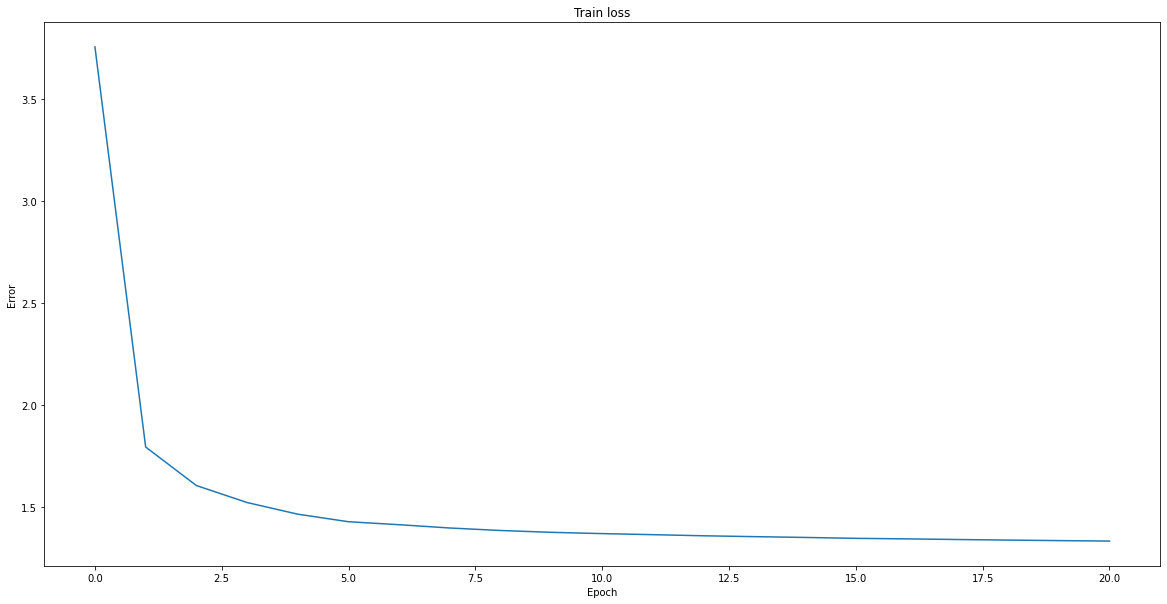

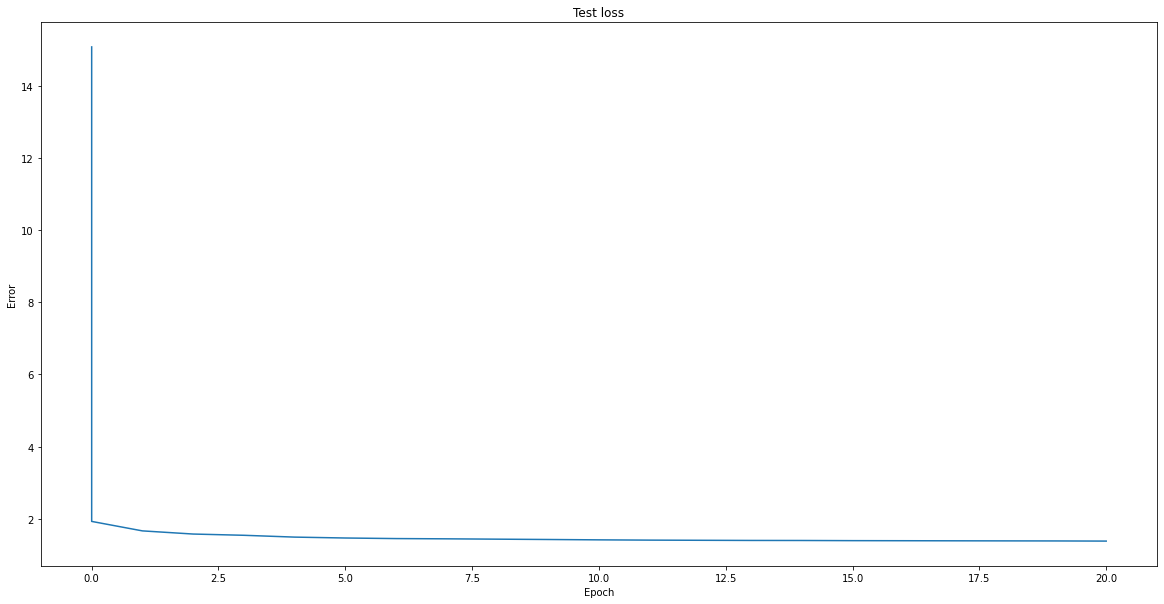

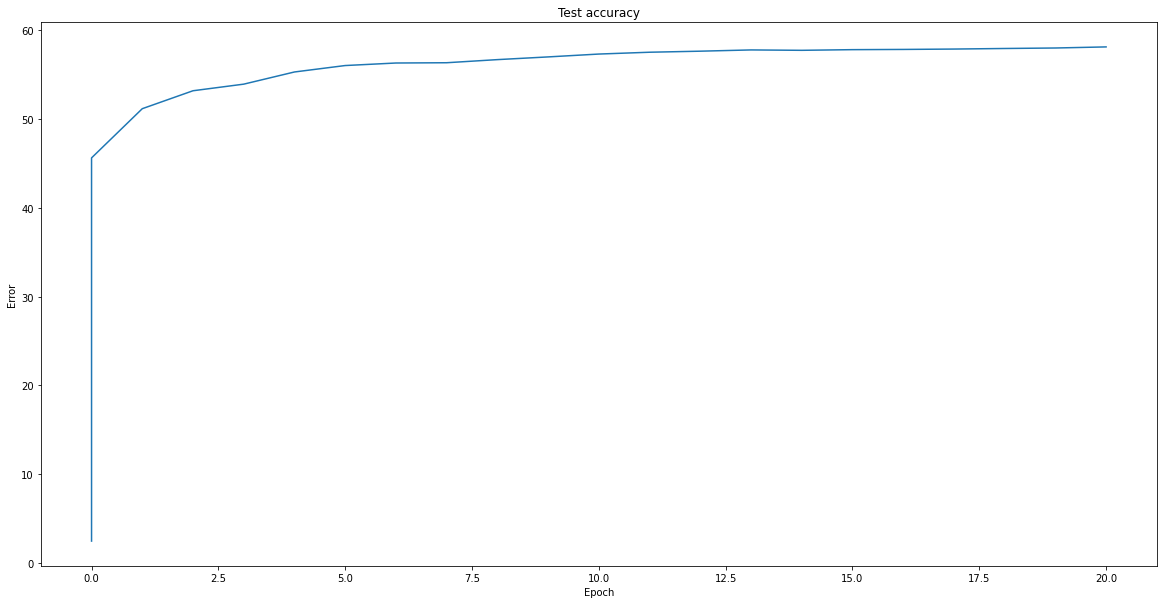

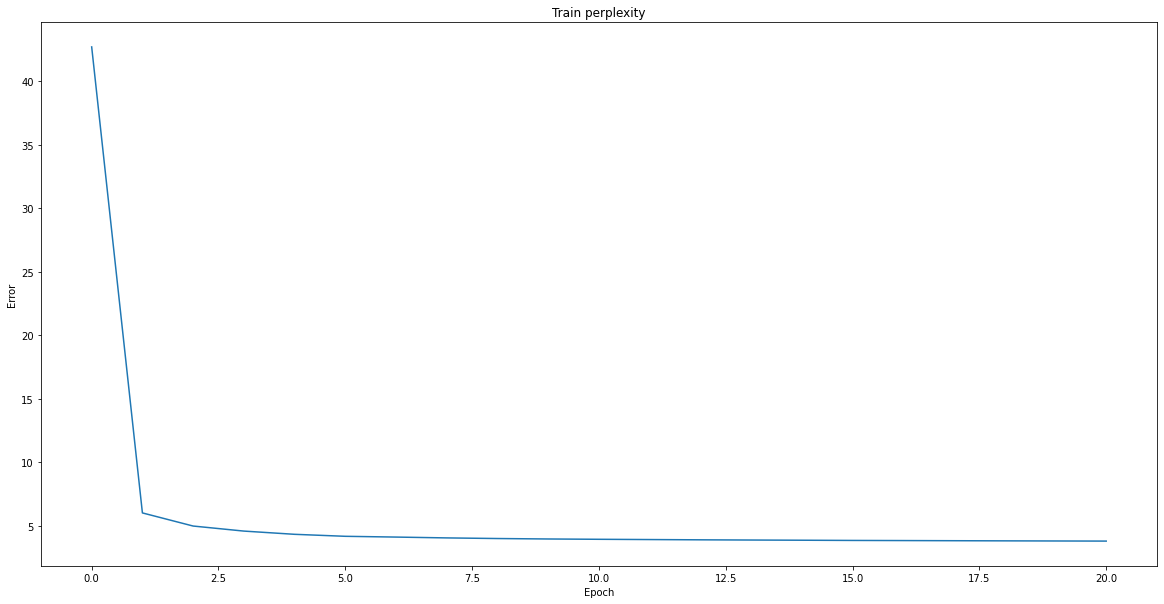

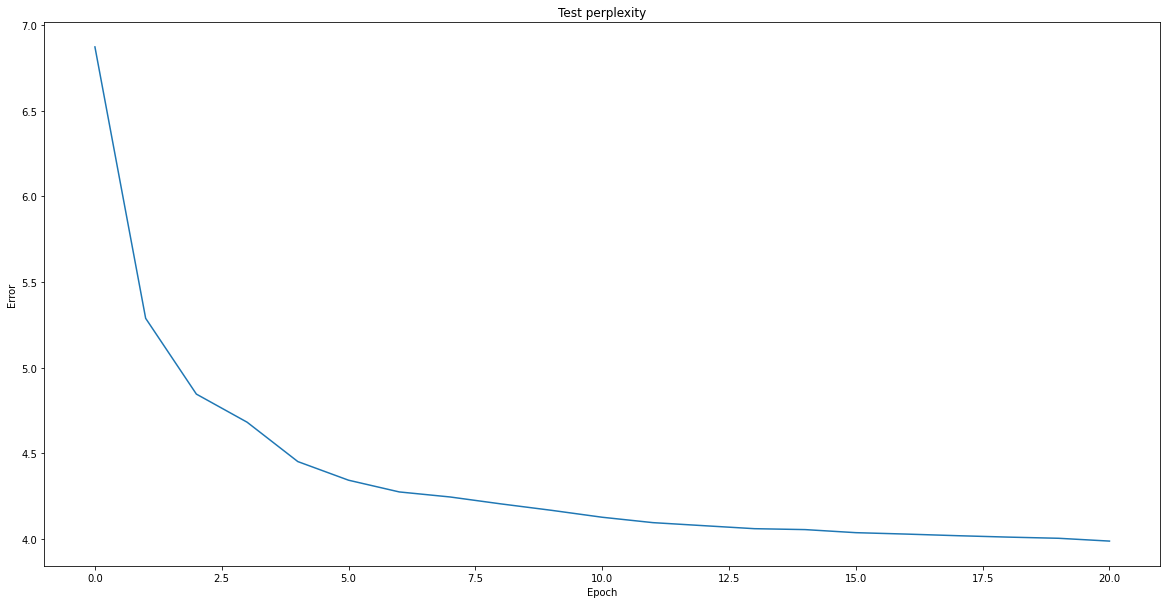

In [10]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pk217'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints112232')

    train_losses, test_losses, test_accuracies, train_perplexities ,test_perplexities =\
    pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)
    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            # calculate perplexities
            train_perplexity = np.exp(train_loss)
            test_perplexity = np.exp(test_loss)

            train_perplexities.append((epoch,train_perplexity))
            test_perplexities.append((epoch,test_perplexity))
            # 

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, 
                                         test_accuracies,train_perplexities,test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [11]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the started of the stairs of the stairs of the stairs and stared at her and stared at her and stared at her and stared at her and stared at her and stared at her and stared at her and stared at her and s
generated with sample	 Harry Potter and them vulled and sluggowed snarple and a magical pointing Silence. "Masue, Colded of Furiousus im to get you changedly?" "I mausted for so... Ron's Hagrid," he shoute all by now. The Harry repeated; Seeps
generated with sample	 Harry Potter and the Someone should me bush else. Un gag, Olaring left and mum anduementor?" "Wham I keep alvery supported. ThatQ!" Hagriddle, knowled the pronted around the plant, burst seemed to gar and the matter of h
generated with sample	 Harry Potter and the for the one, she said, "Don's lot out of these?" Hermione detailed cabiling Cabber for that a lid glassing soar. "What she's I'vel run ... "If'counted to do, you feet if has been at charbaby do, and 
generated with sample	 Harr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


generated with beam	 Harry Potter and the Chinds of elfed coll, leached a real apart from busine, "Shis way cho imprides of pales botts in any," said Potting. "Leam all the Bath?" "Kred and what so I won't go up tourfy that them'rs Qup some!
generated with beam	 Harry Potter and the floor, thick was going to be each on the owlize. "I see dropses himself sometimes enered of Malfoy's juid!" "Anded Minister, you can detely been will mean, taking to him for the wholeworks for the In
generated with beam	 Harry Potter and they really winking found therelving." "Yeah, see it, of cross and hurried to come out," Ron said. "They let out chansifes in to the scar here why do he feet Harry to the castly silvery Hagrid's intermen
generated with beam	 Harry Potter and the right of sure but it without three.... year, what's well, hagridy truck. Whatbe- Fre you hoping would he! thy come of you bu? Inkwe there and down him. The Duirris to have got back, and all in and af
generated with beam	 Harry Potte

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



**1.Train on a different text corpus. **
text: Shakespeare plays

In [10]:
DATA_PATH = '/content/'

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    voc2ind = {}
    print(len(data))
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    count = 0;
    num=0;
    # data=data.replace('\n',' ')
    # data=data.replace('\t',' ')
    data = ' '.join(data.split()) 
    end= int((len(data)+1)*0.8-1)
    # print(len(data));
    train_text= []
    test_text=[]
    for char in data:
         if(char not in voc2ind):
           voc2ind[char]=count;
           count+=1
         # TODO Fill this in
         if(num<=end):
           train_text.append(voc2ind[char])
         else:
           test_text.append(voc2ind[char])
         num+=1

    ind2voc = {val: key for key, val in voc2ind.items()}
    # print(len(test_text))
    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'Shakespeare_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'Shakespeare_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'alllines.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)
 


4583798


Using device cuda
num workers: 2
Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	Iz88'kqqx.kaqkM'bGjkaqu.:Icb.2ke.kG$Qkb33EIbIz..b75G$bMkG52G2bMc2IRMGjk,uQoYbbbHRMG$.klG$$bIeeka3y6


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	slMG$.RDIbIekl$QEiJML22kMbLzkGGkz3qYe22kuMMGekGG..$$bII4GIqkAAOnehX0iJJz(?'3ee'PkAe04OOik:mIkeniJkk


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	z2kGkeik:ee6bEjE6A$bIssl.PJHkM$2E(Abzyyz?MML22k:ee6bakMG522kGk.kkkl.bIXzkGk.3.YbbeMMM$kkAkAkkkekkkk


Input	it BIANCA" "A

  0%|          | 0/144 [00:00<?, ?it/s]


Test set: Average loss: 17.3097, Accuracy: 11566/921600 (1%)



  1%|          | 1/144 [00:00<00:22,  6.49it/s]

Train Epoch: 0 [0/36864 (0%)]	Loss: 17.298965


  9%|▉         | 13/144 [00:00<00:09, 13.81it/s]

Train Epoch: 0 [2560/36864 (7%)]	Loss: 12.392734


 17%|█▋        | 25/144 [00:01<00:06, 18.93it/s]

Train Epoch: 0 [5120/36864 (14%)]	Loss: 6.296267


 24%|██▎       | 34/144 [00:01<00:05, 20.51it/s]

Train Epoch: 0 [7680/36864 (21%)]	Loss: 3.954496


 30%|██▉       | 43/144 [00:02<00:04, 21.31it/s]

Train Epoch: 0 [10240/36864 (28%)]	Loss: 3.049597


 38%|███▊      | 55/144 [00:02<00:04, 20.74it/s]

Train Epoch: 0 [12800/36864 (35%)]	Loss: 2.760971


 44%|████▍     | 64/144 [00:03<00:03, 21.26it/s]

Train Epoch: 0 [15360/36864 (42%)]	Loss: 2.667936


 51%|█████     | 73/144 [00:03<00:03, 21.29it/s]

Train Epoch: 0 [17920/36864 (49%)]	Loss: 2.492867


 59%|█████▉    | 85/144 [00:04<00:02, 21.27it/s]

Train Epoch: 0 [20480/36864 (56%)]	Loss: 2.364837


 65%|██████▌   | 94/144 [00:04<00:02, 21.30it/s]

Train Epoch: 0 [23040/36864 (62%)]	Loss: 2.476917


 72%|███████▏  | 103/144 [00:04<00:01, 21.09it/s]

Train Epoch: 0 [25600/36864 (69%)]	Loss: 2.345590


 80%|███████▉  | 115/144 [00:05<00:01, 21.38it/s]

Train Epoch: 0 [28160/36864 (76%)]	Loss: 2.290913


 86%|████████▌ | 124/144 [00:05<00:00, 21.24it/s]

Train Epoch: 0 [30720/36864 (83%)]	Loss: 2.474447


 92%|█████████▏| 133/144 [00:06<00:00, 21.48it/s]

Train Epoch: 0 [33280/36864 (90%)]	Loss: 2.272583


100%|██████████| 144/144 [00:06<00:00, 20.96it/s]

Train Epoch: 0 [35840/36864 (97%)]	Loss: 2.168622


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nseall w nreye touyleddedhas an hha aaadt "And thth aanuns .aaan  ah buenthaaas hhass a" "Bysflaai


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nenhas   "Byrter  ahn nttau no goalonantntao th n " "Anter aanUOOHHR aanOOLD'G" GAA IEL boEROA, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	anth n aodd nard   "Aege  bant r  haa  s aanantond nllt nonto nyd,  "Ahot toa haan naang aanetn aor


Input	it BIANCA" "And for I know she taketh most del

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care,--" "I hads the fathou grather." "Hexthat the Amnanter of ack that "Byatu," "And havily bind drest and honot." "Of a many not bons and toe" "Reseing sond," "hatutne's that? hat," "And hoperong monving



  1%|          | 1/144 [00:00<00:23,  6.02it/s]

Train Epoch: 1 [0/36864 (0%)]	Loss: 2.088483


  9%|▉         | 13/144 [00:00<00:08, 14.67it/s]

Train Epoch: 1 [2560/36864 (7%)]	Loss: 2.016306


 17%|█▋        | 25/144 [00:01<00:06, 19.07it/s]

Train Epoch: 1 [5120/36864 (14%)]	Loss: 1.920689


 24%|██▎       | 34/144 [00:01<00:05, 20.39it/s]

Train Epoch: 1 [7680/36864 (21%)]	Loss: 1.973549


 30%|██▉       | 43/144 [00:02<00:04, 20.87it/s]

Train Epoch: 1 [10240/36864 (28%)]	Loss: 2.673558


 38%|███▊      | 55/144 [00:02<00:04, 21.04it/s]

Train Epoch: 1 [12800/36864 (35%)]	Loss: 2.254827


 44%|████▍     | 64/144 [00:03<00:03, 21.19it/s]

Train Epoch: 1 [15360/36864 (42%)]	Loss: 1.995973


 51%|█████     | 73/144 [00:03<00:03, 20.92it/s]

Train Epoch: 1 [17920/36864 (49%)]	Loss: 1.903783


 59%|█████▉    | 85/144 [00:04<00:02, 20.68it/s]

Train Epoch: 1 [20480/36864 (56%)]	Loss: 1.831614


 65%|██████▌   | 94/144 [00:04<00:02, 20.95it/s]

Train Epoch: 1 [23040/36864 (62%)]	Loss: 1.838810


 72%|███████▏  | 103/144 [00:05<00:01, 21.17it/s]

Train Epoch: 1 [25600/36864 (69%)]	Loss: 1.853059


 80%|███████▉  | 115/144 [00:05<00:01, 21.13it/s]

Train Epoch: 1 [28160/36864 (76%)]	Loss: 1.873997


 86%|████████▌ | 124/144 [00:06<00:00, 20.59it/s]

Train Epoch: 1 [30720/36864 (83%)]	Loss: 2.038917


 92%|█████████▏| 133/144 [00:06<00:00, 20.85it/s]

Train Epoch: 1 [33280/36864 (90%)]	Loss: 1.944402


100%|██████████| 144/144 [00:06<00:00, 20.59it/s]

Train Epoch: 1 [35840/36864 (97%)]	Loss: 1.856095


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsooll w srace th hracderhas an the coap  "And seth tomeln  ooen  oh huenceeaes chessta" "Iyscrrco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhooes " "Iyrter  thre hoauemh berlomentntao hh n"" "Inter AARUHUHHR aanOOL NA, aAAN,HL aoEROA, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	annh   bood oord   "Aosh  bynt r, her  s oonentond orrteoenth nrd," "Ahet ter e an tornd oanean car


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "Whose? boke hard, thoughty bake." "And to your bear her perfort beng's cround rues." "No, sir, Re--enter but flostion:" "If thy hen were honor. SIa," "If I'll in that shall his beda," "Forroun, bli



  1%|          | 1/144 [00:00<00:22,  6.41it/s]

Train Epoch: 2 [0/36864 (0%)]	Loss: 1.836905


  9%|▉         | 13/144 [00:00<00:09, 13.75it/s]

Train Epoch: 2 [2560/36864 (7%)]	Loss: 1.841347


 17%|█▋        | 24/144 [00:01<00:06, 18.47it/s]

Train Epoch: 2 [5120/36864 (14%)]	Loss: 1.810618


 23%|██▎       | 33/144 [00:01<00:05, 20.00it/s]

Train Epoch: 2 [7680/36864 (21%)]	Loss: 1.934042


 31%|███▏      | 45/144 [00:02<00:04, 21.04it/s]

Train Epoch: 2 [10240/36864 (28%)]	Loss: 1.893702


 38%|███▊      | 54/144 [00:02<00:04, 21.59it/s]

Train Epoch: 2 [12800/36864 (35%)]	Loss: 1.856086


 44%|████▍     | 63/144 [00:03<00:03, 21.62it/s]

Train Epoch: 2 [15360/36864 (42%)]	Loss: 1.860993


 52%|█████▏    | 75/144 [00:03<00:03, 21.33it/s]

Train Epoch: 2 [17920/36864 (49%)]	Loss: 1.784932


 58%|█████▊    | 84/144 [00:04<00:02, 20.94it/s]

Train Epoch: 2 [20480/36864 (56%)]	Loss: 1.722208


 65%|██████▍   | 93/144 [00:04<00:02, 21.30it/s]

Train Epoch: 2 [23040/36864 (62%)]	Loss: 1.775513


 73%|███████▎  | 105/144 [00:05<00:01, 21.16it/s]

Train Epoch: 2 [25600/36864 (69%)]	Loss: 1.738882


 79%|███████▉  | 114/144 [00:05<00:01, 21.11it/s]

Train Epoch: 2 [28160/36864 (76%)]	Loss: 1.693100


 85%|████████▌ | 123/144 [00:05<00:00, 21.16it/s]

Train Epoch: 2 [30720/36864 (83%)]	Loss: 1.715645


 94%|█████████▍| 135/144 [00:06<00:00, 21.55it/s]

Train Epoch: 2 [33280/36864 (90%)]	Loss: 1.765539


100%|██████████| 144/144 [00:06<00:00, 20.96it/s]

Train Epoch: 2 [35840/36864 (97%)]	Loss: 1.793449


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nshell wssraceiih tract roim an thi fiadi "And shth thy ls  ohem  hh bueethiiim hhis t," "Iysfrrco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhhhis " "Iyrter  th e thiu hh bhrlomestp hh th n " "Wnter tARHHU HR aENOOR NA, aAUNGHL aoEREN, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	annh   nood nord   "Aet   sydt r  tir  s nhne tond nrrtenesth nrd," "Ahet tirth is nhrtt oynetn tar


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care,-" "Come in this not know-" "Not in to placerague thy fathir." "But this in pruthing him ight: Jure her their our brotther faglaint was must" "Vill shame not thou think your facbind," "And shoulsed be



  1%|          | 1/144 [00:00<00:23,  5.96it/s]

Train Epoch: 3 [0/36864 (0%)]	Loss: 1.766312


 10%|▉         | 14/144 [00:00<00:08, 14.70it/s]

Train Epoch: 3 [2560/36864 (7%)]	Loss: 1.760834


 16%|█▌        | 23/144 [00:01<00:06, 18.38it/s]

Train Epoch: 3 [5120/36864 (14%)]	Loss: 1.696351


 24%|██▍       | 35/144 [00:01<00:05, 20.72it/s]

Train Epoch: 3 [7680/36864 (21%)]	Loss: 1.687207


 31%|███       | 44/144 [00:02<00:04, 20.82it/s]

Train Epoch: 3 [10240/36864 (28%)]	Loss: 1.692736


 37%|███▋      | 53/144 [00:02<00:04, 21.04it/s]

Train Epoch: 3 [12800/36864 (35%)]	Loss: 1.672188


 45%|████▌     | 65/144 [00:03<00:03, 21.53it/s]

Train Epoch: 3 [15360/36864 (42%)]	Loss: 1.692179


 51%|█████▏    | 74/144 [00:03<00:03, 20.87it/s]

Train Epoch: 3 [17920/36864 (49%)]	Loss: 1.788902


 58%|█████▊    | 83/144 [00:04<00:02, 21.40it/s]

Train Epoch: 3 [20480/36864 (56%)]	Loss: 1.735522


 66%|██████▌   | 95/144 [00:04<00:02, 20.93it/s]

Train Epoch: 3 [23040/36864 (62%)]	Loss: 1.696706


 72%|███████▏  | 104/144 [00:05<00:01, 21.05it/s]

Train Epoch: 3 [25600/36864 (69%)]	Loss: 1.658989


 78%|███████▊  | 113/144 [00:05<00:01, 21.00it/s]

Train Epoch: 3 [28160/36864 (76%)]	Loss: 1.649282


 87%|████████▋ | 125/144 [00:06<00:00, 21.67it/s]

Train Epoch: 3 [30720/36864 (83%)]	Loss: 1.659464


 93%|█████████▎| 134/144 [00:06<00:00, 21.55it/s]

Train Epoch: 3 [33280/36864 (90%)]	Loss: 1.648348


100%|██████████| 144/144 [00:06<00:00, 20.85it/s]

Train Epoch: 3 [35840/36864 (97%)]	Loss: 1.650084


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nmoell wssractmth bracd roem tn the fradi "And shth tuyins, ohem  oh bueeceeaem shen,t," "Iysfrrco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhes " "Iyrter  th ettoauehh berlomestn th th n " "Inter tARHHP OR aINOOR NA, aAUNGHL aOEREN, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	anth   bood mord,  "Aent  sydter  Were s tenettond mrrtenesth nrd," "Ahet terteetn torrd oedetf far


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "And curston." "SCENE II. BRUTHA, PRE I." Exeumbt horning carding in againstemple" "Spearend, whore Idring morn'd," "But up, thereyeld, this says" "Stabing my bening bluts' notia." "What pressecause



  1%|          | 1/144 [00:00<00:17,  7.95it/s]

Train Epoch: 4 [0/36864 (0%)]	Loss: 1.684463


 10%|█         | 15/144 [00:00<00:07, 16.48it/s]

Train Epoch: 4 [2560/36864 (7%)]	Loss: 1.704558


 17%|█▋        | 24/144 [00:01<00:06, 18.84it/s]

Train Epoch: 4 [5120/36864 (14%)]	Loss: 1.677114


 23%|██▎       | 33/144 [00:01<00:05, 20.39it/s]

Train Epoch: 4 [7680/36864 (21%)]	Loss: 1.670973


 31%|███▏      | 45/144 [00:02<00:04, 20.90it/s]

Train Epoch: 4 [10240/36864 (28%)]	Loss: 1.662045


 38%|███▊      | 54/144 [00:02<00:04, 20.63it/s]

Train Epoch: 4 [12800/36864 (35%)]	Loss: 1.619381


 44%|████▍     | 63/144 [00:03<00:03, 21.09it/s]

Train Epoch: 4 [15360/36864 (42%)]	Loss: 1.599001


 52%|█████▏    | 75/144 [00:03<00:03, 20.85it/s]

Train Epoch: 4 [17920/36864 (49%)]	Loss: 1.632693


 58%|█████▊    | 84/144 [00:04<00:02, 21.15it/s]

Train Epoch: 4 [20480/36864 (56%)]	Loss: 1.611308


 65%|██████▍   | 93/144 [00:04<00:02, 21.37it/s]

Train Epoch: 4 [23040/36864 (62%)]	Loss: 1.640012


 73%|███████▎  | 105/144 [00:05<00:01, 21.03it/s]

Train Epoch: 4 [25600/36864 (69%)]	Loss: 1.623764


 79%|███████▉  | 114/144 [00:05<00:01, 21.23it/s]

Train Epoch: 4 [28160/36864 (76%)]	Loss: 1.645281


 85%|████████▌ | 123/144 [00:05<00:00, 21.39it/s]

Train Epoch: 4 [30720/36864 (83%)]	Loss: 1.675222


 94%|█████████▍| 135/144 [00:06<00:00, 21.41it/s]

Train Epoch: 4 [33280/36864 (90%)]	Loss: 1.646098


100%|██████████| 144/144 [00:06<00:00, 20.91it/s]

Train Epoch: 4 [35840/36864 (97%)]	Loss: 1.623589


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll wssaaytmth sracc roim on thi srad  "And shth tuy fsy ohem  oh bueecheaim shas,t," "Iysfrrco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhas " "Iyyter  Ih e ohauehh bealomestn uh th n " "Inter CARHHU ER aINROR NA, aASNGEL LOEREN, Snd


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	anth   sood nord   "Went  syyter  Wor  s nhne ornd nrrsanesto nrd," "Ihet te theos surnd oynehf hhr


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "In exch not wakex mischy?" "Hear flastingue, is actisfamitations," "His should and curcholy me," "Not this alliands." "let beeing fied, shall discord: I was Rouchly a," "And is mind me, chose," "Yo



  1%|          | 1/144 [00:00<00:18,  7.69it/s]

Train Epoch: 5 [0/36864 (0%)]	Loss: 1.635851


 10%|█         | 15/144 [00:00<00:07, 16.32it/s]

Train Epoch: 5 [2560/36864 (7%)]	Loss: 1.640220


 17%|█▋        | 24/144 [00:01<00:06, 19.32it/s]

Train Epoch: 5 [5120/36864 (14%)]	Loss: 1.599010


 23%|██▎       | 33/144 [00:01<00:05, 20.55it/s]

Train Epoch: 5 [7680/36864 (21%)]	Loss: 1.599800


 31%|███▏      | 45/144 [00:02<00:04, 21.15it/s]

Train Epoch: 5 [10240/36864 (28%)]	Loss: 1.637431


 38%|███▊      | 54/144 [00:02<00:04, 21.56it/s]

Train Epoch: 5 [12800/36864 (35%)]	Loss: 1.660239


 44%|████▍     | 63/144 [00:03<00:03, 21.27it/s]

Train Epoch: 5 [15360/36864 (42%)]	Loss: 1.590476


 52%|█████▏    | 75/144 [00:03<00:03, 20.53it/s]

Train Epoch: 5 [17920/36864 (49%)]	Loss: 1.626361


 58%|█████▊    | 84/144 [00:04<00:02, 21.42it/s]

Train Epoch: 5 [20480/36864 (56%)]	Loss: 1.624395


 65%|██████▍   | 93/144 [00:04<00:02, 21.15it/s]

Train Epoch: 5 [23040/36864 (62%)]	Loss: 1.625650


 73%|███████▎  | 105/144 [00:05<00:01, 21.38it/s]

Train Epoch: 5 [25600/36864 (69%)]	Loss: 1.602318


 79%|███████▉  | 114/144 [00:05<00:01, 21.17it/s]

Train Epoch: 5 [28160/36864 (76%)]	Loss: 1.603597


 85%|████████▌ | 123/144 [00:05<00:01, 20.88it/s]

Train Epoch: 5 [30720/36864 (83%)]	Loss: 1.597185


 94%|█████████▍| 135/144 [00:06<00:00, 21.47it/s]

Train Epoch: 5 [33280/36864 (90%)]	Loss: 1.590792


100%|██████████| 144/144 [00:06<00:00, 20.93it/s]

Train Epoch: 5 [35840/36864 (97%)]	Loss: 1.590092


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nseoll wssrayt th bracc roim tn thi srad  "And shth toy fs  ohem  oh bueechetim shandt " "Tysbrrco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhas " "Iyyter  th e ohau hh berlome tn to th n " "Inter tARHHU HR aIRROR N,, aASNGEL aOENEN, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	anth   aood mord   "Aett  sydter  Wer  s nene trnd mrrs nesto nrd " "Thet te th tn tortd tydeaf far


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "And the ground of the times for our or pleasure thusZon of fly" "queen sonsmat" "Mray is city are said of "near meting of Serrie, with sweet you," "And where of your full undertaink." Exeunt "When 



  1%|          | 1/144 [00:00<00:17,  8.09it/s]

Train Epoch: 6 [0/36864 (0%)]	Loss: 1.591146


  9%|▉         | 13/144 [00:00<00:08, 15.24it/s]

Train Epoch: 6 [2560/36864 (7%)]	Loss: 1.609031


 17%|█▋        | 24/144 [00:01<00:06, 19.21it/s]

Train Epoch: 6 [5120/36864 (14%)]	Loss: 1.576457


 23%|██▎       | 33/144 [00:01<00:05, 20.31it/s]

Train Epoch: 6 [7680/36864 (21%)]	Loss: 1.565860


 31%|███▏      | 45/144 [00:02<00:04, 21.36it/s]

Train Epoch: 6 [10240/36864 (28%)]	Loss: 1.605887


 38%|███▊      | 54/144 [00:02<00:04, 21.28it/s]

Train Epoch: 6 [12800/36864 (35%)]	Loss: 1.607445


 44%|████▍     | 63/144 [00:03<00:03, 21.11it/s]

Train Epoch: 6 [15360/36864 (42%)]	Loss: 1.577070


 50%|█████     | 72/144 [00:03<00:03, 19.73it/s]

Train Epoch: 6 [17920/36864 (49%)]	Loss: 1.600348


 58%|█████▊    | 84/144 [00:04<00:02, 20.94it/s]

Train Epoch: 6 [20480/36864 (56%)]	Loss: 1.564827


 65%|██████▍   | 93/144 [00:04<00:02, 21.35it/s]

Train Epoch: 6 [23040/36864 (62%)]	Loss: 1.578924


 73%|███████▎  | 105/144 [00:05<00:01, 21.47it/s]

Train Epoch: 6 [25600/36864 (69%)]	Loss: 1.574378


 79%|███████▉  | 114/144 [00:05<00:01, 21.11it/s]

Train Epoch: 6 [28160/36864 (76%)]	Loss: 1.559665


 85%|████████▌ | 123/144 [00:05<00:00, 21.16it/s]

Train Epoch: 6 [30720/36864 (83%)]	Loss: 1.569357


 94%|█████████▍| 135/144 [00:06<00:00, 21.20it/s]

Train Epoch: 6 [33280/36864 (90%)]	Loss: 1.568708


100%|██████████| 144/144 [00:06<00:00, 20.91it/s]

Train Epoch: 6 [35840/36864 (97%)]	Loss: 1.560593


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll wssrayt th bracc roim sn theisrad  "Tnd shth toyifsy ohem  oh bueecheaim shandt," "Tysbrrco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhas " "Tyyter  ah etohausmh berlomestn to th n " "Tnter CARTHU HR aIRIOR N,, aASNGER aOENEN, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	anth   aood mord   "Aett  sydter  Were s nonetorod mrrs,nesto nrd," "Thet te th ss toand tydeaf far


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "utom'd in a habling songst Raidas" "But this send-conce-Crate," "But child, I think orceivence?" "That art bloody conceiman is grounder," "Then your grace sorn. Go, my womnio," "And sorvil gieven o



  1%|          | 1/144 [00:00<00:19,  7.46it/s]

Train Epoch: 7 [0/36864 (0%)]	Loss: 1.587227


 10%|█         | 15/144 [00:00<00:07, 16.34it/s]

Train Epoch: 7 [2560/36864 (7%)]	Loss: 1.595568


 17%|█▋        | 24/144 [00:01<00:06, 19.14it/s]

Train Epoch: 7 [5120/36864 (14%)]	Loss: 1.557025


 23%|██▎       | 33/144 [00:01<00:05, 20.61it/s]

Train Epoch: 7 [7680/36864 (21%)]	Loss: 1.552962


 31%|███▏      | 45/144 [00:02<00:04, 21.10it/s]

Train Epoch: 7 [10240/36864 (28%)]	Loss: 1.558872


 38%|███▊      | 54/144 [00:02<00:04, 21.38it/s]

Train Epoch: 7 [12800/36864 (35%)]	Loss: 1.560140


 44%|████▍     | 63/144 [00:03<00:03, 21.39it/s]

Train Epoch: 7 [15360/36864 (42%)]	Loss: 1.594650


 52%|█████▏    | 75/144 [00:03<00:03, 20.15it/s]

Train Epoch: 7 [17920/36864 (49%)]	Loss: 1.598749


 58%|█████▊    | 84/144 [00:04<00:02, 21.01it/s]

Train Epoch: 7 [20480/36864 (56%)]	Loss: 1.571886


 65%|██████▍   | 93/144 [00:04<00:02, 21.26it/s]

Train Epoch: 7 [23040/36864 (62%)]	Loss: 1.572839


 73%|███████▎  | 105/144 [00:05<00:01, 21.18it/s]

Train Epoch: 7 [25600/36864 (69%)]	Loss: 1.563906


 79%|███████▉  | 114/144 [00:05<00:01, 21.23it/s]

Train Epoch: 7 [28160/36864 (76%)]	Loss: 1.574331


 85%|████████▌ | 123/144 [00:05<00:00, 21.36it/s]

Train Epoch: 7 [30720/36864 (83%)]	Loss: 1.570359


 94%|█████████▍| 135/144 [00:06<00:00, 21.31it/s]

Train Epoch: 7 [33280/36864 (90%)]	Loss: 1.534564


100%|██████████| 144/144 [00:06<00:00, 20.96it/s]

Train Epoch: 7 [35840/36864 (97%)]	Loss: 1.539428


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll w mrayt th bracc roim an thi fead  "Tnd sith toyissy,ohem  oh bueechemis srandt " "Tysfrrco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhas " "Iyyter  Ii etohau mh birlome tn to th n " "Wnter CARTIU  R aIRIOR N,, aANNGER aOENEN, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	annh   aood mord   "Went  sydter  Iere s nene ornd mrrs nesto nrd " "Thet ti themn toand oeneaf fir


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "Why lord, Harly, bukfil--orn, I way" "hence-bove, shall unclemata and flament" "That should with thrown." "Enter true." "Since is not on usuit all in makes" "On have now en did steap on this ringle



  1%|          | 1/144 [00:00<00:17,  8.02it/s]

Train Epoch: 8 [0/36864 (0%)]	Loss: 1.555086


  9%|▉         | 13/144 [00:00<00:08, 15.47it/s]

Train Epoch: 8 [2560/36864 (7%)]	Loss: 1.569466


 17%|█▋        | 25/144 [00:01<00:06, 19.72it/s]

Train Epoch: 8 [5120/36864 (14%)]	Loss: 1.545069


 24%|██▎       | 34/144 [00:01<00:05, 20.87it/s]

Train Epoch: 8 [7680/36864 (21%)]	Loss: 1.541562


 30%|██▉       | 43/144 [00:02<00:04, 20.76it/s]

Train Epoch: 8 [10240/36864 (28%)]	Loss: 1.541256


 38%|███▊      | 55/144 [00:02<00:04, 21.35it/s]

Train Epoch: 8 [12800/36864 (35%)]	Loss: 1.544157


 44%|████▍     | 64/144 [00:03<00:03, 21.61it/s]

Train Epoch: 8 [15360/36864 (42%)]	Loss: 1.550531


 51%|█████     | 73/144 [00:03<00:03, 20.72it/s]

Train Epoch: 8 [17920/36864 (49%)]	Loss: 1.583720


 59%|█████▉    | 85/144 [00:04<00:02, 21.44it/s]

Train Epoch: 8 [20480/36864 (56%)]	Loss: 1.545481


 65%|██████▌   | 94/144 [00:04<00:02, 21.63it/s]

Train Epoch: 8 [23040/36864 (62%)]	Loss: 1.553798


 72%|███████▏  | 103/144 [00:04<00:01, 21.48it/s]

Train Epoch: 8 [25600/36864 (69%)]	Loss: 1.545722


 80%|███████▉  | 115/144 [00:05<00:01, 21.61it/s]

Train Epoch: 8 [28160/36864 (76%)]	Loss: 1.550864


 86%|████████▌ | 124/144 [00:05<00:00, 21.39it/s]

Train Epoch: 8 [30720/36864 (83%)]	Loss: 1.555481


 92%|█████████▏| 133/144 [00:06<00:00, 20.97it/s]

Train Epoch: 8 [33280/36864 (90%)]	Loss: 1.528609


100%|██████████| 144/144 [00:06<00:00, 21.17it/s]

Train Epoch: 8 [35840/36864 (97%)]	Loss: 1.526464


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll w mrayt th bracc roim an thi fead  "Tnd sith toyiss  ohem  oh bueechemis srandt " "Tyscrrco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhas " "Iyrter  ai etohau mh birlome tn to th n " "Wnter CARTIU  R aIRIAR N,, aANNGER aOENEN, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	annh   aood mord   "Went  sydter  wa e s none mrnd mrrs nento nrd " "Ahet ti themn toond aenean far


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "Know, my son, in pleasing to thing'n hed" "What a lays in Warwick Bast along'd." "Why, distray, gives a glarpets" "By now mind, holy or dead," "But lawcy are young nor all their ageat or manight." 



  1%|          | 1/144 [00:00<00:19,  7.25it/s]

Train Epoch: 9 [0/36864 (0%)]	Loss: 1.543887


 10%|█         | 15/144 [00:00<00:08, 16.00it/s]

Train Epoch: 9 [2560/36864 (7%)]	Loss: 1.558403


 17%|█▋        | 24/144 [00:01<00:06, 18.82it/s]

Train Epoch: 9 [5120/36864 (14%)]	Loss: 1.534269


 23%|██▎       | 33/144 [00:01<00:05, 20.06it/s]

Train Epoch: 9 [7680/36864 (21%)]	Loss: 1.527785


 31%|███▏      | 45/144 [00:02<00:04, 21.33it/s]

Train Epoch: 9 [10240/36864 (28%)]	Loss: 1.532113


 38%|███▊      | 54/144 [00:02<00:04, 20.97it/s]

Train Epoch: 9 [12800/36864 (35%)]	Loss: 1.537880


 44%|████▍     | 63/144 [00:03<00:03, 21.06it/s]

Train Epoch: 9 [15360/36864 (42%)]	Loss: 1.525126


 52%|█████▏    | 75/144 [00:03<00:03, 21.15it/s]

Train Epoch: 9 [17920/36864 (49%)]	Loss: 1.563510


 58%|█████▊    | 84/144 [00:04<00:02, 21.07it/s]

Train Epoch: 9 [20480/36864 (56%)]	Loss: 1.528509


 65%|██████▍   | 93/144 [00:04<00:02, 21.30it/s]

Train Epoch: 9 [23040/36864 (62%)]	Loss: 1.542313


 73%|███████▎  | 105/144 [00:05<00:01, 21.17it/s]

Train Epoch: 9 [25600/36864 (69%)]	Loss: 1.540422


 79%|███████▉  | 114/144 [00:05<00:01, 21.17it/s]

Train Epoch: 9 [28160/36864 (76%)]	Loss: 1.539720


 85%|████████▌ | 123/144 [00:05<00:00, 21.32it/s]

Train Epoch: 9 [30720/36864 (83%)]	Loss: 1.538013


 94%|█████████▍| 135/144 [00:06<00:00, 21.28it/s]

Train Epoch: 9 [33280/36864 (90%)]	Loss: 1.521887


100%|██████████| 144/144 [00:06<00:00, 20.85it/s]

Train Epoch: 9 [35840/36864 (97%)]	Loss: 1.519772


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll w mlact th blacc roim an thi fead  "And silh aoyiss  ohem  oh bueech oim lrandt " "Iyscurco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhas " "Iyrter  wi e ohau mh birlome tn to bh n " "Wnter CORTIN  R aIRIAR N,, aANNGER aOENEN, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	annh   aood mord   "Went, wydter  wa e s none ornd mrrs nento nrd " "Ahet ti  hemn toand oenean far


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "Ented thee like an art by his spoke," "And gariends a honest from honour one! offeranchil" "But, but that will now please you:." "Dousin 'Cquiteona had word, unborchedge, my" "flow'd will never min



  1%|          | 1/144 [00:00<00:17,  8.14it/s]

Train Epoch: 10 [0/36864 (0%)]	Loss: 1.536568


  9%|▉         | 13/144 [00:00<00:08, 15.42it/s]

Train Epoch: 10 [2560/36864 (7%)]	Loss: 1.551975


 17%|█▋        | 25/144 [00:01<00:06, 19.71it/s]

Train Epoch: 10 [5120/36864 (14%)]	Loss: 1.520585


 24%|██▎       | 34/144 [00:01<00:05, 20.71it/s]

Train Epoch: 10 [7680/36864 (21%)]	Loss: 1.527051


 30%|██▉       | 43/144 [00:02<00:04, 20.80it/s]

Train Epoch: 10 [10240/36864 (28%)]	Loss: 1.529369


 38%|███▊      | 55/144 [00:02<00:04, 20.96it/s]

Train Epoch: 10 [12800/36864 (35%)]	Loss: 1.520255


 44%|████▍     | 64/144 [00:03<00:03, 20.82it/s]

Train Epoch: 10 [15360/36864 (42%)]	Loss: 1.521941


 51%|█████     | 73/144 [00:03<00:03, 20.60it/s]

Train Epoch: 10 [17920/36864 (49%)]	Loss: 1.558419


 59%|█████▉    | 85/144 [00:04<00:02, 21.13it/s]

Train Epoch: 10 [20480/36864 (56%)]	Loss: 1.520361


 65%|██████▌   | 94/144 [00:04<00:02, 21.63it/s]

Train Epoch: 10 [23040/36864 (62%)]	Loss: 1.532064


 72%|███████▏  | 103/144 [00:04<00:01, 21.42it/s]

Train Epoch: 10 [25600/36864 (69%)]	Loss: 1.535188


 80%|███████▉  | 115/144 [00:05<00:01, 21.70it/s]

Train Epoch: 10 [28160/36864 (76%)]	Loss: 1.527261


 86%|████████▌ | 124/144 [00:05<00:00, 21.24it/s]

Train Epoch: 10 [30720/36864 (83%)]	Loss: 1.538350


 92%|█████████▏| 133/144 [00:06<00:00, 21.41it/s]

Train Epoch: 10 [33280/36864 (90%)]	Loss: 1.512981


100%|██████████| 144/144 [00:06<00:00, 20.99it/s]

Train Epoch: 10 [35840/36864 (97%)]	Loss: 1.506296


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll w oraceeth blact roim an thiifead  "Tnd silh toyiss  ohem  th bueecheoim lrandt," "Iescuaco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhas " "Iyrter  wi etohousmh bealome tn to bh n " "Wnter CORTIN  R aIRIAR S,, aANNEER aOENEN, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	enth   aood mord   "West, wydter  we e s none ornd mrrs nento nrds" "Ihet te themn toond oyneaf far


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "Their on eighin that Judies, and wases sink." "Iselves a makes head, a must not burbearied." "That, I will not, that sweater that I say" "It and why wish, though a questeousled," "Of holdeld years 



  1%|          | 1/144 [00:00<00:17,  8.13it/s]

Train Epoch: 11 [0/36864 (0%)]	Loss: 1.526160


  9%|▉         | 13/144 [00:00<00:08, 15.48it/s]

Train Epoch: 11 [2560/36864 (7%)]	Loss: 1.551661


 17%|█▋        | 25/144 [00:01<00:06, 19.21it/s]

Train Epoch: 11 [5120/36864 (14%)]	Loss: 1.521830


 24%|██▎       | 34/144 [00:01<00:05, 20.34it/s]

Train Epoch: 11 [7680/36864 (21%)]	Loss: 1.515207


 30%|██▉       | 43/144 [00:02<00:04, 20.92it/s]

Train Epoch: 11 [10240/36864 (28%)]	Loss: 1.520223


 38%|███▊      | 55/144 [00:02<00:04, 21.09it/s]

Train Epoch: 11 [12800/36864 (35%)]	Loss: 1.511592


 44%|████▍     | 64/144 [00:03<00:03, 20.84it/s]

Train Epoch: 11 [15360/36864 (42%)]	Loss: 1.506712


 51%|█████     | 73/144 [00:03<00:03, 20.88it/s]

Train Epoch: 11 [17920/36864 (49%)]	Loss: 1.543792


 59%|█████▉    | 85/144 [00:04<00:02, 21.23it/s]

Train Epoch: 11 [20480/36864 (56%)]	Loss: 1.513560


 65%|██████▌   | 94/144 [00:04<00:02, 21.67it/s]

Train Epoch: 11 [23040/36864 (62%)]	Loss: 1.529496


 72%|███████▏  | 103/144 [00:04<00:01, 21.22it/s]

Train Epoch: 11 [25600/36864 (69%)]	Loss: 1.532514


 80%|███████▉  | 115/144 [00:05<00:01, 21.66it/s]

Train Epoch: 11 [28160/36864 (76%)]	Loss: 1.519051


 86%|████████▌ | 124/144 [00:05<00:00, 21.17it/s]

Train Epoch: 11 [30720/36864 (83%)]	Loss: 1.549243


 92%|█████████▏| 133/144 [00:06<00:00, 21.54it/s]

Train Epoch: 11 [33280/36864 (90%)]	Loss: 1.509493


100%|██████████| 144/144 [00:06<00:00, 21.00it/s]

Train Epoch: 11 [35840/36864 (97%)]	Loss: 1.505781


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll w orayeeth ylact roim an thi fead  "Tnd sith toyiss  ohem  th bueechooim lrasdt," "Iesdraco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhis " "Iyrter  wimetooousmh billome tn to th n " "Wnter CORTIN  R aIRIAR S,, aANNEER aOENEN, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	enth   aood mord,  "West, wydter  we e s none ornd mrrs nento nrds" "Ihet te themn toond oyneaf far


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "What does blive nor a subject." "Peter, sir, consyment his flocestancess on Frenchdants" "But gid him feely but taked bariag9." "Be life, when it purked in hing?" "Noothsaliving," "No fear cheed. W



  1%|          | 1/144 [00:00<00:17,  8.02it/s]

Train Epoch: 12 [0/36864 (0%)]	Loss: 1.519324


 10%|█         | 15/144 [00:00<00:07, 16.82it/s]

Train Epoch: 12 [2560/36864 (7%)]	Loss: 1.548760


 17%|█▋        | 24/144 [00:01<00:06, 19.62it/s]

Train Epoch: 12 [5120/36864 (14%)]	Loss: 1.518756


 23%|██▎       | 33/144 [00:01<00:05, 20.55it/s]

Train Epoch: 12 [7680/36864 (21%)]	Loss: 1.506919


 31%|███▏      | 45/144 [00:02<00:04, 21.03it/s]

Train Epoch: 12 [10240/36864 (28%)]	Loss: 1.515113


 38%|███▊      | 54/144 [00:02<00:04, 21.68it/s]

Train Epoch: 12 [12800/36864 (35%)]	Loss: 1.508200


 44%|████▍     | 63/144 [00:03<00:03, 21.49it/s]

Train Epoch: 12 [15360/36864 (42%)]	Loss: 1.503395


 52%|█████▏    | 75/144 [00:03<00:03, 20.96it/s]

Train Epoch: 12 [17920/36864 (49%)]	Loss: 1.534298


 58%|█████▊    | 84/144 [00:04<00:02, 21.34it/s]

Train Epoch: 12 [20480/36864 (56%)]	Loss: 1.507369


 65%|██████▍   | 93/144 [00:04<00:02, 21.38it/s]

Train Epoch: 12 [23040/36864 (62%)]	Loss: 1.519409


 73%|███████▎  | 105/144 [00:05<00:01, 21.21it/s]

Train Epoch: 12 [25600/36864 (69%)]	Loss: 1.522879


 79%|███████▉  | 114/144 [00:05<00:01, 21.40it/s]

Train Epoch: 12 [28160/36864 (76%)]	Loss: 1.508771


 85%|████████▌ | 123/144 [00:05<00:00, 21.31it/s]

Train Epoch: 12 [30720/36864 (83%)]	Loss: 1.529996


 94%|█████████▍| 135/144 [00:06<00:00, 21.55it/s]

Train Epoch: 12 [33280/36864 (90%)]	Loss: 1.501937


100%|██████████| 144/144 [00:06<00:00, 21.10it/s]

Train Epoch: 12 [35840/36864 (97%)]	Loss: 1.498670


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll w olayeeth ylact roim an thi fead  "Tnd sith toyiss  ohem  th bueeth oim loandt," "Iysdraco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhis " "Iyrter  wimetooousmh millome tn to th n " "Wnter COREIN  R aARIAR,S,, aANREER aAENEN, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	enth   aood mord,  "West, wydter  Ie e s none frnd mrrs nanto nrds" "Whet te themn toond oyneaf for


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "He would her that howerld by toops," "How sick his mean of me thange," "Which effect on chrace, and desive in evisy sat" "He haved a follows too snouls, but fonder knges," "Myself and pudded flound



  1%|          | 1/144 [00:00<00:17,  8.11it/s]

Train Epoch: 13 [0/36864 (0%)]	Loss: 1.511674


  9%|▉         | 13/144 [00:00<00:08, 15.36it/s]

Train Epoch: 13 [2560/36864 (7%)]	Loss: 1.544887


 17%|█▋        | 25/144 [00:01<00:06, 19.39it/s]

Train Epoch: 13 [5120/36864 (14%)]	Loss: 1.510380


 24%|██▎       | 34/144 [00:01<00:05, 20.63it/s]

Train Epoch: 13 [7680/36864 (21%)]	Loss: 1.502884


 30%|██▉       | 43/144 [00:02<00:04, 21.25it/s]

Train Epoch: 13 [10240/36864 (28%)]	Loss: 1.509987


 38%|███▊      | 55/144 [00:02<00:04, 21.05it/s]

Train Epoch: 13 [12800/36864 (35%)]	Loss: 1.501766


 44%|████▍     | 64/144 [00:03<00:03, 21.39it/s]

Train Epoch: 13 [15360/36864 (42%)]	Loss: 1.498580


 51%|█████     | 73/144 [00:03<00:03, 20.77it/s]

Train Epoch: 13 [17920/36864 (49%)]	Loss: 1.529209


 59%|█████▉    | 85/144 [00:04<00:02, 21.41it/s]

Train Epoch: 13 [20480/36864 (56%)]	Loss: 1.501742


 65%|██████▌   | 94/144 [00:04<00:02, 21.13it/s]

Train Epoch: 13 [23040/36864 (62%)]	Loss: 1.514734


 72%|███████▏  | 103/144 [00:04<00:01, 21.49it/s]

Train Epoch: 13 [25600/36864 (69%)]	Loss: 1.518466


 80%|███████▉  | 115/144 [00:05<00:01, 21.62it/s]

Train Epoch: 13 [28160/36864 (76%)]	Loss: 1.505560


 86%|████████▌ | 124/144 [00:05<00:00, 21.05it/s]

Train Epoch: 13 [30720/36864 (83%)]	Loss: 1.521721


 92%|█████████▏| 133/144 [00:06<00:00, 21.53it/s]

Train Epoch: 13 [33280/36864 (90%)]	Loss: 1.496799


100%|██████████| 144/144 [00:06<00:00, 21.10it/s]

Train Epoch: 13 [35840/36864 (97%)]	Loss: 1.495509


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsholl w olayeeth tlact soim tn thi fead  "Tnd tith tuyisn  ohem  th tueeth tim lrandt," "Wysdaaco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhis " "Iyrt r  wimetooousmh billome tn to th n " "Wnter COREIN  R aARIER,S,, aANREER aAENEN, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	enth   aood mord   "West, wydter  Ie e s none ornd mrrs nanto nrd " "Whet te theyn toond oyneaf for


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "Trops this undear three! not by, the find in men." "MJpiniona-bold, That ay much," "One 'erg. shall we surery havald, thou besotted must," "Then he there, in this but that by a since nobles argar-s



  1%|          | 1/144 [00:00<00:17,  8.03it/s]

Train Epoch: 14 [0/36864 (0%)]	Loss: 1.508256


 10%|█         | 15/144 [00:00<00:07, 16.60it/s]

Train Epoch: 14 [2560/36864 (7%)]	Loss: 1.541224


 17%|█▋        | 24/144 [00:01<00:06, 19.11it/s]

Train Epoch: 14 [5120/36864 (14%)]	Loss: 1.503278


 23%|██▎       | 33/144 [00:01<00:05, 20.83it/s]

Train Epoch: 14 [7680/36864 (21%)]	Loss: 1.498588


 31%|███▏      | 45/144 [00:02<00:04, 21.43it/s]

Train Epoch: 14 [10240/36864 (28%)]	Loss: 1.505486


 38%|███▊      | 54/144 [00:02<00:04, 21.20it/s]

Train Epoch: 14 [12800/36864 (35%)]	Loss: 1.494881


 44%|████▍     | 63/144 [00:03<00:03, 20.57it/s]

Train Epoch: 14 [15360/36864 (42%)]	Loss: 1.490286


 52%|█████▏    | 75/144 [00:03<00:03, 21.49it/s]

Train Epoch: 14 [17920/36864 (49%)]	Loss: 1.525525


 58%|█████▊    | 84/144 [00:04<00:02, 21.19it/s]

Train Epoch: 14 [20480/36864 (56%)]	Loss: 1.495796


 65%|██████▍   | 93/144 [00:04<00:02, 21.18it/s]

Train Epoch: 14 [23040/36864 (62%)]	Loss: 1.510394


 73%|███████▎  | 105/144 [00:05<00:01, 20.98it/s]

Train Epoch: 14 [25600/36864 (69%)]	Loss: 1.514763


 79%|███████▉  | 114/144 [00:05<00:01, 20.99it/s]

Train Epoch: 14 [28160/36864 (76%)]	Loss: 1.499588


 85%|████████▌ | 123/144 [00:05<00:01, 20.74it/s]

Train Epoch: 14 [30720/36864 (83%)]	Loss: 1.514869


 94%|█████████▍| 135/144 [00:06<00:00, 20.67it/s]

Train Epoch: 14 [33280/36864 (90%)]	Loss: 1.492138


100%|██████████| 144/144 [00:06<00:00, 20.91it/s]

Train Epoch: 14 [35840/36864 (97%)]	Loss: 1.489739


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsholl w olayeeth tlact stim tn thi fead  "Tnd tith tuyisn  ohem  th tueeth tim lrandt," "Wysdaaco


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhis " "Iyrt r  wi,etooousth bollome tn to th n " "Wnter tEREIN ER aARIER,S,, aANREER aAENES, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	enth   tood mord   "West, wydter  Ie e s none ornd mlrs nanto nrd " "Whet te thetn toond taneaf tor


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "And undies this black upon his dead" "gonguers with yourselfings." "I'll bear thaver's all the fook or field:" "Row your friends away." Exeuna Reunt all things thought YorbadiP, to look" "So, noble



  1%|          | 1/144 [00:00<00:17,  8.35it/s]

Train Epoch: 15 [0/36864 (0%)]	Loss: 1.506087


  9%|▉         | 13/144 [00:00<00:08, 15.55it/s]

Train Epoch: 15 [2560/36864 (7%)]	Loss: 1.538273


 17%|█▋        | 25/144 [00:01<00:06, 19.43it/s]

Train Epoch: 15 [5120/36864 (14%)]	Loss: 1.498405


 24%|██▎       | 34/144 [00:01<00:05, 20.21it/s]

Train Epoch: 15 [7680/36864 (21%)]	Loss: 1.495737


 30%|██▉       | 43/144 [00:02<00:04, 20.95it/s]

Train Epoch: 15 [10240/36864 (28%)]	Loss: 1.501425


 38%|███▊      | 55/144 [00:02<00:04, 21.56it/s]

Train Epoch: 15 [12800/36864 (35%)]	Loss: 1.486773


 44%|████▍     | 64/144 [00:03<00:03, 21.39it/s]

Train Epoch: 15 [15360/36864 (42%)]	Loss: 1.484290


 51%|█████     | 73/144 [00:03<00:03, 21.67it/s]

Train Epoch: 15 [17920/36864 (49%)]	Loss: 1.521789


 59%|█████▉    | 85/144 [00:04<00:02, 21.52it/s]

Train Epoch: 15 [20480/36864 (56%)]	Loss: 1.491256


 65%|██████▌   | 94/144 [00:04<00:02, 21.17it/s]

Train Epoch: 15 [23040/36864 (62%)]	Loss: 1.504626


 72%|███████▏  | 103/144 [00:04<00:01, 21.10it/s]

Train Epoch: 15 [25600/36864 (69%)]	Loss: 1.511951


 80%|███████▉  | 115/144 [00:05<00:01, 21.18it/s]

Train Epoch: 15 [28160/36864 (76%)]	Loss: 1.494831


 86%|████████▌ | 124/144 [00:05<00:00, 21.43it/s]

Train Epoch: 15 [30720/36864 (83%)]	Loss: 1.509309


 92%|█████████▏| 133/144 [00:06<00:00, 21.23it/s]

Train Epoch: 15 [33280/36864 (90%)]	Loss: 1.489580


100%|██████████| 144/144 [00:06<00:00, 21.07it/s]

Train Epoch: 15 [35840/36864 (97%)]	Loss: 1.483295


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll w olaye th tlact stim tn thi fead  "Tnd tith toyisn  ohem  th tueeth tim lrandt," "Wesdaaso


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhis " "Iyrt r  wi,ettoousth bealome tn to th a " "Wnter tEREIN ER aARIER,,,, aANREER aAERES, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	enth   tood mord   "West, wykter  Ie e s none oond mlrs nanto ard " "Whet te thetn toond takeaf tor


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care, come" "What: as he not in his face but toughtstry." "My bugd, so friends upon that," "Would have speed, gnatly, sing here, way a surer'd to havesqught," "Dield here but thy fought onm'd here all-nded



  1%|          | 1/144 [00:00<00:18,  7.59it/s]

Train Epoch: 16 [0/36864 (0%)]	Loss: 1.502032


 10%|█         | 15/144 [00:00<00:07, 16.41it/s]

Train Epoch: 16 [2560/36864 (7%)]	Loss: 1.534056


 17%|█▋        | 24/144 [00:01<00:06, 19.69it/s]

Train Epoch: 16 [5120/36864 (14%)]	Loss: 1.494545


 23%|██▎       | 33/144 [00:01<00:05, 20.99it/s]

Train Epoch: 16 [7680/36864 (21%)]	Loss: 1.492682


 31%|███▏      | 45/144 [00:02<00:04, 21.35it/s]

Train Epoch: 16 [10240/36864 (28%)]	Loss: 1.498737


 38%|███▊      | 54/144 [00:02<00:04, 21.43it/s]

Train Epoch: 16 [12800/36864 (35%)]	Loss: 1.480554


 44%|████▍     | 63/144 [00:03<00:03, 21.18it/s]

Train Epoch: 16 [15360/36864 (42%)]	Loss: 1.479010


 52%|█████▏    | 75/144 [00:03<00:03, 21.23it/s]

Train Epoch: 16 [17920/36864 (49%)]	Loss: 1.519892


 58%|█████▊    | 84/144 [00:04<00:02, 21.47it/s]

Train Epoch: 16 [20480/36864 (56%)]	Loss: 1.488323


 65%|██████▍   | 93/144 [00:04<00:02, 21.28it/s]

Train Epoch: 16 [23040/36864 (62%)]	Loss: 1.498867


 73%|███████▎  | 105/144 [00:04<00:01, 21.27it/s]

Train Epoch: 16 [25600/36864 (69%)]	Loss: 1.507536


 79%|███████▉  | 114/144 [00:05<00:01, 21.73it/s]

Train Epoch: 16 [28160/36864 (76%)]	Loss: 1.491508


 85%|████████▌ | 123/144 [00:05<00:00, 21.59it/s]

Train Epoch: 16 [30720/36864 (83%)]	Loss: 1.501148


 94%|█████████▍| 135/144 [00:06<00:00, 21.24it/s]

Train Epoch: 16 [33280/36864 (90%)]	Loss: 1.487884


100%|██████████| 144/144 [00:06<00:00, 21.16it/s]

Train Epoch: 16 [35840/36864 (97%)]	Loss: 1.477709


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll w olaye ah tlact stim tn thi cead  "Tnd thth toyisn  ooem  th tueeth tim lrandt," "Wysdlaso


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhan " "Iyrt r  wi,ettoausth healome tn to th a " "Wnter tEREIN ER aARIAR,,,, aANREER aAERES, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	enth   tood mord   "West, wykter  Ie e s tone oood mlrs nanto ard " "Whet te thetn toond tekeaf tor


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "Whough made me thy breakn should she still ted men." "A word, sin. No was a worn at hands," "Which enterting this likes some fore." "Enter is the Fritoth afatain! I houry dost wispleas." "That envi



  1%|          | 1/144 [00:00<00:19,  7.43it/s]

Train Epoch: 17 [0/36864 (0%)]	Loss: 1.496803


  9%|▉         | 13/144 [00:00<00:08, 14.69it/s]

Train Epoch: 17 [2560/36864 (7%)]	Loss: 1.529220


 17%|█▋        | 25/144 [00:01<00:06, 19.38it/s]

Train Epoch: 17 [5120/36864 (14%)]	Loss: 1.490220


 24%|██▎       | 34/144 [00:01<00:05, 20.63it/s]

Train Epoch: 17 [7680/36864 (21%)]	Loss: 1.489350


 30%|██▉       | 43/144 [00:02<00:04, 20.48it/s]

Train Epoch: 17 [10240/36864 (28%)]	Loss: 1.496617


 38%|███▊      | 55/144 [00:02<00:04, 20.95it/s]

Train Epoch: 17 [12800/36864 (35%)]	Loss: 1.477412


 44%|████▍     | 64/144 [00:03<00:03, 20.98it/s]

Train Epoch: 17 [15360/36864 (42%)]	Loss: 1.474328


 51%|█████     | 73/144 [00:03<00:03, 21.21it/s]

Train Epoch: 17 [17920/36864 (49%)]	Loss: 1.518091


 59%|█████▉    | 85/144 [00:04<00:02, 21.23it/s]

Train Epoch: 17 [20480/36864 (56%)]	Loss: 1.486013


 65%|██████▌   | 94/144 [00:04<00:02, 21.00it/s]

Train Epoch: 17 [23040/36864 (62%)]	Loss: 1.494588


 72%|███████▏  | 103/144 [00:04<00:01, 21.31it/s]

Train Epoch: 17 [25600/36864 (69%)]	Loss: 1.502787


 80%|███████▉  | 115/144 [00:05<00:01, 21.28it/s]

Train Epoch: 17 [28160/36864 (76%)]	Loss: 1.490208


 86%|████████▌ | 124/144 [00:05<00:00, 21.22it/s]

Train Epoch: 17 [30720/36864 (83%)]	Loss: 1.495745


 92%|█████████▏| 133/144 [00:06<00:00, 21.15it/s]

Train Epoch: 17 [33280/36864 (90%)]	Loss: 1.484452


100%|██████████| 144/144 [00:06<00:00, 20.91it/s]

Train Epoch: 17 [35840/36864 (97%)]	Loss: 1.473978


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll wsolaye ah tlact  tim tn thi cead  "Tnd shth toyisn  ooem  th hueeth tim lrandt," "Wysclaso


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhan " "Iyyter  wi,ettoausth healome tn ao thoa " "Wnter CEREIN ER aARIAR,,,, aANREER aAERES, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	enth   tood mord   "West, wykter  Ie e s tone oood mlrs nanto ard " "Whet se theas toond aekeaf tor


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "Who base you didst be oath, discary" "by meborth. may a troth, and they do bear," "Nefvice, for welcome, with or ruler chany," "Ard bron thyself our scrivble, magainest them" "The blood, minstress 



  1%|          | 1/144 [00:00<00:18,  7.83it/s]

Train Epoch: 18 [0/36864 (0%)]	Loss: 1.492089


  9%|▉         | 13/144 [00:00<00:08, 15.15it/s]

Train Epoch: 18 [2560/36864 (7%)]	Loss: 1.524977


 17%|█▋        | 25/144 [00:01<00:06, 19.49it/s]

Train Epoch: 18 [5120/36864 (14%)]	Loss: 1.485631


 24%|██▎       | 34/144 [00:01<00:05, 20.84it/s]

Train Epoch: 18 [7680/36864 (21%)]	Loss: 1.486138


 30%|██▉       | 43/144 [00:02<00:04, 21.41it/s]

Train Epoch: 18 [10240/36864 (28%)]	Loss: 1.494766


 38%|███▊      | 55/144 [00:02<00:04, 21.27it/s]

Train Epoch: 18 [12800/36864 (35%)]	Loss: 1.474859


 44%|████▍     | 64/144 [00:03<00:03, 20.05it/s]

Train Epoch: 18 [15360/36864 (42%)]	Loss: 1.471270


 51%|█████     | 73/144 [00:03<00:03, 20.92it/s]

Train Epoch: 18 [17920/36864 (49%)]	Loss: 1.515760


 59%|█████▉    | 85/144 [00:04<00:02, 21.16it/s]

Train Epoch: 18 [20480/36864 (56%)]	Loss: 1.482953


 65%|██████▌   | 94/144 [00:04<00:02, 21.52it/s]

Train Epoch: 18 [23040/36864 (62%)]	Loss: 1.492123


 72%|███████▏  | 103/144 [00:04<00:01, 21.44it/s]

Train Epoch: 18 [25600/36864 (69%)]	Loss: 1.499532


 80%|███████▉  | 115/144 [00:05<00:01, 21.25it/s]

Train Epoch: 18 [28160/36864 (76%)]	Loss: 1.490865


 86%|████████▌ | 124/144 [00:05<00:00, 21.68it/s]

Train Epoch: 18 [30720/36864 (83%)]	Loss: 1.493630


 92%|█████████▏| 133/144 [00:06<00:00, 21.25it/s]

Train Epoch: 18 [33280/36864 (90%)]	Loss: 1.482064


100%|██████████| 144/144 [00:06<00:00, 21.10it/s]

Train Epoch: 18 [35840/36864 (97%)]	Loss: 1.472098


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsiall wsolaye ah tlact  tim tn thi cead  "Tnd thth tufisn  ooem  th tueeth tim lrandt," "Wysclaso


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhmhan " "Iyyter  wi,ettoausth healome tp ao th a " "Wnter CERTIN ER aARIAR,,,, aANREER aAERES, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	enth   tood mord   "West, wykter  Ie e s tone orod mlrs nanto ard " "Whet se theas toond aekeaf tor


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "By our letters that he commself that theme," "And froc that wonst that muffortunes stick that consen" "What valent, I Iram better than there." "Heponnent, thou fair'dlethousand call:" "Pllanous." "



  1%|          | 1/144 [00:00<00:18,  7.71it/s]

Train Epoch: 19 [0/36864 (0%)]	Loss: 1.488826


 10%|█         | 15/144 [00:00<00:07, 16.49it/s]

Train Epoch: 19 [2560/36864 (7%)]	Loss: 1.522294


 16%|█▌        | 23/144 [00:01<00:06, 18.95it/s]

Train Epoch: 19 [5120/36864 (14%)]	Loss: 1.481545


 24%|██▍       | 35/144 [00:01<00:05, 20.58it/s]

Train Epoch: 19 [7680/36864 (21%)]	Loss: 1.483156


 31%|███       | 44/144 [00:02<00:04, 20.83it/s]

Train Epoch: 19 [10240/36864 (28%)]	Loss: 1.491934


 37%|███▋      | 53/144 [00:02<00:04, 21.27it/s]

Train Epoch: 19 [12800/36864 (35%)]	Loss: 1.471743


 45%|████▌     | 65/144 [00:03<00:03, 20.19it/s]

Train Epoch: 19 [15360/36864 (42%)]	Loss: 1.469797


 51%|█████▏    | 74/144 [00:03<00:03, 21.11it/s]

Train Epoch: 19 [17920/36864 (49%)]	Loss: 1.512820


 58%|█████▊    | 83/144 [00:04<00:02, 21.08it/s]

Train Epoch: 19 [20480/36864 (56%)]	Loss: 1.480032


 66%|██████▌   | 95/144 [00:04<00:02, 21.17it/s]

Train Epoch: 19 [23040/36864 (62%)]	Loss: 1.489695


 72%|███████▏  | 104/144 [00:05<00:01, 21.06it/s]

Train Epoch: 19 [25600/36864 (69%)]	Loss: 1.496006


 78%|███████▊  | 113/144 [00:05<00:01, 21.22it/s]

Train Epoch: 19 [28160/36864 (76%)]	Loss: 1.492511


 87%|████████▋ | 125/144 [00:06<00:00, 21.14it/s]

Train Epoch: 19 [30720/36864 (83%)]	Loss: 1.492316


 93%|█████████▎| 134/144 [00:06<00:00, 20.66it/s]

Train Epoch: 19 [33280/36864 (90%)]	Loss: 1.479431


100%|██████████| 144/144 [00:06<00:00, 20.79it/s]

Train Epoch: 19 [35840/36864 (97%)]	Loss: 1.469574


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsiall wsolaye ah tlact  tim tn thi cead  "Tnd thth tufisn  ohem  th tueeth tem lrandt," "Wysclrso


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhhhan " "Iydter  wirettoausth healome tp ah th a " "Wnter CERTIN ER aARIAR,,,, aENREER aAENES, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	enth   tood mord   "West, wykter  Ie e s tone orod mlrs nento ard " "Whet se thets toond aekeaf tir


Input	it BIANCA" "And for I know she taketh most del

  0%|          | 0/144 [00:00<?, ?it/s]

generated beam		 So shaken as we are, so wan with care," "In ship as that true lives with us in honour" "contricament-schavedous trobblect shap, beat a man" "I woundy greet place." "I'd it bright nowly but sarpare you:" The new against blondy that they oa



  1%|          | 1/144 [00:00<00:18,  7.69it/s]

Train Epoch: 20 [0/36864 (0%)]	Loss: 1.485451


  9%|▉         | 13/144 [00:00<00:08, 15.14it/s]

Train Epoch: 20 [2560/36864 (7%)]	Loss: 1.517468


 17%|█▋        | 25/144 [00:01<00:06, 19.59it/s]

Train Epoch: 20 [5120/36864 (14%)]	Loss: 1.478344


 24%|██▎       | 34/144 [00:01<00:05, 20.88it/s]

Train Epoch: 20 [7680/36864 (21%)]	Loss: 1.480294


 30%|██▉       | 43/144 [00:02<00:04, 20.88it/s]

Train Epoch: 20 [10240/36864 (28%)]	Loss: 1.488039


 38%|███▊      | 55/144 [00:02<00:04, 20.91it/s]

Train Epoch: 20 [12800/36864 (35%)]	Loss: 1.468802


 44%|████▍     | 64/144 [00:03<00:03, 20.90it/s]

Train Epoch: 20 [15360/36864 (42%)]	Loss: 1.467498


 51%|█████     | 73/144 [00:03<00:03, 21.02it/s]

Train Epoch: 20 [17920/36864 (49%)]	Loss: 1.509106


 59%|█████▉    | 85/144 [00:04<00:02, 21.33it/s]

Train Epoch: 20 [20480/36864 (56%)]	Loss: 1.476976


 65%|██████▌   | 94/144 [00:04<00:02, 21.37it/s]

Train Epoch: 20 [23040/36864 (62%)]	Loss: 1.486301


 72%|███████▏  | 103/144 [00:04<00:01, 21.42it/s]

Train Epoch: 20 [25600/36864 (69%)]	Loss: 1.492506


 80%|███████▉  | 115/144 [00:05<00:01, 21.38it/s]

Train Epoch: 20 [28160/36864 (76%)]	Loss: 1.491273


 86%|████████▌ | 124/144 [00:05<00:00, 21.28it/s]

Train Epoch: 20 [30720/36864 (83%)]	Loss: 1.490418


 92%|█████████▏| 133/144 [00:06<00:00, 21.54it/s]

Train Epoch: 20 [33280/36864 (90%)]	Loss: 1.476305


100%|██████████| 144/144 [00:06<00:00, 21.12it/s]

Train Epoch: 20 [35840/36864 (97%)]	Loss: 1.468554


Input	"A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perd
GT	A shallow plash to plunge him in the deep" "And with satiety seeks to quench his thirst." "Mi perdo
pred	 nsioll w olace ah tlact  tim tn thi cead  "Tnd tith tufisn  ohem  th hueeth tem lrandt," "Wyshlrso


Input	is this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, an
GT	s this?" "Master, some show to welcome us to town." "Enter BAPTISTA, KATHARINA, BIANCA, GREMIO, and
pred	nhhhin " "Iydter  wiretooausth healome tp ao th n " "Wnter CERTIN ER aARIAR,,,, aENNEER aAENES, and


Input	me too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or wo
GT	e too, good Lord!" "Hush, master! here's some good pastime toward:" "That wench is stark mad or won
pred	enth   tood merd   "West, wykter  Ie e s tone orod mrrs nenso ard " "Whet se theas tornd aekeaf fir


Input	it BIANCA" "And for I know she taketh most del

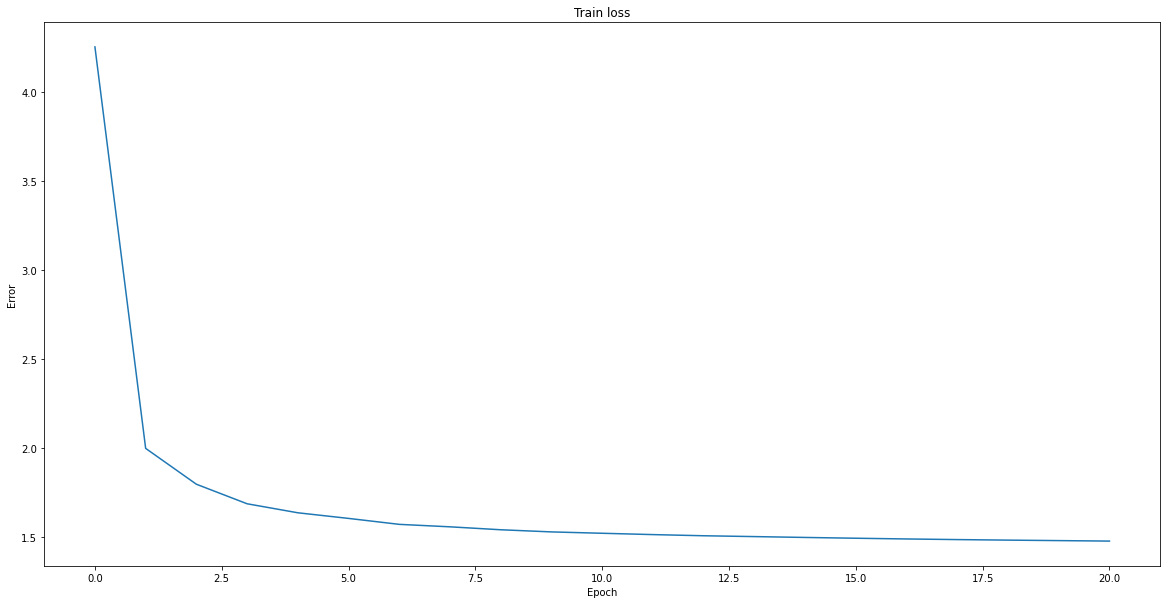

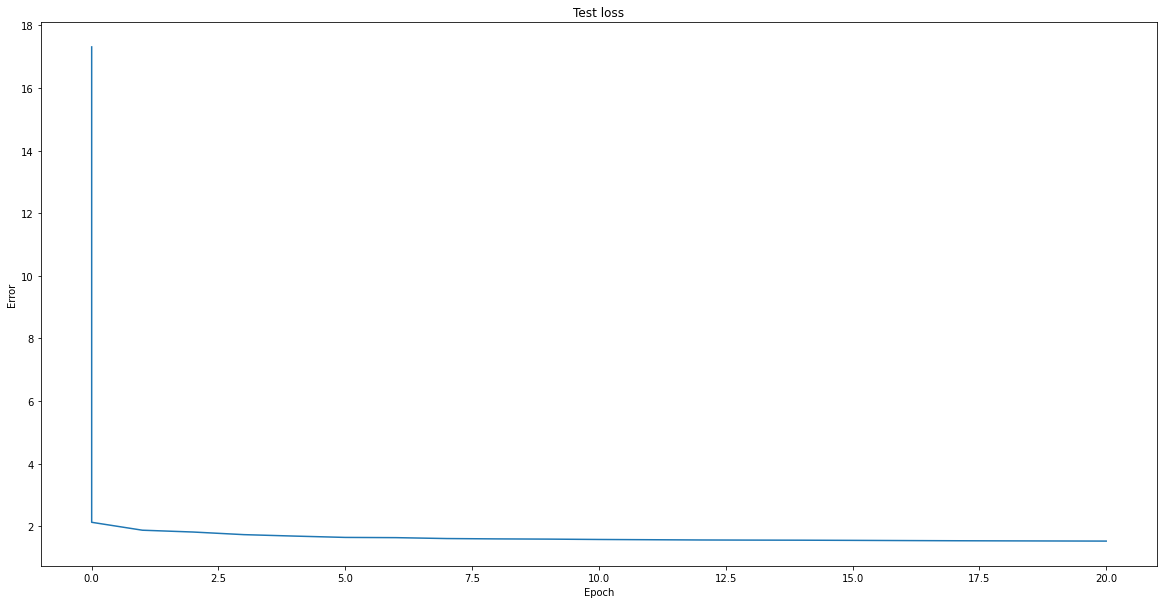

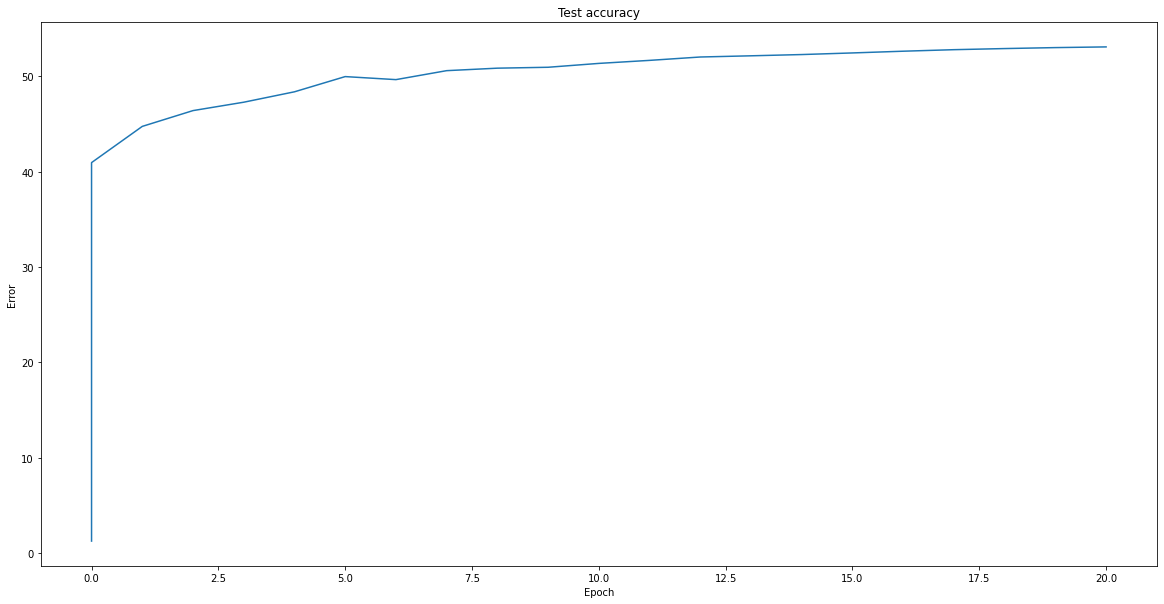

In [13]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pk1'


    data_train = HarryPotterDataset(DATA_PATH + 'Shakespeare_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'Shakespeare_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints0')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'So shaken as we are, so wan with care,'
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

In [14]:
def eval_final_model(model, vocab, device):
    seed_words = "So shaken as we are"
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 So shaken as we are all the death." "Where is the death of men that he were a sun and son" "That that the deed of his constance, and the reason" "That the deed of his constant and that the death" "And that the deed of h
generated with sample	 So shaken as we are a coll'd by him!" "With vir disposes up a horr'd and blodwed" "Most indinited, Remfort, as on your offenving!" "And thank of yourselves yours" "Toocly makes me have blinger on the further's sack," "T
generated with sample	 So shaken as we are with grief," "Who world had been thready and his that" "makes your signious long'd quit to ed." "Fring his through surponier." Enter COSEOAR "Enter SARY LABERLBEE, PELOPO, and OLEN?" "My did COWORRUS
generated with sample	 So shaken as we arew put in purysing in this" "that littly budys abouth their himself knife," "in your rackful suncicious proverous God:" "Ro wimites." "I am is fortunity, caret in Englans." Ne!" "Lessiusen." "And I'I t
generated with sample	 So shake

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


generated with beam	 So shaken as we arefucted in asaid." "I shall thought a'To distance of nature to: he," "Sid in breather haven busined to rost hire in me." "OF and the crue by ow man decenseveher'd" "As drown ask'd," "Uplaid up that kee
generated with beam	 So shaken as we are you, to helpinard," "Letchingdoss'd with the deliker." "I gnew the Raughters, it desire to gone a burgue:" "As must entrrupt and with had buttoute drince." "He say, sir." "Ne'en a diefu, as we uponen
generated with beam	 So shaken as we ares." "Let him. One woeen in unbontant hour" "We before'd guive this mainity" "Wouchstand fould a deeph. yet up not, sore, the fulking of" "For thy silbern haw to be townight torand," "Will since die ca
generated with beam	 So shaken as we aren." "Exter: Noverom? "And Get to,-IO Leter CERVASRE and FrombAs" "He stonest that we make is nothing:" "And so deforty, he benchey known to know." "Sham, ass, means the reveruslot man, so" "On hadranc
generated with beam	 So shaken as we

1. New Corpus
 1. Chose the Shakespeare's play, it has 4583798 characters
 2. The new corpus more likely generate small sentence with quote, and the sentence is very simple.
 3. The temperature is 0.5, the outputs are shown above
**max:**	 So shaken as we are all the death." "Where is the death of men that he were a sun and son" "That that the deed of his constance, and the reason" "That the deed of his constant and that the death" "And that the deed of h


  **sample**	 So shaken as we are son." "Loor, on heavens sin." "Here Pontune, fortural the master adsiac?" "Sives aponta, at thought, knive, that one gots welk" us," "Seceing cryinnut ma knee. S'peace, make deead," "Within thou are 


   **beam:**	 So shaken as we are youth." "Shough id they thank you mee?" "That office, do now, nother was," "The better have letter verought:" "K5sice should I crubt him with toy." Behen setch libstorum." "Exeunt "See-sure, that's a





**3. LSTM**

In [19]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/hw2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [20]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        embedded = self.encoder(x).view(batch_size,sequence_length,self.feature_size)
        output, (hn,cn) = self.lstm(embedded, hidden_state)
        output = self.decoder(output)
        return output, (hn,cn)

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	;64Ado;;(6A;;;;;;z:vzT;;6dd-;-; AA;p;5zVV; v39cn.(;;y7 cv8666nnAA;;;-;LN.l}-eo; }8]]c;;(::l;;8-;;;;


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	};;z;; AA;}:oz:;;;5z:;;;;; ;]]];;A.UAp;l::T9zT.8:;V];e;(-^$vvAA;(pa;;zEsdoz:;VAvov;^r9.P; AA;pVVVi_


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	BzN(-6;;;;;;;(JJJ-d;(-;vAA;n(iT.:;.I; AA;;;]8;A(6A;!oVVzA7(-;;16;6z:;zANV18;}vE;A.88(l9z;G8y:--v ;]


Input	help, but the

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 8.8244, Accuracy: 6982/1254400 (1%)



  1%|          | 1/195 [00:00<00:36,  5.25it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 8.850785


  7%|▋         | 13/195 [00:00<00:13, 13.22it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 4.957558


 12%|█▏        | 23/195 [00:01<00:10, 15.66it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 2.898580


 17%|█▋        | 33/195 [00:02<00:10, 16.11it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 2.307135


 22%|██▏       | 43/195 [00:02<00:09, 16.42it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 2.131714


 27%|██▋       | 53/195 [00:03<00:08, 15.98it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 2.015485


 32%|███▏      | 63/195 [00:04<00:08, 16.37it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 1.976903


 37%|███▋      | 73/195 [00:04<00:07, 16.73it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 1.917064


 43%|████▎     | 83/195 [00:05<00:06, 16.48it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 1.882030


 48%|████▊     | 93/195 [00:05<00:06, 16.49it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 1.856871


 53%|█████▎    | 103/195 [00:06<00:05, 16.52it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 1.833931


 58%|█████▊    | 113/195 [00:07<00:04, 16.48it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 1.798750


 63%|██████▎   | 123/195 [00:07<00:04, 16.51it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 1.800882


 68%|██████▊   | 133/195 [00:08<00:03, 16.33it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 1.789295


 73%|███████▎  | 143/195 [00:08<00:03, 16.26it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 1.769233


 78%|███████▊  | 153/195 [00:09<00:02, 16.60it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 1.738666


 84%|████████▎ | 163/195 [00:10<00:01, 16.76it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 1.718047


 89%|████████▊ | 173/195 [00:10<00:01, 16.69it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 1.705664


 94%|█████████▍| 183/195 [00:11<00:00, 16.38it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 1.676405


 99%|█████████▉| 193/195 [00:11<00:00, 16.60it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 1.677880


100%|██████████| 195/195 [00:12<00:00, 16.24it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeaththdhtttd tias d ttain   the sane yothsk  "I sn tarti .  "e said  "Aon't taudy  wade  said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the sft r tone  and tarry aa d d tumbledore teck an o the snk ttet yed thet torl d the saoaele


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	er ng ttd teedpeng tn the sagdee tf the soyk aashttnaaem an tagw ent d "ir tf  tewridle torent tarr


Input	help, but there was nobody to be seen and all 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Flead, and whispely bee wildn's Madmanks no, Quidd," "Did ity is Siviny tely andam?" Hall that will of the who call he strything belling a Ron the ston's it. Hagrid's int was elff Mseceh Siver, unus t



  1%|          | 1/195 [00:00<00:29,  6.60it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 1.681864


  7%|▋         | 13/195 [00:00<00:12, 14.12it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 1.674597


 12%|█▏        | 23/195 [00:01<00:11, 15.55it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 1.658711


 17%|█▋        | 33/195 [00:02<00:09, 16.53it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 1.655745


 22%|██▏       | 43/195 [00:02<00:09, 16.73it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 1.631068


 27%|██▋       | 53/195 [00:03<00:08, 16.33it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 1.614586


 32%|███▏      | 63/195 [00:03<00:08, 16.18it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 1.617947


 37%|███▋      | 73/195 [00:04<00:07, 16.12it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 1.603681


 43%|████▎     | 83/195 [00:05<00:07, 15.94it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 1.588914


 48%|████▊     | 93/195 [00:05<00:06, 16.26it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 1.587693


 53%|█████▎    | 103/195 [00:06<00:05, 16.35it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 1.588642


 58%|█████▊    | 113/195 [00:06<00:05, 16.34it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 1.566807


 63%|██████▎   | 123/195 [00:07<00:04, 16.24it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 1.570274


 68%|██████▊   | 133/195 [00:08<00:03, 16.19it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 1.579267


 73%|███████▎  | 143/195 [00:08<00:03, 16.33it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 1.570581


 78%|███████▊  | 153/195 [00:09<00:02, 16.43it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 1.544500


 84%|████████▎ | 163/195 [00:10<00:01, 16.02it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 1.532322


 89%|████████▊ | 173/195 [00:10<00:01, 16.45it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 1.533931


 94%|█████████▍| 183/195 [00:11<00:00, 16.45it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 1.513137


 99%|█████████▉| 193/195 [00:11<00:00, 16.63it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 1.523577


100%|██████████| 195/195 [00:11<00:00, 16.25it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	tooat tignttnd soar d tnain,t the sone yoahsl  "I tn tarr  .  "e said  "Ion't sauky  whdt  said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uee  the snt s tone  and sarry saap d tumbledore teck tn o the snk aeer yed thet honl d the sooaene


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng tnd soonpeng tn the sogdle of the sork aashttnuuet an tagwmeane  "or tf  oewrible aorent oarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . I chapes and get the onter, who was gain as now, the wanto the Enectments to plandly Slughorn's he pinking or vago, and the stage very part in of hergoung, didn't bed down her my eye. "Yeah," said D



  1%|          | 1/195 [00:00<00:38,  5.08it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 1.531311


  7%|▋         | 13/195 [00:00<00:13, 13.13it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 1.528330


 12%|█▏        | 23/195 [00:01<00:10, 15.79it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 1.520071


 17%|█▋        | 33/195 [00:02<00:09, 16.39it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 1.524275


 22%|██▏       | 43/195 [00:02<00:09, 16.66it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 1.519348


 27%|██▋       | 53/195 [00:03<00:08, 16.30it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 1.500296


 32%|███▏      | 63/195 [00:03<00:08, 16.29it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 1.507255


 37%|███▋      | 73/195 [00:04<00:07, 16.63it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 1.494432


 43%|████▎     | 83/195 [00:05<00:06, 16.43it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 1.484512


 48%|████▊     | 93/195 [00:05<00:06, 16.50it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 1.489956


 53%|█████▎    | 103/195 [00:06<00:05, 16.32it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 1.491135


 58%|█████▊    | 113/195 [00:06<00:05, 16.23it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 1.503038


 63%|██████▎   | 123/195 [00:07<00:04, 16.69it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 1.488843


 68%|██████▊   | 133/195 [00:08<00:03, 16.76it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 1.500710


 73%|███████▎  | 143/195 [00:08<00:03, 16.25it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 1.484209


 78%|███████▊  | 153/195 [00:09<00:02, 16.46it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 1.467748


 84%|████████▎ | 163/195 [00:10<00:01, 16.55it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 1.463029


 89%|████████▊ | 173/195 [00:10<00:01, 16.22it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 1.460783


 94%|█████████▍| 183/195 [00:11<00:00, 16.32it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 1.441897


 99%|█████████▉| 193/195 [00:11<00:00, 16.27it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 1.462137


100%|██████████| 195/195 [00:12<00:00, 16.25it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	treat tugnttnd soav d tnain,t the srre yaahsk  "I tl thrr  .  "e said  "Ion't wanky  thd,  said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueid the snt r oore  and terry saap d tumbledore seck tn o the snk oier led thet honl d the croaeoi


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng hnd toenpeng hn the fogdle of the cork aagh tnuuet an tagwmeade  "or tf  oerrible aorent oarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. quite and ignape, sure the Vermact, the your eye, is honot. The harm and where spect, laughed charlie," she said closel, robes after the sleep unear in theirr's long a glearning, sinking." "Alenboman 



  1%|          | 1/195 [00:00<00:28,  6.81it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 1.471912


  7%|▋         | 13/195 [00:00<00:12, 14.27it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 1.464533


 12%|█▏        | 23/195 [00:01<00:10, 15.93it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 1.452227


 17%|█▋        | 33/195 [00:02<00:10, 16.15it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 1.461928


 22%|██▏       | 43/195 [00:02<00:09, 16.70it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 1.456562


 27%|██▋       | 53/195 [00:03<00:08, 16.67it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 1.450987


 32%|███▏      | 63/195 [00:03<00:07, 16.55it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 1.476103


 37%|███▋      | 73/195 [00:04<00:07, 16.30it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 1.449781


 43%|████▎     | 83/195 [00:05<00:06, 16.21it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 1.429515


 48%|████▊     | 93/195 [00:05<00:06, 16.32it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 1.438033


 53%|█████▎    | 103/195 [00:06<00:05, 16.47it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 1.442750


 58%|█████▊    | 113/195 [00:06<00:04, 16.43it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 1.429785


 63%|██████▎   | 123/195 [00:07<00:04, 16.36it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 1.443767


 68%|██████▊   | 133/195 [00:08<00:03, 16.08it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 1.470235


 73%|███████▎  | 143/195 [00:08<00:03, 16.40it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 1.449364


 78%|███████▊  | 153/195 [00:09<00:02, 16.64it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 1.437328


 84%|████████▎ | 163/195 [00:10<00:01, 16.33it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 1.426754


 89%|████████▊ | 173/195 [00:10<00:01, 16.08it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 1.419004


 94%|█████████▍| 183/195 [00:11<00:00, 16.32it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 1.408898


 99%|█████████▉| 193/195 [00:11<00:00, 16.49it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 1.428810


100%|██████████| 195/195 [00:11<00:00, 16.25it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat aolnttnd seaded tnain,t the sare  aahsk  "I tn thrr  .  "e said  "Ion't wauky  tot," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the stt s oore  and terry saad d tumbledore seck tn o the snk oter yed thet tonl d ooe caoaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng and seenpeng hn the cogdle of the cerk aagh tnuuet an tagwmeade  "or tfe oerrible aorent oarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. He has not guite an' the ne,r one ourd teats of flying out. "Bett my when the hat's faved abve allowd and feirr which denzel; it head. Harry delieves and Ron, Potter of Alustanamed ALUAVNC As, usual c



  1%|          | 1/195 [00:00<00:27,  7.08it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 1.433741


  7%|▋         | 13/195 [00:00<00:12, 14.08it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 1.428446


 12%|█▏        | 23/195 [00:01<00:10, 15.75it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 1.422152


 17%|█▋        | 33/195 [00:02<00:09, 16.36it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 1.427266


 22%|██▏       | 43/195 [00:02<00:09, 16.18it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 1.438867


 27%|██▋       | 53/195 [00:03<00:08, 16.35it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 1.414620


 32%|███▏      | 63/195 [00:03<00:08, 16.44it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 1.420742


 37%|███▋      | 73/195 [00:04<00:07, 16.66it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 1.405094


 43%|████▎     | 83/195 [00:05<00:06, 16.67it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 1.398207


 48%|████▊     | 93/195 [00:05<00:06, 16.43it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 1.412080


 53%|█████▎    | 103/195 [00:06<00:05, 16.36it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 1.410148


 58%|█████▊    | 113/195 [00:06<00:05, 15.96it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 1.403316


 63%|██████▎   | 123/195 [00:07<00:04, 16.27it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 1.433644


 68%|██████▊   | 133/195 [00:08<00:03, 16.28it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 1.444739


 73%|███████▎  | 143/195 [00:08<00:03, 16.55it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 1.415084


 78%|███████▊  | 153/195 [00:09<00:02, 16.26it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 1.407930


 84%|████████▎ | 163/195 [00:10<00:01, 16.47it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 1.400145


 89%|████████▊ | 173/195 [00:10<00:01, 16.54it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 1.395342


 94%|█████████▍| 183/195 [00:11<00:00, 16.40it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 1.386863


 99%|█████████▉| 193/195 [00:11<00:00, 16.54it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 1.415868


100%|██████████| 195/195 [00:12<00:00, 16.25it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat solntand soaved tnain.t the sare   aisk  "I dl shrr  .  "e said  "Ion't wauky  Iol," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the snt s oole  and sarry saad d aumbledore seck anto the snk oinr ysd thet honl d ohe saoaeoa


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng and seonpeng hn hhe siddle of the sork oagh hnuuet an tagwmeade  "or sfe oerrible aorent oarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Somer!" "He's hear and - just before again?" "I-p I kill moy, linky iminot, can't you would all have to do have thereq," said Duplar Trelawaways, and fleby. Doin'ly ask, staf about his thought, but g



  1%|          | 1/195 [00:00<00:28,  6.70it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 1.415853


  7%|▋         | 13/195 [00:00<00:12, 14.12it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 1.405275


 12%|█▏        | 23/195 [00:01<00:10, 15.84it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 1.411786


 17%|█▋        | 33/195 [00:02<00:09, 16.49it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 1.414438


 22%|██▏       | 43/195 [00:02<00:09, 16.61it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 1.401416


 27%|██▋       | 53/195 [00:03<00:08, 16.21it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 1.391983


 32%|███▏      | 63/195 [00:03<00:08, 16.29it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 1.414145


 37%|███▋      | 73/195 [00:04<00:07, 16.63it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 1.393709


 43%|████▎     | 83/195 [00:05<00:06, 16.43it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 1.376937


 48%|████▊     | 93/195 [00:05<00:06, 16.66it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 1.391325


 53%|█████▎    | 103/195 [00:06<00:05, 16.50it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 1.394408


 58%|█████▊    | 113/195 [00:06<00:05, 16.32it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 1.389387


 63%|██████▎   | 123/195 [00:07<00:04, 16.36it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 1.399792


 68%|██████▊   | 133/195 [00:08<00:03, 16.58it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 1.414010


 73%|███████▎  | 143/195 [00:08<00:03, 16.73it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 1.405135


 78%|███████▊  | 153/195 [00:09<00:02, 16.39it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 1.394191


 84%|████████▎ | 163/195 [00:10<00:01, 16.15it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 1.396364


 89%|████████▊ | 173/195 [00:10<00:01, 16.16it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 1.384181


 94%|█████████▍| 183/195 [00:11<00:00, 16.75it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 1.371898


 99%|█████████▉| 193/195 [00:11<00:00, 16.37it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 1.393605


100%|██████████| 195/195 [00:11<00:00, 16.30it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat solntand soavid tnain.t the sare   oisk  "I dm sh r  .  "e said  "Ion't waury  tol," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the snr r oore  and sarry saad d tumbledore sack tn o the snk oiat ysr than honl d the saoaeol


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng and soanpeng hn hhe siddle of the cork oagh anuuet an aagwmeade  "or tf  oewrible torent oarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Slughorn happpoing and Ron. "It be some pyfing the don't get last and swiggled to spart the down obs, Mr. Banged boy them eckted this wining... His good under are Charsleys les, it what hows you. Harr



  1%|          | 1/195 [00:00<00:27,  7.04it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 1.408506


  7%|▋         | 13/195 [00:00<00:12, 14.27it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 1.399326


 12%|█▏        | 23/195 [00:01<00:10, 16.00it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 1.393662


 17%|█▋        | 33/195 [00:02<00:09, 16.61it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 1.399768


 22%|██▏       | 43/195 [00:02<00:09, 16.28it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 1.394325


 27%|██▋       | 53/195 [00:03<00:08, 16.32it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 1.399173


 32%|███▏      | 63/195 [00:03<00:08, 16.44it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 1.400487


 37%|███▋      | 73/195 [00:04<00:07, 16.41it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 1.383311


 43%|████▎     | 83/195 [00:05<00:06, 16.57it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 1.368907


 48%|████▊     | 93/195 [00:05<00:06, 16.44it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 1.384259


 53%|█████▎    | 103/195 [00:06<00:05, 16.47it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 1.381694


 58%|█████▊    | 113/195 [00:06<00:04, 16.45it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 1.369486


 63%|██████▎   | 123/195 [00:07<00:04, 16.45it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 1.377605


 68%|██████▊   | 133/195 [00:08<00:03, 16.51it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 1.404649


 73%|███████▎  | 143/195 [00:08<00:03, 16.46it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 1.413524


 78%|███████▊  | 153/195 [00:09<00:02, 16.64it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 1.402326


 84%|████████▎ | 163/195 [00:09<00:01, 16.53it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 1.383660


 89%|████████▊ | 173/195 [00:10<00:01, 16.27it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 1.367421


 94%|█████████▍| 183/195 [00:11<00:00, 16.26it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 1.364242


 99%|█████████▉| 193/195 [00:11<00:00, 16.70it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 1.379164


100%|██████████| 195/195 [00:11<00:00, 16.36it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeet sulntand soavtd tnainst the sare   ohsl  "I sm se r  .  "e said  "Ion't saury  Ior,  said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the snr r oore  and sarry saaded tumbledore seck tnto the snk oeat yer than hrrl d the saoaeoh


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng tnd seenpeng hn hhe soddle of the serk oagh hnuuetean hagwmeade  "ir tfe oewrible sorent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. . Dobby got have over he?" "Dunn'll so What if Iggoen leave 'Mzair Duimsure, coming umbselfac! to seat," Harry cauldry," she wedenone bell to compace. And was rose un, and he went, sure handing - no t



  1%|          | 1/195 [00:00<00:28,  6.78it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 1.395617


  7%|▋         | 13/195 [00:00<00:12, 14.05it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 1.383237


 12%|█▏        | 23/195 [00:01<00:10, 16.01it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 1.382351


 17%|█▋        | 33/195 [00:02<00:09, 16.24it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 1.390538


 22%|██▏       | 43/195 [00:02<00:09, 16.29it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 1.389835


 27%|██▋       | 53/195 [00:03<00:08, 16.46it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 1.367993


 32%|███▏      | 63/195 [00:03<00:08, 16.46it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 1.391016


 37%|███▋      | 73/195 [00:04<00:07, 16.72it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 1.374846


 43%|████▎     | 83/195 [00:05<00:06, 16.45it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 1.360875


 48%|████▊     | 93/195 [00:05<00:06, 16.63it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 1.378809


 53%|█████▎    | 103/195 [00:06<00:05, 16.89it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 1.380538


 58%|█████▊    | 113/195 [00:06<00:04, 16.65it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 1.388992


 63%|██████▎   | 123/195 [00:07<00:04, 15.94it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 1.407827


 68%|██████▊   | 133/195 [00:08<00:03, 16.20it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 1.400465


 73%|███████▎  | 143/195 [00:08<00:03, 16.60it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 1.384425


 78%|███████▊  | 153/195 [00:09<00:02, 16.22it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 1.381977


 84%|████████▎ | 163/195 [00:09<00:01, 16.04it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 1.365768


 89%|████████▊ | 173/195 [00:10<00:01, 16.15it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 1.367175


 94%|█████████▍| 183/195 [00:11<00:00, 16.44it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 1.353972


 99%|█████████▉| 193/195 [00:11<00:00, 16.75it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 1.374125


100%|██████████| 195/195 [00:11<00:00, 16.32it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeet sulntond soavid tnainst the sare soohsl  "I wm serr, .  "e said  "Ion't waury  aor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the str r oore  and sarry saaded tumbledore teck tnto the cnk oeat yer ahan horled the sooaeoh


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng and seenpeng hn ahe coddle of the cork oaghtwnuuetean aagwmeade  "ir tfe oewrible torent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Geat?" "Therews your nosing." "Deeys heated brotten can lest it on,. I've don't in ald to need if your can all for that them year, Infurish Ron's had need torror yurk. I two around the Harch wrotes o



  1%|          | 1/195 [00:00<00:27,  7.00it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 1.384717


  7%|▋         | 13/195 [00:00<00:12, 14.24it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 1.385090


 12%|█▏        | 23/195 [00:01<00:10, 16.15it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 1.385818


 17%|█▋        | 33/195 [00:02<00:09, 16.28it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 1.389259


 22%|██▏       | 43/195 [00:02<00:09, 16.36it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 1.387551


 27%|██▋       | 53/195 [00:03<00:08, 16.50it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 1.371386


 32%|███▏      | 63/195 [00:03<00:08, 16.10it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 1.378498


 37%|███▋      | 73/195 [00:04<00:07, 16.63it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 1.364002


 43%|████▎     | 83/195 [00:05<00:06, 16.22it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 1.353169


 48%|████▊     | 93/195 [00:05<00:06, 16.16it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 1.365563


 53%|█████▎    | 103/195 [00:06<00:05, 16.21it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 1.374737


 58%|█████▊    | 113/195 [00:06<00:05, 16.38it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 1.350268


 63%|██████▎   | 123/195 [00:07<00:04, 16.78it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 1.368290


 68%|██████▊   | 133/195 [00:08<00:03, 16.43it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 1.390666


 73%|███████▎  | 143/195 [00:08<00:03, 16.06it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 1.373592


 78%|███████▊  | 153/195 [00:09<00:02, 16.84it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 1.382378


 84%|████████▎ | 163/195 [00:09<00:01, 16.63it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 1.377284


 89%|████████▊ | 173/195 [00:10<00:01, 16.15it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 1.370028


 94%|█████████▍| 183/195 [00:11<00:00, 16.77it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 1.350812


 99%|█████████▉| 193/195 [00:11<00:00, 16.79it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 1.361097


100%|██████████| 195/195 [00:11<00:00, 16.34it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeet sulntond soavid ttain.t the care  oohsl  "I wm sarri .  "e said, "Ion't warry  tor," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the btr r oore  and tarry waaded tumbledore teck tnto the cnk otar yer than horl d the caoaenh


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng ttd soanpeng tn hhe caddle of the cork oaghtwnuuenean hagwmeade  "ir tfe oeurible terent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Loddenichered unhams to be newred gupping. 'I thought I and then was weaving unack, the surb?" "But you," said Fings hooded it, but and Every sat down wand. Gell rather he would was are not one of the



  1%|          | 1/195 [00:00<00:27,  7.03it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 1.377356


  7%|▋         | 13/195 [00:00<00:12, 14.26it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 1.375751


 12%|█▏        | 23/195 [00:01<00:10, 16.31it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 1.373741


 17%|█▋        | 33/195 [00:02<00:09, 16.62it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 1.391178


 22%|██▏       | 43/195 [00:02<00:09, 16.32it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 1.368320


 27%|██▋       | 53/195 [00:03<00:08, 16.47it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 1.352338


 32%|███▏      | 63/195 [00:03<00:08, 16.45it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 1.373482


 37%|███▋      | 73/195 [00:04<00:07, 16.53it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 1.362571


 43%|████▎     | 83/195 [00:05<00:06, 16.31it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 1.346690


 48%|████▊     | 93/195 [00:05<00:06, 16.79it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 1.362370


 53%|█████▎    | 103/195 [00:06<00:05, 16.54it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 1.371061


 58%|█████▊    | 113/195 [00:06<00:05, 16.34it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 1.355524


 63%|██████▎   | 123/195 [00:07<00:04, 16.17it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 1.365261


 68%|██████▊   | 133/195 [00:08<00:03, 16.55it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 1.382832


 73%|███████▎  | 143/195 [00:08<00:03, 16.38it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 1.374045


 78%|███████▊  | 153/195 [00:09<00:02, 16.41it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 1.374400


 84%|████████▎ | 163/195 [00:09<00:01, 16.36it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 1.363949


 89%|████████▊ | 173/195 [00:10<00:01, 16.49it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 1.361469


 94%|█████████▍| 183/195 [00:11<00:00, 16.78it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 1.345415


 99%|█████████▉| 193/195 [00:11<00:00, 16.63it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 1.357302


100%|██████████| 195/195 [00:11<00:00, 16.34it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond soavid tnain.t the care  oohsl  "I wm sarri .  "e said, "Iun't waury  Ior," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the stt r oore  and tarry waaded tumbledore teck tnto the cnk otarnyir ahan horl d the sooaenh


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng and saanpeng hn hhe caddle of the cork oagh anueen an aagwmeade  "ir tfe oeurible tarent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. They' saved likhed instairs ." "Hermione'lly, sharp Perfeys own, of Sour--" The walf of Hagrid's planted to kunch the portrain off, panking her open crowded out for the book and Lagben he qumped oully



  1%|          | 1/195 [00:00<00:27,  7.17it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 1.371156


  7%|▋         | 13/195 [00:00<00:12, 14.41it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 1.369289


 12%|█▏        | 23/195 [00:01<00:10, 16.16it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 1.368028


 17%|█▋        | 33/195 [00:02<00:09, 16.59it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 1.374774


 22%|██▏       | 43/195 [00:02<00:09, 16.48it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 1.369800


 27%|██▋       | 53/195 [00:03<00:08, 16.36it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 1.345527


 32%|███▏      | 63/195 [00:03<00:08, 16.48it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 1.359260


 37%|███▋      | 73/195 [00:04<00:07, 16.56it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 1.359391


 43%|████▎     | 83/195 [00:05<00:06, 16.49it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 1.342593


 48%|████▊     | 93/195 [00:05<00:06, 16.21it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 1.356746


 53%|█████▎    | 103/195 [00:06<00:05, 16.27it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 1.366530


 58%|█████▊    | 113/195 [00:06<00:05, 16.28it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 1.347085


 63%|██████▎   | 123/195 [00:07<00:04, 16.62it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 1.354321


 68%|██████▊   | 133/195 [00:08<00:03, 16.25it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 1.378670


 73%|███████▎  | 143/195 [00:08<00:03, 16.28it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 1.367251


 78%|███████▊  | 153/195 [00:09<00:02, 16.20it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 1.364434


 84%|████████▎ | 163/195 [00:10<00:01, 16.42it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 1.351111


 89%|████████▊ | 173/195 [00:10<00:01, 16.16it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 1.351319


 94%|█████████▍| 183/195 [00:11<00:00, 16.47it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 1.338361


 99%|█████████▉| 193/195 [00:11<00:00, 16.54it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 1.352079


100%|██████████| 195/195 [00:11<00:00, 16.29it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond soavid tnain,t the fare  oohsl  "I wm sorri .  "e said, "Iun't warry  Ior," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the stt r oore  and sarry waaded humbledore teck tnto the cnk otarnyir ahan horl d the sooaenh


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng and soanpeng hn the coddle of the cark wagh anueen an tagwmeade  "or tfe oalrible tarent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. They had curied in fron, hopening, he could have been branky." Harry started at him. Mind Harry will do want thatx?" said Ron said, people out alsed to horse unirnovens how twhis, there'lone was a pat



  1%|          | 1/195 [00:00<00:29,  6.56it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 1.368398


  7%|▋         | 13/195 [00:00<00:13, 13.98it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 1.369101


 12%|█▏        | 23/195 [00:01<00:10, 16.06it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 1.377244


 17%|█▋        | 33/195 [00:02<00:09, 16.66it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 1.371212


 22%|██▏       | 43/195 [00:02<00:09, 16.59it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 1.358507


 27%|██▋       | 53/195 [00:03<00:08, 16.37it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 1.337186


 32%|███▏      | 63/195 [00:03<00:07, 16.55it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 1.354191


 37%|███▋      | 73/195 [00:04<00:07, 16.28it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 1.352788


 43%|████▎     | 83/195 [00:05<00:06, 16.07it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 1.337988


 48%|████▊     | 93/195 [00:05<00:06, 16.41it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 1.352930


 53%|█████▎    | 103/195 [00:06<00:05, 16.35it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 1.362792


 58%|█████▊    | 113/195 [00:06<00:05, 16.34it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 1.339472


 63%|██████▎   | 123/195 [00:07<00:04, 16.18it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 1.356366


 68%|██████▊   | 133/195 [00:08<00:03, 16.30it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 1.371126


 73%|███████▎  | 143/195 [00:08<00:03, 16.61it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 1.368521


 78%|███████▊  | 153/195 [00:09<00:02, 16.29it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 1.356642


 84%|████████▎ | 163/195 [00:10<00:01, 16.13it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 1.347741


 89%|████████▊ | 173/195 [00:10<00:01, 16.24it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 1.346960


 94%|█████████▍| 183/195 [00:11<00:00, 16.55it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 1.337054


 99%|█████████▉| 193/195 [00:11<00:00, 16.56it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 1.349692


100%|██████████| 195/195 [00:12<00:00, 16.25it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond soavid tnain,t the core  oohsl  "I wm aarri .  "e said, "Iun't warry "Ior," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the stt r oore  and sarry waaded humbledore weck tnto the cnk otarnyer ahan horl d the sooaenh


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng and soanpeng tn the coddle of the cork wagh anueen an tagwmeade  "or tfe oewrible tarent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron dow. . . "Aup," said Dulder, "I'm s," and treed blipthle, her echopid owner, indicanting to run ide. Nalfoy barried sounning. "You perbused how to though!" said Harry, aht a though, how and he loo



  1%|          | 1/195 [00:00<00:29,  6.66it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 1.362619


  7%|▋         | 13/195 [00:00<00:12, 14.02it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 1.360491


 12%|█▏        | 23/195 [00:01<00:10, 16.00it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 1.358584


 17%|█▋        | 33/195 [00:02<00:09, 16.48it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 1.367556


 22%|██▏       | 43/195 [00:02<00:09, 16.63it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 1.353680


 27%|██▋       | 53/195 [00:03<00:08, 16.27it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 1.351708


 32%|███▏      | 63/195 [00:03<00:08, 16.35it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 1.366542


 37%|███▋      | 73/195 [00:04<00:07, 16.28it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 1.347168


 43%|████▎     | 83/195 [00:05<00:06, 16.54it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 1.337531


 48%|████▊     | 93/195 [00:05<00:06, 16.18it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 1.345836


 53%|█████▎    | 103/195 [00:06<00:05, 16.42it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 1.353448


 58%|█████▊    | 113/195 [00:06<00:04, 16.74it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 1.337095


 63%|██████▎   | 123/195 [00:07<00:04, 16.77it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 1.354157


 68%|██████▊   | 133/195 [00:08<00:03, 16.62it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 1.370356


 73%|███████▎  | 143/195 [00:08<00:03, 16.81it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 1.360693


 78%|███████▊  | 153/195 [00:09<00:02, 16.54it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 1.355842


 84%|████████▎ | 163/195 [00:09<00:01, 16.14it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 1.340181


 89%|████████▊ | 173/195 [00:10<00:01, 16.35it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 1.342454


 94%|█████████▍| 183/195 [00:11<00:00, 16.51it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 1.333996


 99%|█████████▉| 193/195 [00:11<00:00, 16.61it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 1.346058


100%|██████████| 195/195 [00:11<00:00, 16.33it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond seaved tnainst the fore  oohsl  "I wm sarr, .  "e said  "Iuu't warry  Ior,  said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the stt r oore  and tarry waaded humbledore weck tn o the cnk oear yer aoat horl d the cooaene


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ereng and soenpeng tn the coddle of the cork aagh anueen an tagwteade  "ir tf  oelrible serent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Harry was remiling. "I better in yet bowider, he didn't fom thinkne, like your onest of your morned yessed cage up the fire to goin' your rebelkand, two ChOter how well trold your what Pranger have be



  1%|          | 1/195 [00:00<00:29,  6.67it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 1.361505


  7%|▋         | 13/195 [00:00<00:12, 14.03it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 1.349326


 12%|█▏        | 23/195 [00:01<00:10, 16.09it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 1.353962


 17%|█▋        | 33/195 [00:02<00:09, 16.35it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 1.362976


 22%|██▏       | 43/195 [00:02<00:09, 16.44it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 1.358269


 27%|██▋       | 53/195 [00:03<00:08, 16.08it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 1.332668


 32%|███▏      | 63/195 [00:03<00:07, 16.61it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 1.348393


 37%|███▋      | 73/195 [00:04<00:07, 16.32it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 1.342347


 43%|████▎     | 83/195 [00:05<00:06, 16.28it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 1.327716


 48%|████▊     | 93/195 [00:05<00:06, 16.33it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 1.340005


 53%|█████▎    | 103/195 [00:06<00:05, 16.30it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 1.354378


 58%|█████▊    | 113/195 [00:06<00:05, 16.20it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 1.331701


 63%|██████▎   | 123/195 [00:07<00:04, 16.35it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 1.348654


 68%|██████▊   | 133/195 [00:08<00:03, 16.15it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 1.358847


 73%|███████▎  | 143/195 [00:08<00:03, 16.00it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 1.358306


 78%|███████▊  | 153/195 [00:09<00:02, 16.28it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 1.351718


 84%|████████▎ | 163/195 [00:10<00:01, 16.46it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 1.342792


 89%|████████▊ | 173/195 [00:10<00:01, 16.34it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 1.336051


 94%|█████████▍| 183/195 [00:11<00:00, 16.23it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 1.326275


 99%|█████████▉| 193/195 [00:11<00:00, 16.54it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 1.341105


100%|██████████| 195/195 [00:12<00:00, 16.20it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond seaved onainst the fare aoohsl  "I wm aarri .  "e said, "Iun't warry  Ior," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the stt r oore  and tarry waaded humbledore weck tn o the cnk otarnyer ahat horled the cooaene


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eneng and saenpeng tn the candle of the cark aagh anaeen an tagwteade  "ir tf  oelrible serent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ron mothers with make smilet to suppose minute peessly name taking him. He shugges hold on Weasleys, after the wailed: 'Her persping water, how dean stroud, to have had ciraged mivair. Harry streped m



  1%|          | 1/195 [00:00<00:27,  6.99it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 1.355087


  7%|▋         | 13/195 [00:00<00:12, 14.16it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 1.349145


 12%|█▏        | 23/195 [00:01<00:10, 15.89it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 1.352255


 17%|█▋        | 33/195 [00:02<00:09, 16.47it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 1.356882


 22%|██▏       | 43/195 [00:02<00:09, 16.65it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 1.344573


 27%|██▋       | 53/195 [00:03<00:08, 16.55it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 1.328406


 32%|███▏      | 63/195 [00:03<00:08, 16.25it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 1.342257


 37%|███▋      | 73/195 [00:04<00:07, 16.49it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 1.342268


 43%|████▎     | 83/195 [00:05<00:06, 16.43it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 1.328096


 48%|████▊     | 93/195 [00:05<00:06, 16.56it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 1.335755


 53%|█████▎    | 103/195 [00:06<00:05, 16.20it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 1.350055


 58%|█████▊    | 113/195 [00:06<00:04, 16.66it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 1.329999


 63%|██████▎   | 123/195 [00:07<00:04, 16.20it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 1.340636


 68%|██████▊   | 133/195 [00:08<00:03, 16.39it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 1.359256


 73%|███████▎  | 143/195 [00:08<00:03, 16.46it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 1.355949


 78%|███████▊  | 153/195 [00:09<00:02, 16.26it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 1.342740


 84%|████████▎ | 163/195 [00:09<00:01, 16.36it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 1.335691


 89%|████████▊ | 173/195 [00:10<00:01, 16.30it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 1.325607


 94%|█████████▍| 183/195 [00:11<00:00, 16.44it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 1.322047


 99%|█████████▉| 193/195 [00:11<00:00, 16.30it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 1.341927


100%|██████████| 195/195 [00:11<00:00, 16.28it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond soaved onainst the core  oohsl  "I wm sarr  .  "e said  "Iun't warry  Ior,  said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the ctt r oore  and sarry waaded humbledore aeck tn o the cnk otarnyer aoat horl d the coeaene


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eneng and sianpeng tn the candle of the cark aagh anueen an tagwmeade  "or tf  oeurible sarent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Wear, Her dementors,-? Sleportar; GNATEBS. Ance -" "There you opening it, mid6y, you could hurryhour readin's con, with chearing where a sleep's what was beined vagic?" Harry said, "She entered him? 



  1%|          | 1/195 [00:00<00:28,  6.77it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 1.355619


  7%|▋         | 13/195 [00:00<00:12, 14.20it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 1.342978


 12%|█▏        | 23/195 [00:01<00:10, 15.82it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 1.346596


 17%|█▋        | 33/195 [00:02<00:10, 16.10it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 1.354149


 22%|██▏       | 43/195 [00:02<00:09, 16.47it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 1.340824


 27%|██▋       | 53/195 [00:03<00:08, 16.34it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 1.325733


 32%|███▏      | 63/195 [00:03<00:08, 16.15it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 1.343456


 37%|███▋      | 73/195 [00:04<00:07, 16.29it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 1.338777


 43%|████▎     | 83/195 [00:05<00:06, 16.69it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 1.327874


 48%|████▊     | 93/195 [00:05<00:06, 16.60it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 1.333548


 53%|█████▎    | 103/195 [00:06<00:05, 16.59it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 1.347644


 58%|█████▊    | 113/195 [00:06<00:04, 16.43it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 1.326032


 63%|██████▎   | 123/195 [00:07<00:04, 16.23it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 1.337654


 68%|██████▊   | 133/195 [00:08<00:03, 16.39it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 1.361697


 73%|███████▎  | 143/195 [00:08<00:03, 16.44it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 1.350898


 78%|███████▊  | 153/195 [00:09<00:02, 16.61it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 1.340236


 84%|████████▎ | 163/195 [00:10<00:01, 16.59it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 1.337836


 89%|████████▊ | 173/195 [00:10<00:01, 16.53it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 1.326492


 94%|█████████▍| 183/195 [00:11<00:00, 16.52it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 1.321774


 99%|█████████▉| 193/195 [00:11<00:00, 16.43it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 1.339660


100%|██████████| 195/195 [00:11<00:00, 16.31it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond soaved onainst the core  oohsl  "I wm sarr, .  "e said  "Iun't warry  Ihr,  said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the stt r oore  and tarry saaded humbledore weck in o the cnk oearnyer ahat horl d the coeaene


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eneng and sianpeng tn the candle of the cark aagh anueen an tagwmeade  "or tf  oeurible serent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Scar strent of pretendin'teve detencers. "BWy not tell an puring!" Harry can pleared still on them. "Snapey fell wither able thin in a crystafe char, who sharl by anglusing there of the perlems nare w



  1%|          | 1/195 [00:00<00:27,  7.14it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 1.355441


  7%|▋         | 13/195 [00:00<00:12, 14.33it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 1.342318


 12%|█▏        | 23/195 [00:01<00:10, 15.99it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 1.345153


 17%|█▋        | 33/195 [00:02<00:10, 16.03it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 1.353703


 22%|██▏       | 43/195 [00:02<00:09, 16.43it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 1.342631


 27%|██▋       | 53/195 [00:03<00:08, 16.01it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 1.318908


 32%|███▏      | 63/195 [00:03<00:08, 16.10it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 1.337825


 37%|███▋      | 73/195 [00:04<00:07, 16.58it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 1.333459


 43%|████▎     | 83/195 [00:05<00:06, 16.11it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 1.322532


 48%|████▊     | 93/195 [00:05<00:06, 16.58it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 1.328404


 53%|█████▎    | 103/195 [00:06<00:05, 16.82it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 1.349305


 58%|█████▊    | 113/195 [00:06<00:04, 16.53it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 1.320011


 63%|██████▎   | 123/195 [00:07<00:04, 16.59it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 1.334764


 68%|██████▊   | 133/195 [00:08<00:03, 16.75it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 1.354854


 73%|███████▎  | 143/195 [00:08<00:03, 16.48it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 1.344024


 78%|███████▊  | 153/195 [00:09<00:02, 16.21it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 1.334728


 84%|████████▎ | 163/195 [00:10<00:01, 16.14it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 1.328704


 89%|████████▊ | 173/195 [00:10<00:01, 16.20it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 1.324970


 94%|█████████▍| 183/195 [00:11<00:00, 16.66it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 1.319837


 99%|█████████▉| 193/195 [00:11<00:00, 16.51it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 1.336617


100%|██████████| 195/195 [00:11<00:00, 16.30it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat sulntond soaved onainst the care  oohsl  "I wm salr, .  "e said  "Iun't warry  Ihr," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the ctt r oore  and tarry waaded humbledore weck tn o the cnk otetnyer ahat horl d the coeaene


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eneng tnd sianpeng tn the candle of the cark aagh anueet on tagwmeade  "ir tf  oeurible sement tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "Harry, what he've needing to Hatch Chrir'! (as really will go in greeedy house," and he mighed heard a very hand sat,seeen front door already from the backment, on. It have hat been manzed her weld. 



  1%|          | 1/195 [00:00<00:28,  6.77it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 1.352635


  7%|▋         | 13/195 [00:00<00:12, 14.01it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 1.340683


 12%|█▏        | 23/195 [00:01<00:10, 15.86it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 1.350806


 17%|█▋        | 33/195 [00:02<00:09, 16.37it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 1.353384


 22%|██▏       | 43/195 [00:02<00:09, 16.33it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 1.336164


 27%|██▋       | 53/195 [00:03<00:08, 16.53it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 1.317090


 32%|███▏      | 63/195 [00:03<00:08, 16.27it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 1.333708


 37%|███▋      | 73/195 [00:04<00:07, 16.03it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 1.330459


 43%|████▎     | 83/195 [00:05<00:06, 16.50it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 1.318894


 48%|████▊     | 93/195 [00:05<00:06, 16.33it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 1.324947


 53%|█████▎    | 103/195 [00:06<00:05, 16.26it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 1.341617


 58%|█████▊    | 113/195 [00:06<00:05, 16.36it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 1.321940


 63%|██████▎   | 123/195 [00:07<00:04, 16.27it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 1.335848


 68%|██████▊   | 133/195 [00:08<00:03, 16.62it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 1.345695


 73%|███████▎  | 143/195 [00:08<00:03, 16.37it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 1.348513


 78%|███████▊  | 153/195 [00:09<00:02, 16.39it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 1.335926


 84%|████████▎ | 163/195 [00:10<00:01, 16.41it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 1.318520


 89%|████████▊ | 173/195 [00:10<00:01, 16.76it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 1.322207


 94%|█████████▍| 183/195 [00:11<00:00, 16.04it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 1.316737


 99%|█████████▉| 193/195 [00:11<00:00, 16.66it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 1.336460


100%|██████████| 195/195 [00:11<00:00, 16.27it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat dulntond soaved atainst the care aoahll  "I wm aalri .  "e said  "Iun't warry  Ior," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the ctt r oore  and tarry saaded humbledore aeck tn o the cnk oeetnyer ahat torl d the caeaene


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eneng atd saanpeng tn the caddle of the cark aagh anaeet an tagwmeade  "ir tfe oeurible sarent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. "K don't don't do but I shunced all ked with the betur. O'd 1ut will over your," hurried {obby! Malfory chased he dop. It what ad Harry was veightners owh, the verwitned could not ever marche's jerk a



  1%|          | 1/195 [00:00<00:27,  7.04it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 1.348213


  7%|▋         | 13/195 [00:00<00:12, 14.42it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 1.336654


 12%|█▏        | 23/195 [00:01<00:10, 16.07it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 1.337534


 17%|█▋        | 33/195 [00:02<00:09, 16.77it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 1.342255


 22%|██▏       | 43/195 [00:02<00:09, 16.76it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 1.327744


 27%|██▋       | 53/195 [00:03<00:08, 16.69it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 1.315392


 32%|███▏      | 63/195 [00:03<00:07, 16.50it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 1.330063


 37%|███▋      | 73/195 [00:04<00:07, 16.02it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 1.334665


 43%|████▎     | 83/195 [00:05<00:07, 15.93it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 1.318700


 48%|████▊     | 93/195 [00:05<00:06, 16.25it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 1.323544


 53%|█████▎    | 103/195 [00:06<00:05, 16.36it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 1.335696


 58%|█████▊    | 113/195 [00:06<00:04, 16.42it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 1.322917


 63%|██████▎   | 123/195 [00:07<00:04, 16.43it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 1.338682


 68%|██████▊   | 133/195 [00:08<00:03, 16.53it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 1.346965


 73%|███████▎  | 143/195 [00:08<00:03, 16.54it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 1.344780


 78%|███████▊  | 153/195 [00:09<00:02, 16.45it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 1.335032


 84%|████████▎ | 163/195 [00:09<00:01, 16.31it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 1.315394


 89%|████████▊ | 173/195 [00:10<00:01, 16.27it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 1.313991


 94%|█████████▍| 183/195 [00:11<00:00, 16.20it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 1.315924


 99%|█████████▉| 193/195 [00:11<00:00, 16.59it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 1.332004


100%|██████████| 195/195 [00:11<00:00, 16.34it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat tulntond soaved tnain,t the care aoohsl  "I wm aelr ..  "e said  "Iun't tarry  Ihr," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the stt r oore  and tarry waaded humbledore weck tn o the cnk oeernrer ahat torl d the coeaene


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eneng tnd saanpeng tn the candle of the cark aash anueet an tagwmeade  "or tfe oeurible serent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. Ohund I go, was conluck." "But that mat?" Tune think than oker yelve's years, what really isn't she msetter gethp in more you are you call, Harry, who learn like it is must, without to put me his afte



  1%|          | 1/195 [00:00<00:29,  6.60it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 1.355329


  7%|▋         | 13/195 [00:00<00:12, 14.17it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 1.332500


 12%|█▏        | 23/195 [00:01<00:10, 16.04it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 1.341748


 17%|█▋        | 33/195 [00:02<00:09, 16.59it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 1.340255


 22%|██▏       | 43/195 [00:02<00:09, 16.30it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 1.328407


 27%|██▋       | 53/195 [00:03<00:08, 16.62it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 1.308478


 32%|███▏      | 63/195 [00:03<00:08, 16.37it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 1.326327


 37%|███▋      | 73/195 [00:04<00:07, 16.30it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 1.326223


 43%|████▎     | 83/195 [00:05<00:06, 16.21it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 1.315403


 48%|████▊     | 93/195 [00:05<00:06, 16.49it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 1.320004


 53%|█████▎    | 103/195 [00:06<00:05, 16.39it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 1.336507


 58%|█████▊    | 113/195 [00:06<00:04, 16.40it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 1.318413


 63%|██████▎   | 123/195 [00:07<00:04, 16.22it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 1.331242


 68%|██████▊   | 133/195 [00:08<00:03, 16.39it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 1.346826


 73%|███████▎  | 143/195 [00:08<00:03, 16.40it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 1.342356


 78%|███████▊  | 153/195 [00:09<00:02, 16.29it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 1.331537


 84%|████████▎ | 163/195 [00:10<00:01, 16.26it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 1.314681


 89%|████████▊ | 173/195 [00:10<00:01, 16.22it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 1.318611


 94%|█████████▍| 183/195 [00:11<00:00, 16.64it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 1.316569


 99%|█████████▉| 193/195 [00:11<00:00, 16.41it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 1.332749


100%|██████████| 195/195 [00:11<00:00, 16.28it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat dulntond soaved atainst the care aeahll  "I wm aarri..  "e said, "Iun't warry  Ihr," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the ctt r oore  and tarry saaded aumbledore aeck into the cnk oeernrer aoat trrled the coeaene


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eneng atd saanpeng tn the caddle of the cark aagh anuee  an tagwmeade  "ir tne oeurible sarent tarr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. She take the Ministry polinaly. Harry safed helj- and seeing his meant, grove tighting at the branch planed of tin them... Hermione, though they were calling uple-ingredience. Sto the hall in all look



  1%|          | 1/195 [00:00<00:27,  6.95it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 1.342253


  7%|▋         | 13/195 [00:00<00:12, 14.19it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 1.332542


 12%|█▏        | 23/195 [00:01<00:10, 16.06it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 1.336203


 17%|█▋        | 33/195 [00:02<00:09, 16.38it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 1.337737


 22%|██▏       | 43/195 [00:02<00:09, 16.02it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 1.322254


 27%|██▋       | 53/195 [00:03<00:08, 16.16it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 1.307196


 32%|███▏      | 63/195 [00:03<00:08, 16.10it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 1.327320


 37%|███▋      | 73/195 [00:04<00:07, 16.27it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 1.330704


 43%|████▎     | 83/195 [00:05<00:06, 16.48it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 1.317773


 48%|████▊     | 93/195 [00:05<00:06, 16.77it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 1.317867


 53%|█████▎    | 103/195 [00:06<00:05, 16.73it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 1.332700


 58%|█████▊    | 113/195 [00:06<00:04, 16.49it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 1.321272


 63%|██████▎   | 123/195 [00:07<00:04, 16.33it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 1.338683


 68%|██████▊   | 133/195 [00:08<00:03, 16.50it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 1.341687


 73%|███████▎  | 143/195 [00:08<00:03, 16.34it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 1.335893


 78%|███████▊  | 153/195 [00:09<00:02, 16.39it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 1.331444


 84%|████████▎ | 163/195 [00:10<00:01, 16.35it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 1.313173


 89%|████████▊ | 173/195 [00:10<00:01, 16.28it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 1.310741


 94%|█████████▍| 183/195 [00:11<00:00, 16.43it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 1.307488


 99%|█████████▉| 193/195 [00:11<00:00, 16.37it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 1.325643


100%|██████████| 195/195 [00:11<00:00, 16.28it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	toeat dulntond soaved atain,t the care aeahll  "I wm aarr,..  "e said, "Iun't warry  Ior," said Har


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ueed the ctt r oore  and tarry saaded humbledore aeck tn o the cnk oeer rer ahat torled the coeaene


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eneng and saanpeng tn the caddle of the cark aash anaee  an tagwmeade  "or tne oeurible sarent tarr


Input	help, but there was nobody to be seen and all 

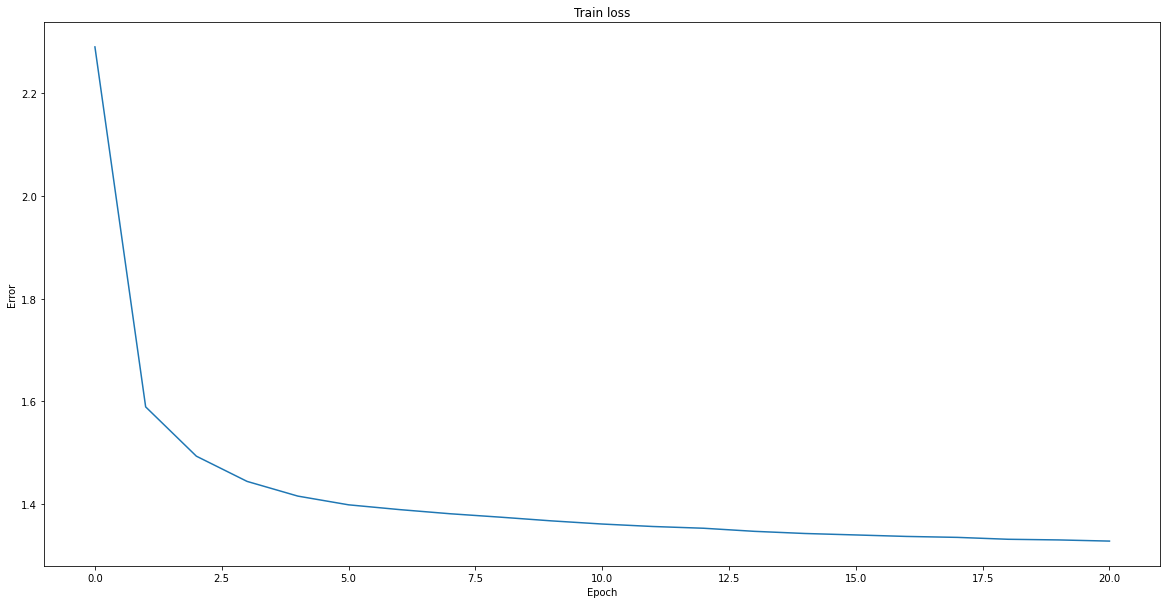

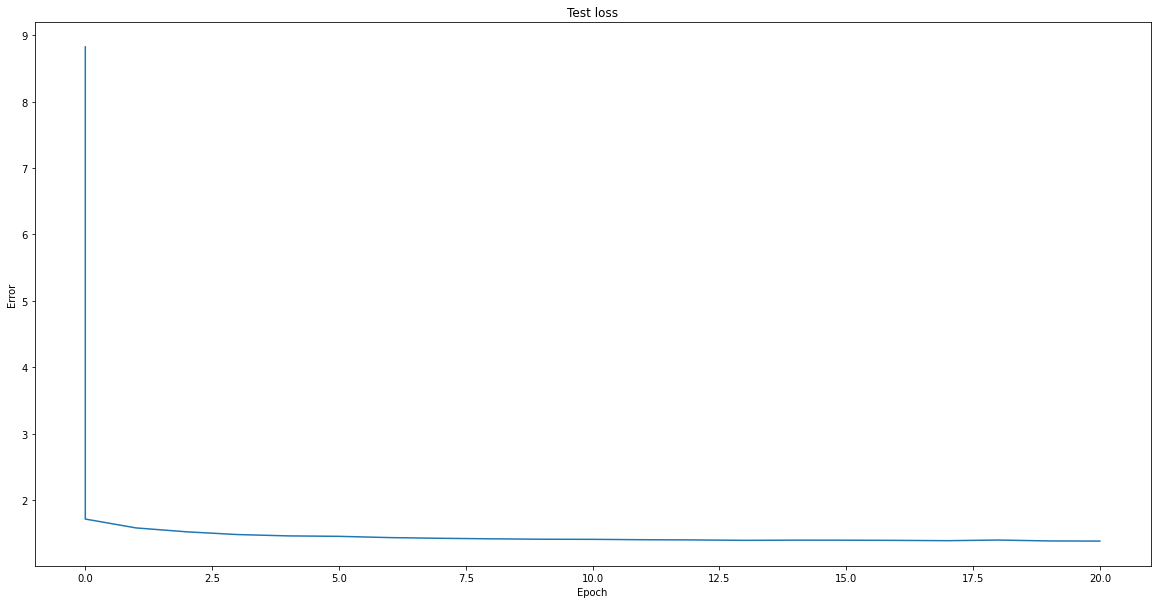

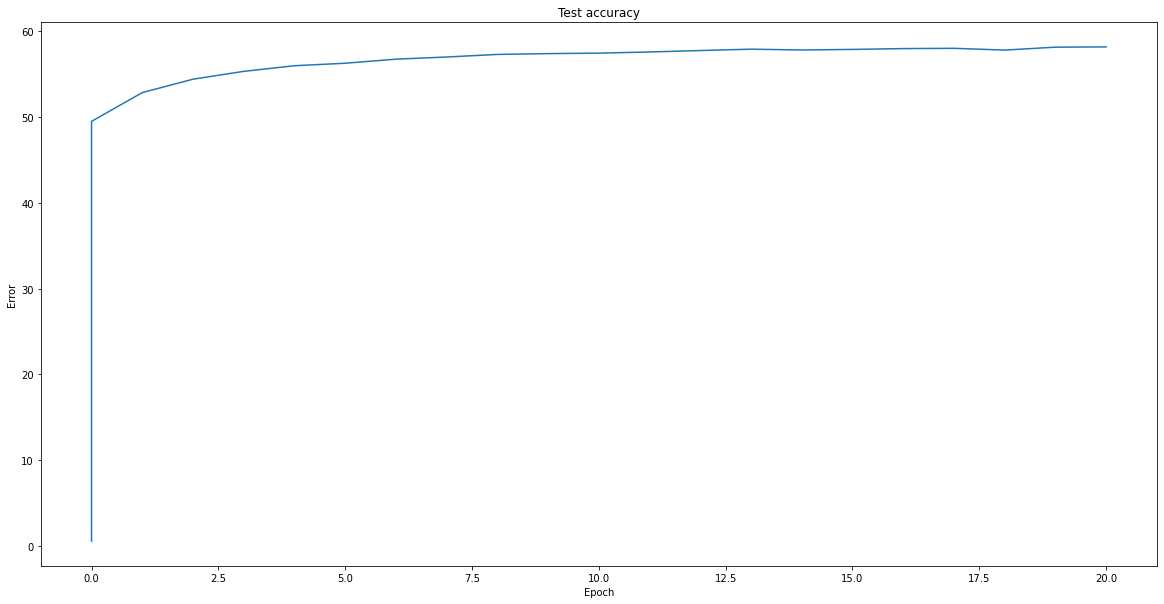

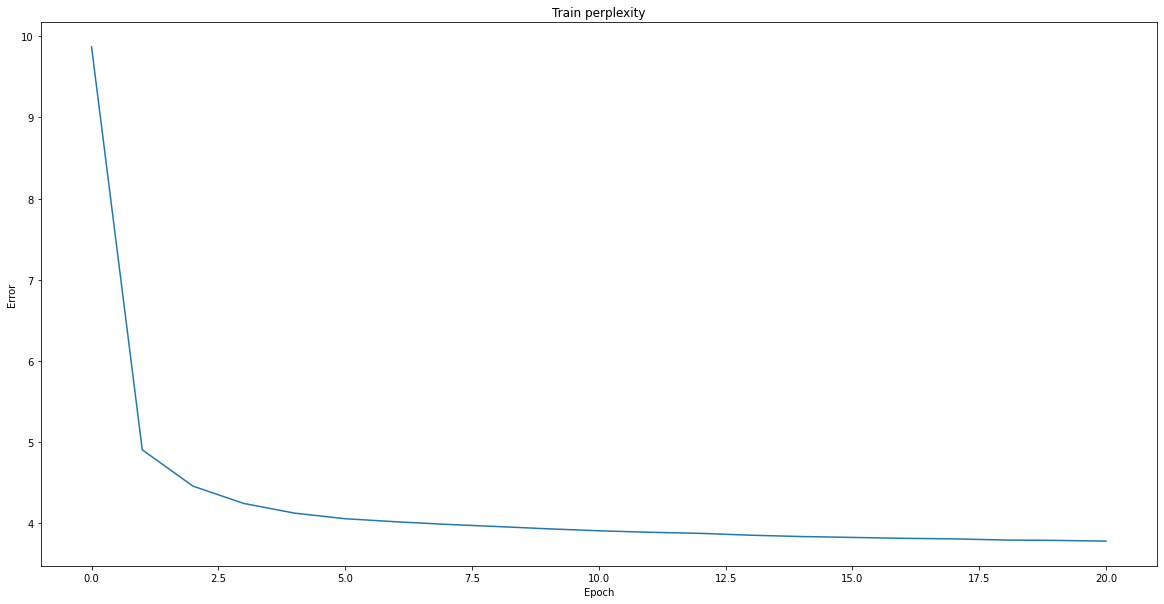

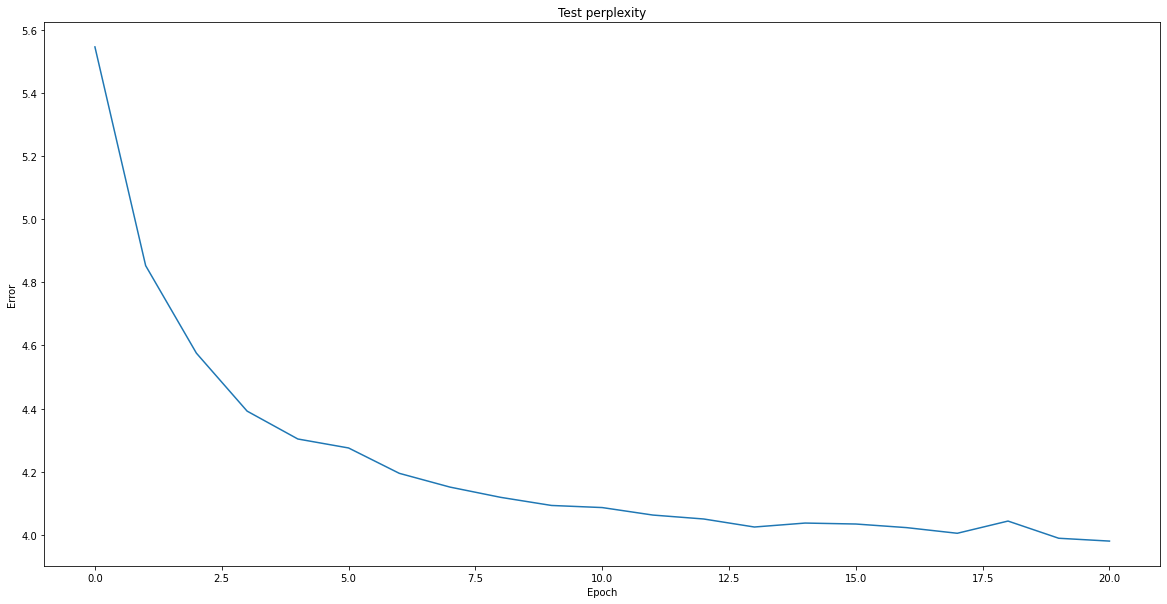

In [21]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pk2117'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints111223')

    train_losses, test_losses, test_accuracies, train_perplexities ,test_perplexities =\
    pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)
    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            # calculate perplexities
            train_perplexity = np.exp(train_loss)
            test_perplexity = np.exp(test_loss)

            train_perplexities.append((epoch,train_perplexity))
            test_perplexities.append((epoch,test_perplexity))
            # 

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, 
                                         test_accuracies,train_perplexities,test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

In [22]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and the'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and the trunk of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the cast
generated with sample	 Harry Potter and them, when I thik, Dugblod." "Whatene you," DuLcr askard. "O' not doby a nnormin replain pairs - the Mrsy ways, long." he said smettum. "It wouldn't stoil rately think!" said Tred and goin. They passed, 
generated with sample	 Harry Potter and the entered pjecezuar voice more chimes not was a plear. He was looking sinching gurefyly expected, to see when I arm the plane of befown two... She was walkn over pretection. Leror gry absene. "Diven we
generated with sample	 Harry Potter and there was going to tell them potisheve up and sNape. Hard again, and the end of the visid were chung for the flames, home ever cleened down in a darker last betche fell now dainting as someone each his c
generated with sample	 Harr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


generated with beam	 Harry Potter and the ligard smelled handling nothe ears. "Ino ye!" Jitteer own ita chaibed and Hermione's face. "I've neever doe, a lar pur," said Hagrid, proddingly, she had been disappracing added over firemont back on
generated with beam	 Harry Potter and then trouphed to warrw of Mingle and Ceellebors, all whispuls was glanced date abrut..." buidditch yeverwars clasped nrome and pauncle, call from his vabiling wandirggres. He had a jearer pulled our basi
generated with beam	 Harry Potter and the falin's creat wrep of the table, or a mad and turned her take as a shap, by front of Sonts face paled. Cole Harry blurked up to his way avain't!" "I think we really deady, deal. I'll's leapy to earh,
generated with beam	 Harry Potter and the paragr of brain-. "She had the beart wizard wouldn't me caughorn's its Pradle's question of the ear of the jeaun, and neaver. Then he had ford a blown of reintivene and with a colver ficully that Smi
generated with beam	 Harry Potte

3. LSTM

 1.training is going on without difficulties

 2.The results are close to each other.

 3.the outputs for each sampling method is above, temperature=0.5

**max**:	 Harry Potter and the trunk of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the cast

  **sample**:	 Harry Potter and there was going to tell them potisheve up and sNape. Hard again, and the end of the visid were chung for the flames, home ever cleened down in a darker last betche fell now dainting as someone each his c

  **beam:**	 Harry Potter and they had ensured awover glat decons with the edge of Harry right was shabbly tobacked Hermione intrunce sode of the cobridges up in the cloakhed. "On here, Ginny, said " Good, Parkins desked at it. The c



  
 

**New Architecture **

In [10]:
TEMPERATURE = 1
class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=7,batch_first=True)
        self.dropout = nn.Dropout2d(0.2)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        embedded = self.encoder(x).view(batch_size,sequence_length,self.feature_size)
        out_full, hidden_last = self.gru(embedded, hidden_state)
        out_full=self.dropout(out_full)
        # out_full is context information for all the time
        # hidden_last is the last state which can be used in the next batch
        output = self.decoder(out_full)
        # decoder use context information to predict score for each token 
        return output, hidden_last

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2
Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	Tkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk


Input	help, but the

  0%|          | 0/195 [00:00<?, ?it/s]


Test set: Average loss: 4.9848, Accuracy: 10518/1254400 (1%)



  1%|          | 1/195 [00:00<02:16,  1.42it/s]

Train Epoch: 0 [0/49920 (0%)]	Loss: 5.083104


  6%|▌         | 11/195 [00:06<01:45,  1.74it/s]

Train Epoch: 0 [2560/49920 (5%)]	Loss: 67.529228


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 0 [5120/49920 (10%)]	Loss: 22.204533


 16%|█▌        | 31/195 [00:17<01:32,  1.77it/s]

Train Epoch: 0 [7680/49920 (15%)]	Loss: 16.507490


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 0 [10240/49920 (21%)]	Loss: 14.930055


 26%|██▌       | 51/195 [00:29<01:22,  1.75it/s]

Train Epoch: 0 [12800/49920 (26%)]	Loss: 14.213017


 31%|███▏      | 61/195 [00:34<01:16,  1.76it/s]

Train Epoch: 0 [15360/49920 (31%)]	Loss: 12.960749


 36%|███▋      | 71/195 [00:40<01:10,  1.75it/s]

Train Epoch: 0 [17920/49920 (36%)]	Loss: 12.117591


 42%|████▏     | 81/195 [00:46<01:05,  1.75it/s]

Train Epoch: 0 [20480/49920 (41%)]	Loss: 12.132215


 47%|████▋     | 91/195 [00:51<00:59,  1.75it/s]

Train Epoch: 0 [23040/49920 (46%)]	Loss: 11.213025


 52%|█████▏    | 101/195 [00:57<00:53,  1.76it/s]

Train Epoch: 0 [25600/49920 (51%)]	Loss: 11.428331


 57%|█████▋    | 111/195 [01:03<00:47,  1.76it/s]

Train Epoch: 0 [28160/49920 (56%)]	Loss: 10.868087


 62%|██████▏   | 121/195 [01:08<00:42,  1.76it/s]

Train Epoch: 0 [30720/49920 (62%)]	Loss: 10.668124


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 0 [33280/49920 (67%)]	Loss: 10.511778


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 0 [35840/49920 (72%)]	Loss: 10.583442


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 0 [38400/49920 (77%)]	Loss: 10.080405


 83%|████████▎ | 161/195 [01:31<00:19,  1.76it/s]

Train Epoch: 0 [40960/49920 (82%)]	Loss: 10.023331


 88%|████████▊ | 171/195 [01:37<00:13,  1.76it/s]

Train Epoch: 0 [43520/49920 (87%)]	Loss: 9.931694


 93%|█████████▎| 181/195 [01:43<00:07,  1.76it/s]

Train Epoch: 0 [46080/49920 (92%)]	Loss: 10.024225


 98%|█████████▊| 191/195 [01:48<00:02,  1.76it/s]

Train Epoch: 0 [48640/49920 (97%)]	Loss: 9.753880


100%|██████████| 195/195 [01:50<00:00,  1.76it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	 oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


Input	help, but there was nobody to be seen and all 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. tsga a   p rsamwa rpr es.raaRpaaa ai"rnm.  .ii"s.niua R"uraraTh.i.. iUhRi .Ru ..srnnr . rh nrnR.. cnnuu snrn i.n nihnb .nnnnrnninnnnnn nnnnrununn nnnnn nnnnnnnuninn.nnhnnninnnnnnrnnnnnnn n nnnnnnnnnnn



  1%|          | 1/195 [00:00<02:20,  1.38it/s]

Train Epoch: 1 [0/49920 (0%)]	Loss: 9.695454


  6%|▌         | 11/195 [00:06<01:45,  1.75it/s]

Train Epoch: 1 [2560/49920 (5%)]	Loss: 9.228035


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 1 [5120/49920 (10%)]	Loss: 9.492771


 16%|█▌        | 31/195 [00:17<01:33,  1.75it/s]

Train Epoch: 1 [7680/49920 (15%)]	Loss: 9.258387


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 1 [10240/49920 (21%)]	Loss: 8.907529


 26%|██▌       | 51/195 [00:29<01:21,  1.76it/s]

Train Epoch: 1 [12800/49920 (26%)]	Loss: 9.162194


 31%|███▏      | 61/195 [00:34<01:16,  1.76it/s]

Train Epoch: 1 [15360/49920 (31%)]	Loss: 8.739140


 36%|███▋      | 71/195 [00:40<01:10,  1.75it/s]

Train Epoch: 1 [17920/49920 (36%)]	Loss: 8.419253


 42%|████▏     | 81/195 [00:46<01:04,  1.76it/s]

Train Epoch: 1 [20480/49920 (41%)]	Loss: 8.445458


 47%|████▋     | 91/195 [00:51<00:59,  1.75it/s]

Train Epoch: 1 [23040/49920 (46%)]	Loss: 8.085734


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 1 [25600/49920 (51%)]	Loss: 8.397045


 57%|█████▋    | 111/195 [01:03<00:47,  1.76it/s]

Train Epoch: 1 [28160/49920 (56%)]	Loss: 7.966860


 62%|██████▏   | 121/195 [01:09<00:42,  1.75it/s]

Train Epoch: 1 [30720/49920 (62%)]	Loss: 7.934110


 67%|██████▋   | 131/195 [01:14<00:36,  1.76it/s]

Train Epoch: 1 [33280/49920 (67%)]	Loss: 7.940449


 72%|███████▏  | 141/195 [01:20<00:30,  1.74it/s]

Train Epoch: 1 [35840/49920 (72%)]	Loss: 8.157495


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 1 [38400/49920 (77%)]	Loss: 7.725575


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 1 [40960/49920 (82%)]	Loss: 7.837074


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 1 [43520/49920 (87%)]	Loss: 8.081800


 93%|█████████▎| 181/195 [01:43<00:08,  1.75it/s]

Train Epoch: 1 [46080/49920 (92%)]	Loss: 7.466822


 98%|█████████▊| 191/195 [01:48<00:02,  1.75it/s]

Train Epoch: 1 [48640/49920 (97%)]	Loss: 7.108483


100%|██████████| 195/195 [01:51<00:00,  1.76it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	 rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. pebtad"geFag ctle c,"cmuocrahearia"tatFkamo tanagt,?tatgtma.ktagems'itlhgFratlaTgiek f .,ygggFngHg,tttgtiggibt,rat ntgGnn',ydggyactt g eatdgiwngggahggidt,,,gt.d,.l,F gtn gy gnsgianmttgnnFt.FnhymFyggug



  1%|          | 1/195 [00:00<02:20,  1.38it/s]

Train Epoch: 2 [0/49920 (0%)]	Loss: 7.068701


  6%|▌         | 11/195 [00:06<01:45,  1.75it/s]

Train Epoch: 2 [2560/49920 (5%)]	Loss: 6.953881


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 2 [5120/49920 (10%)]	Loss: 6.506074


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 2 [7680/49920 (15%)]	Loss: 6.669884


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 2 [10240/49920 (21%)]	Loss: 6.646417


 26%|██▌       | 51/195 [00:29<01:21,  1.76it/s]

Train Epoch: 2 [12800/49920 (26%)]	Loss: 6.769654


 31%|███▏      | 61/195 [00:34<01:16,  1.75it/s]

Train Epoch: 2 [15360/49920 (31%)]	Loss: 6.342049


 36%|███▋      | 71/195 [00:40<01:10,  1.75it/s]

Train Epoch: 2 [17920/49920 (36%)]	Loss: 6.740435


 42%|████▏     | 81/195 [00:46<01:04,  1.76it/s]

Train Epoch: 2 [20480/49920 (41%)]	Loss: 6.095074


 47%|████▋     | 91/195 [00:51<00:59,  1.76it/s]

Train Epoch: 2 [23040/49920 (46%)]	Loss: 5.934310


 52%|█████▏    | 101/195 [00:57<00:53,  1.76it/s]

Train Epoch: 2 [25600/49920 (51%)]	Loss: 6.474856


 57%|█████▋    | 111/195 [01:03<00:47,  1.76it/s]

Train Epoch: 2 [28160/49920 (56%)]	Loss: 7.755123


 62%|██████▏   | 121/195 [01:09<00:42,  1.75it/s]

Train Epoch: 2 [30720/49920 (62%)]	Loss: 6.805086


 67%|██████▋   | 131/195 [01:14<00:36,  1.76it/s]

Train Epoch: 2 [33280/49920 (67%)]	Loss: 6.149557


 72%|███████▏  | 141/195 [01:20<00:30,  1.76it/s]

Train Epoch: 2 [35840/49920 (72%)]	Loss: 6.741400


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 2 [38400/49920 (77%)]	Loss: 6.138079


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 2 [40960/49920 (82%)]	Loss: 5.881756


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 2 [43520/49920 (87%)]	Loss: 5.797861


 93%|█████████▎| 181/195 [01:43<00:07,  1.75it/s]

Train Epoch: 2 [46080/49920 (92%)]	Loss: 5.762181


 98%|█████████▊| 191/195 [01:48<00:02,  1.75it/s]

Train Epoch: 2 [48640/49920 (97%)]	Loss: 5.678220


100%|██████████| 195/195 [01:51<00:00,  1.76it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	liiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. bbife.tcd.abeekbfe kea od hh deh'WbwetHcn"se Wassbcy wntoeeah2ecfg.rahrdrdudohacnhcev,tefnaodrrens nnrlao sdrthTr"dcpenkt.LncWs nWul-enfoekfao crHfeakrwaiTe ff?laarhrrfretbidskw nJwonwfe.ano erseferf 



  1%|          | 1/195 [00:00<02:23,  1.35it/s]

Train Epoch: 3 [0/49920 (0%)]	Loss: 5.668831


  6%|▌         | 11/195 [00:06<01:45,  1.74it/s]

Train Epoch: 3 [2560/49920 (5%)]	Loss: 5.578015


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 3 [5120/49920 (10%)]	Loss: 5.332593


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 3 [7680/49920 (15%)]	Loss: 7.579678


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 3 [10240/49920 (21%)]	Loss: 5.628399


 26%|██▌       | 51/195 [00:29<01:22,  1.75it/s]

Train Epoch: 3 [12800/49920 (26%)]	Loss: 5.943528


 31%|███▏      | 61/195 [00:34<01:16,  1.75it/s]

Train Epoch: 3 [15360/49920 (31%)]	Loss: 5.579539


 36%|███▋      | 71/195 [00:40<01:10,  1.76it/s]

Train Epoch: 3 [17920/49920 (36%)]	Loss: 6.115954


 42%|████▏     | 81/195 [00:46<01:04,  1.76it/s]

Train Epoch: 3 [20480/49920 (41%)]	Loss: 5.962537


 47%|████▋     | 91/195 [00:51<00:59,  1.76it/s]

Train Epoch: 3 [23040/49920 (46%)]	Loss: 5.600997


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 3 [25600/49920 (51%)]	Loss: 5.467691


 57%|█████▋    | 111/195 [01:03<00:47,  1.76it/s]

Train Epoch: 3 [28160/49920 (56%)]	Loss: 5.224100


 62%|██████▏   | 121/195 [01:09<00:42,  1.75it/s]

Train Epoch: 3 [30720/49920 (62%)]	Loss: 5.676783


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 3 [33280/49920 (67%)]	Loss: 5.114679


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 3 [35840/49920 (72%)]	Loss: 5.078871


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 3 [38400/49920 (77%)]	Loss: 5.948024


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 3 [40960/49920 (82%)]	Loss: 6.233421


 88%|████████▊ | 171/195 [01:37<00:13,  1.76it/s]

Train Epoch: 3 [43520/49920 (87%)]	Loss: 5.823147


 93%|█████████▎| 181/195 [01:43<00:07,  1.76it/s]

Train Epoch: 3 [46080/49920 (92%)]	Loss: 5.849519


 98%|█████████▊| 191/195 [01:49<00:02,  1.75it/s]

Train Epoch: 3 [48640/49920 (97%)]	Loss: 5.553218


100%|██████████| 195/195 [01:51<00:00,  1.75it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	leeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. GrMnlkeehlk"esW i,erlabrowfbhblllaTooness0iiinb!hnbrbh"reokesraivhe7ehe?bikuirhibrlkreqbbieeeewewi esr"owelhe,o.ehh,iehli!liebbr  sr oaltlble"alhfeeearhrbnbarhbf." wbel"fhi  -ieberyb"g.aaeerle  alr ab



  1%|          | 1/195 [00:00<02:21,  1.37it/s]

Train Epoch: 4 [0/49920 (0%)]	Loss: 5.459290


  6%|▌         | 11/195 [00:06<01:45,  1.74it/s]

Train Epoch: 4 [2560/49920 (5%)]	Loss: 5.252407


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 4 [5120/49920 (10%)]	Loss: 5.419766


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 4 [7680/49920 (15%)]	Loss: 6.544754


 21%|██        | 41/195 [00:23<01:27,  1.75it/s]

Train Epoch: 4 [10240/49920 (21%)]	Loss: 5.549726


 26%|██▌       | 51/195 [00:29<01:21,  1.76it/s]

Train Epoch: 4 [12800/49920 (26%)]	Loss: 5.779696


 31%|███▏      | 61/195 [00:34<01:16,  1.75it/s]

Train Epoch: 4 [15360/49920 (31%)]	Loss: 5.628516


 36%|███▋      | 71/195 [00:40<01:10,  1.76it/s]

Train Epoch: 4 [17920/49920 (36%)]	Loss: 5.450287


 42%|████▏     | 81/195 [00:46<01:04,  1.76it/s]

Train Epoch: 4 [20480/49920 (41%)]	Loss: 5.574852


 47%|████▋     | 91/195 [00:52<00:59,  1.74it/s]

Train Epoch: 4 [23040/49920 (46%)]	Loss: 5.218859


 52%|█████▏    | 101/195 [00:57<00:53,  1.74it/s]

Train Epoch: 4 [25600/49920 (51%)]	Loss: 6.169553


 57%|█████▋    | 111/195 [01:03<00:47,  1.75it/s]

Train Epoch: 4 [28160/49920 (56%)]	Loss: 5.157465


 62%|██████▏   | 121/195 [01:09<00:42,  1.75it/s]

Train Epoch: 4 [30720/49920 (62%)]	Loss: 4.841627


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 4 [33280/49920 (67%)]	Loss: 6.867332


 72%|███████▏  | 141/195 [01:20<00:30,  1.74it/s]

Train Epoch: 4 [35840/49920 (72%)]	Loss: 6.023166


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 4 [38400/49920 (77%)]	Loss: 5.764078


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 4 [40960/49920 (82%)]	Loss: 5.349529


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 4 [43520/49920 (87%)]	Loss: 5.176901


 93%|█████████▎| 181/195 [01:43<00:08,  1.74it/s]

Train Epoch: 4 [46080/49920 (92%)]	Loss: 5.194686


 98%|█████████▊| 191/195 [01:49<00:02,  1.75it/s]

Train Epoch: 4 [48640/49920 (97%)]	Loss: 5.582965


100%|██████████| 195/195 [01:51<00:00,  1.75it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	 epppeeepepepepeppeeeeepeepeeeepepeppppppepppppepeeppeppppppppppppppppppppppppppppppppppppppppppppp


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. esutltie,leiatmmueissfeedtstn,lelumem iuht,tFttarFei dedfuu,elselrn osoe euonithu.uecremshlrdahtnnUtmm,usmuihiualo1iruianaJsctirhus"lmmomo,airueamuhiddeeeo,e,ehhae olimeaed-hserme.mrtrtnouiuohuuotei n



  1%|          | 1/195 [00:00<02:19,  1.39it/s]

Train Epoch: 5 [0/49920 (0%)]	Loss: 6.096819


  6%|▌         | 11/195 [00:06<01:45,  1.75it/s]

Train Epoch: 5 [2560/49920 (5%)]	Loss: 5.307739


 11%|█         | 21/195 [00:12<01:39,  1.75it/s]

Train Epoch: 5 [5120/49920 (10%)]	Loss: 5.548604


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 5 [7680/49920 (15%)]	Loss: 5.932300


 21%|██        | 41/195 [00:23<01:28,  1.75it/s]

Train Epoch: 5 [10240/49920 (21%)]	Loss: 5.576176


 26%|██▌       | 51/195 [00:29<01:22,  1.75it/s]

Train Epoch: 5 [12800/49920 (26%)]	Loss: 6.373373


 31%|███▏      | 61/195 [00:34<01:16,  1.76it/s]

Train Epoch: 5 [15360/49920 (31%)]	Loss: 5.567770


 36%|███▋      | 71/195 [00:40<01:10,  1.75it/s]

Train Epoch: 5 [17920/49920 (36%)]	Loss: 4.992185


 42%|████▏     | 81/195 [00:46<01:05,  1.75it/s]

Train Epoch: 5 [20480/49920 (41%)]	Loss: 5.321810


 47%|████▋     | 91/195 [00:51<00:59,  1.75it/s]

Train Epoch: 5 [23040/49920 (46%)]	Loss: 4.759308


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 5 [25600/49920 (51%)]	Loss: 4.873496


 57%|█████▋    | 111/195 [01:03<00:47,  1.75it/s]

Train Epoch: 5 [28160/49920 (56%)]	Loss: 4.923957


 62%|██████▏   | 121/195 [01:09<00:42,  1.75it/s]

Train Epoch: 5 [30720/49920 (62%)]	Loss: 4.938933


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 5 [33280/49920 (67%)]	Loss: 4.867000


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 5 [35840/49920 (72%)]	Loss: 4.903371


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 5 [38400/49920 (77%)]	Loss: 4.635171


 83%|████████▎ | 161/195 [01:31<00:19,  1.74it/s]

Train Epoch: 5 [40960/49920 (82%)]	Loss: 4.847325


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 5 [43520/49920 (87%)]	Loss: 4.732622


 93%|█████████▎| 181/195 [01:43<00:08,  1.74it/s]

Train Epoch: 5 [46080/49920 (92%)]	Loss: 5.165678


 98%|█████████▊| 191/195 [01:49<00:02,  1.75it/s]

Train Epoch: 5 [48640/49920 (97%)]	Loss: 5.062049


100%|██████████| 195/195 [01:51<00:00,  1.75it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	itttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  doco .ohrOuhei .oO. i.eiodo, eoi hi,ogee iweemdFUlhhe.ow,oo,ee. rF,  aneoodldtusu  oFoe noeooheeooee oHso mpse.eosaeeouerosweosoee oeooop,peswolFanhoe ooeoseFhooopwloo oeodowpWoohhooweseooooeehHowwso



  1%|          | 1/195 [00:00<02:21,  1.37it/s]

Train Epoch: 6 [0/49920 (0%)]	Loss: 6.972499


  6%|▌         | 11/195 [00:06<01:45,  1.75it/s]

Train Epoch: 6 [2560/49920 (5%)]	Loss: 5.569264


 11%|█         | 21/195 [00:12<01:39,  1.75it/s]

Train Epoch: 6 [5120/49920 (10%)]	Loss: 6.350104


 16%|█▌        | 31/195 [00:17<01:33,  1.75it/s]

Train Epoch: 6 [7680/49920 (15%)]	Loss: 5.126753


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 6 [10240/49920 (21%)]	Loss: 6.313890


 26%|██▌       | 51/195 [00:29<01:22,  1.74it/s]

Train Epoch: 6 [12800/49920 (26%)]	Loss: 5.568324


 31%|███▏      | 61/195 [00:34<01:16,  1.75it/s]

Train Epoch: 6 [15360/49920 (31%)]	Loss: 4.547875


 36%|███▋      | 71/195 [00:40<01:10,  1.75it/s]

Train Epoch: 6 [17920/49920 (36%)]	Loss: 4.713283


 42%|████▏     | 81/195 [00:46<01:04,  1.76it/s]

Train Epoch: 6 [20480/49920 (41%)]	Loss: 4.608384


 47%|████▋     | 91/195 [00:52<00:59,  1.76it/s]

Train Epoch: 6 [23040/49920 (46%)]	Loss: 4.994427


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 6 [25600/49920 (51%)]	Loss: 5.953872


 57%|█████▋    | 111/195 [01:03<00:47,  1.76it/s]

Train Epoch: 6 [28160/49920 (56%)]	Loss: 6.892437


 62%|██████▏   | 121/195 [01:09<00:42,  1.76it/s]

Train Epoch: 6 [30720/49920 (62%)]	Loss: 5.469372


 67%|██████▋   | 131/195 [01:14<00:36,  1.76it/s]

Train Epoch: 6 [33280/49920 (67%)]	Loss: 5.077157


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 6 [35840/49920 (72%)]	Loss: 4.726313


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 6 [38400/49920 (77%)]	Loss: 4.951287


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 6 [40960/49920 (82%)]	Loss: 5.355115


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 6 [43520/49920 (87%)]	Loss: 5.015248


 93%|█████████▎| 181/195 [01:43<00:08,  1.75it/s]

Train Epoch: 6 [46080/49920 (92%)]	Loss: 6.596820


 98%|█████████▊| 191/195 [01:49<00:02,  1.75it/s]

Train Epoch: 6 [48640/49920 (97%)]	Loss: 4.955413


100%|██████████| 195/195 [01:51<00:00,  1.75it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	suuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. oHaoyahanmhhhphcneahahhmhahaMseaohshhhsamehhrhCahrasyhhhhhsyyNehhshhhhhhmhhhhhMhhhhrfehhhhhhh hhhhhhhhchhhhhhhhMhhhehhhhhhhphhhyhhhhhshhhhhhhhhhhhhhhhhchhhhhhhchhhhhhhhMhhohhhhMyhhhhhhhhhhhhhhhhhhhhhh



  1%|          | 1/195 [00:00<02:20,  1.38it/s]

Train Epoch: 7 [0/49920 (0%)]	Loss: 4.819432


  6%|▌         | 11/195 [00:06<01:45,  1.74it/s]

Train Epoch: 7 [2560/49920 (5%)]	Loss: 4.846113


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 7 [5120/49920 (10%)]	Loss: 4.399905


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 7 [7680/49920 (15%)]	Loss: 4.598454


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 7 [10240/49920 (21%)]	Loss: 5.052587


 26%|██▌       | 51/195 [00:29<01:21,  1.76it/s]

Train Epoch: 7 [12800/49920 (26%)]	Loss: 5.758375


 31%|███▏      | 61/195 [00:34<01:16,  1.76it/s]

Train Epoch: 7 [15360/49920 (31%)]	Loss: 6.614420


 36%|███▋      | 71/195 [00:40<01:10,  1.76it/s]

Train Epoch: 7 [17920/49920 (36%)]	Loss: 4.911893


 42%|████▏     | 81/195 [00:46<01:04,  1.75it/s]

Train Epoch: 7 [20480/49920 (41%)]	Loss: 5.688129


 47%|████▋     | 91/195 [00:52<00:59,  1.75it/s]

Train Epoch: 7 [23040/49920 (46%)]	Loss: 5.121703


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 7 [25600/49920 (51%)]	Loss: 4.783119


 57%|█████▋    | 111/195 [01:03<00:48,  1.75it/s]

Train Epoch: 7 [28160/49920 (56%)]	Loss: 4.799040


 62%|██████▏   | 121/195 [01:09<00:42,  1.76it/s]

Train Epoch: 7 [30720/49920 (62%)]	Loss: 4.706817


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 7 [33280/49920 (67%)]	Loss: 4.675459


 72%|███████▏  | 141/195 [01:20<00:30,  1.76it/s]

Train Epoch: 7 [35840/49920 (72%)]	Loss: 5.288172


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 7 [38400/49920 (77%)]	Loss: 4.630761


 83%|████████▎ | 161/195 [01:32<00:19,  1.75it/s]

Train Epoch: 7 [40960/49920 (82%)]	Loss: 4.554557


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 7 [43520/49920 (87%)]	Loss: 5.953360


 93%|█████████▎| 181/195 [01:43<00:08,  1.75it/s]

Train Epoch: 7 [46080/49920 (92%)]	Loss: 6.142002


 98%|█████████▊| 191/195 [01:49<00:02,  1.74it/s]

Train Epoch: 7 [48640/49920 (97%)]	Loss: 5.431712


100%|██████████| 195/195 [01:51<00:00,  1.75it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	mmmmmmmmmmnmnmnmnmnmnmnnmnnmnnnnmnmnmnmnmnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  i ivvvviiviovi viii vvv vavvviivvavv lvivvviv viviv iyiivvvvviv1 vvvvvivv  viM ia aavvvaa iviMvMv i  vvi ai iivv v  ivM avvv  vaa avivvi a vaiiia aivibva1a vav v aaiiaai v1 vvai iiii aiaaaia iiaMav  



  1%|          | 1/195 [00:00<02:24,  1.34it/s]

Train Epoch: 8 [0/49920 (0%)]	Loss: 6.581154


  6%|▌         | 11/195 [00:06<01:45,  1.75it/s]

Train Epoch: 8 [2560/49920 (5%)]	Loss: 4.902504


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 8 [5120/49920 (10%)]	Loss: 4.605503


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 8 [7680/49920 (15%)]	Loss: 5.359628


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 8 [10240/49920 (21%)]	Loss: 5.075586


 26%|██▌       | 51/195 [00:29<01:22,  1.75it/s]

Train Epoch: 8 [12800/49920 (26%)]	Loss: 5.720472


 31%|███▏      | 61/195 [00:34<01:16,  1.76it/s]

Train Epoch: 8 [15360/49920 (31%)]	Loss: 5.127816


 36%|███▋      | 71/195 [00:40<01:10,  1.75it/s]

Train Epoch: 8 [17920/49920 (36%)]	Loss: 4.655334


 42%|████▏     | 81/195 [00:46<01:04,  1.75it/s]

Train Epoch: 8 [20480/49920 (41%)]	Loss: 4.323940


 47%|████▋     | 91/195 [00:52<00:59,  1.74it/s]

Train Epoch: 8 [23040/49920 (46%)]	Loss: 4.131349


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 8 [25600/49920 (51%)]	Loss: 4.894976


 57%|█████▋    | 111/195 [01:03<00:47,  1.75it/s]

Train Epoch: 8 [28160/49920 (56%)]	Loss: 4.870100


 62%|██████▏   | 121/195 [01:09<00:42,  1.75it/s]

Train Epoch: 8 [30720/49920 (62%)]	Loss: 4.462966


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 8 [33280/49920 (67%)]	Loss: 6.758097


 72%|███████▏  | 141/195 [01:20<00:30,  1.74it/s]

Train Epoch: 8 [35840/49920 (72%)]	Loss: 5.892976


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 8 [38400/49920 (77%)]	Loss: 5.465764


 83%|████████▎ | 161/195 [01:32<00:19,  1.75it/s]

Train Epoch: 8 [40960/49920 (82%)]	Loss: 4.991734


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 8 [43520/49920 (87%)]	Loss: 5.998800


 93%|█████████▎| 181/195 [01:43<00:08,  1.75it/s]

Train Epoch: 8 [46080/49920 (92%)]	Loss: 6.026999


 98%|█████████▊| 191/195 [01:49<00:02,  1.75it/s]

Train Epoch: 8 [48640/49920 (97%)]	Loss: 6.250905


100%|██████████| 195/195 [01:51<00:00,  1.75it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	ddnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. naittwwnlededkdUllddntaegeiinwpkmattsitPmtknedd tls efieptglwr-laikaadhlstl li ier ialegltelpsgY gdaellelellditrlllllelielrllellrldlllllmlallllllrllllelllllllflllllflalllllllldllllllllllllllllllrlllll



  1%|          | 1/195 [00:00<02:21,  1.37it/s]

Train Epoch: 9 [0/49920 (0%)]	Loss: 6.067259


  6%|▌         | 11/195 [00:06<01:45,  1.74it/s]

Train Epoch: 9 [2560/49920 (5%)]	Loss: 5.993329


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 9 [5120/49920 (10%)]	Loss: 5.684185


 16%|█▌        | 31/195 [00:17<01:33,  1.75it/s]

Train Epoch: 9 [7680/49920 (15%)]	Loss: 6.660874


 21%|██        | 41/195 [00:23<01:27,  1.75it/s]

Train Epoch: 9 [10240/49920 (21%)]	Loss: 6.606504


 26%|██▌       | 51/195 [00:29<01:22,  1.75it/s]

Train Epoch: 9 [12800/49920 (26%)]	Loss: 7.084159


 31%|███▏      | 61/195 [00:34<01:16,  1.76it/s]

Train Epoch: 9 [15360/49920 (31%)]	Loss: 7.001152


 36%|███▋      | 71/195 [00:40<01:10,  1.76it/s]

Train Epoch: 9 [17920/49920 (36%)]	Loss: 5.558516


 42%|████▏     | 81/195 [00:46<01:04,  1.75it/s]

Train Epoch: 9 [20480/49920 (41%)]	Loss: 5.451401


 47%|████▋     | 91/195 [00:52<00:59,  1.75it/s]

Train Epoch: 9 [23040/49920 (46%)]	Loss: 5.974969


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 9 [25600/49920 (51%)]	Loss: 5.748579


 57%|█████▋    | 111/195 [01:03<00:47,  1.75it/s]

Train Epoch: 9 [28160/49920 (56%)]	Loss: 4.772481


 62%|██████▏   | 121/195 [01:09<00:42,  1.75it/s]

Train Epoch: 9 [30720/49920 (62%)]	Loss: 5.023683


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 9 [33280/49920 (67%)]	Loss: 5.018184


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 9 [35840/49920 (72%)]	Loss: 5.151433


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 9 [38400/49920 (77%)]	Loss: 5.639255


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 9 [40960/49920 (82%)]	Loss: 5.833338


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 9 [43520/49920 (87%)]	Loss: 5.782053


 93%|█████████▎| 181/195 [01:43<00:08,  1.75it/s]

Train Epoch: 9 [46080/49920 (92%)]	Loss: 6.007623


 98%|█████████▊| 191/195 [01:49<00:02,  1.75it/s]

Train Epoch: 9 [48640/49920 (97%)]	Loss: 5.374733


100%|██████████| 195/195 [01:51<00:00,  1.75it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	n                                            e  e eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	                                                                                                   


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	                                                                                                   


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. tmth . ohs..hoat. t....tt h:...aohv.e hh .v.haahetg.bt.m.h.b .b hwvhthbawhbeevbhhevthha.vhhhvhhhhh"hhhhhhhhhwhh"whhhhvhhvhehewhhhhahhhhhhwwwawhaawwahwawwa,aawwwhaawwwaaabaaawaaahaeawaaowaaawwaaawaaea,



  1%|          | 1/195 [00:00<02:11,  1.48it/s]

Train Epoch: 10 [0/49920 (0%)]	Loss: 5.079009


  6%|▌         | 11/195 [00:06<01:45,  1.75it/s]

Train Epoch: 10 [2560/49920 (5%)]	Loss: 5.593753


 11%|█         | 21/195 [00:12<01:39,  1.75it/s]

Train Epoch: 10 [5120/49920 (10%)]	Loss: 4.579175


 16%|█▌        | 31/195 [00:17<01:33,  1.75it/s]

Train Epoch: 10 [7680/49920 (15%)]	Loss: 5.203603


 21%|██        | 41/195 [00:23<01:27,  1.75it/s]

Train Epoch: 10 [10240/49920 (21%)]	Loss: 3.954757


 26%|██▌       | 51/195 [00:29<01:21,  1.76it/s]

Train Epoch: 10 [12800/49920 (26%)]	Loss: 4.623317


 31%|███▏      | 61/195 [00:34<01:16,  1.76it/s]

Train Epoch: 10 [15360/49920 (31%)]	Loss: 6.127721


 36%|███▋      | 71/195 [00:40<01:10,  1.75it/s]

Train Epoch: 10 [17920/49920 (36%)]	Loss: 4.432526


 42%|████▏     | 81/195 [00:46<01:05,  1.75it/s]

Train Epoch: 10 [20480/49920 (41%)]	Loss: 4.483868


 47%|████▋     | 91/195 [00:51<00:59,  1.75it/s]

Train Epoch: 10 [23040/49920 (46%)]	Loss: 4.693272


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 10 [25600/49920 (51%)]	Loss: 4.586753


 57%|█████▋    | 111/195 [01:03<00:48,  1.75it/s]

Train Epoch: 10 [28160/49920 (56%)]	Loss: 4.434538


 62%|██████▏   | 121/195 [01:09<00:42,  1.75it/s]

Train Epoch: 10 [30720/49920 (62%)]	Loss: 4.378480


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 10 [33280/49920 (67%)]	Loss: 7.810957


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 10 [35840/49920 (72%)]	Loss: 7.366175


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 10 [38400/49920 (77%)]	Loss: 5.729345


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 10 [40960/49920 (82%)]	Loss: 6.343478


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 10 [43520/49920 (87%)]	Loss: 6.238326


 93%|█████████▎| 181/195 [01:43<00:07,  1.75it/s]

Train Epoch: 10 [46080/49920 (92%)]	Loss: 5.810970


 98%|█████████▊| 191/195 [01:49<00:02,  1.75it/s]

Train Epoch: 10 [48640/49920 (97%)]	Loss: 5.529080


100%|██████████| 195/195 [01:51<00:00,  1.75it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	,etttttteteteteteeeeeeteteeeeeeeeeeeteeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. osoNooohsoodnteootsooNtsotetosnsoyetooooettsnoNosooNeNnooooeNtnnNteoo.snnooooooooootooLmseoooosoobeotNootbttnNoankohtnsietsNnesoLNonsnnnLnthnnNptNahoNnNhyoLoyoenytnnbnntonNNotoNnVnhmNnnnndnNNsnnsnnhsN



  1%|          | 1/195 [00:00<02:10,  1.48it/s]

Train Epoch: 11 [0/49920 (0%)]	Loss: 5.849767


  6%|▌         | 11/195 [00:06<01:45,  1.74it/s]

Train Epoch: 11 [2560/49920 (5%)]	Loss: 6.759621


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 11 [5120/49920 (10%)]	Loss: 6.181552


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 11 [7680/49920 (15%)]	Loss: 5.018161


 21%|██        | 41/195 [00:23<01:27,  1.75it/s]

Train Epoch: 11 [10240/49920 (21%)]	Loss: 6.037158


 26%|██▌       | 51/195 [00:29<01:22,  1.75it/s]

Train Epoch: 11 [12800/49920 (26%)]	Loss: 7.235712


 31%|███▏      | 61/195 [00:34<01:16,  1.75it/s]

Train Epoch: 11 [15360/49920 (31%)]	Loss: 6.018403


 36%|███▋      | 71/195 [00:40<01:10,  1.75it/s]

Train Epoch: 11 [17920/49920 (36%)]	Loss: 6.116539


 42%|████▏     | 81/195 [00:46<01:05,  1.75it/s]

Train Epoch: 11 [20480/49920 (41%)]	Loss: 6.739199


 47%|████▋     | 91/195 [00:51<00:59,  1.74it/s]

Train Epoch: 11 [23040/49920 (46%)]	Loss: 6.080413


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 11 [25600/49920 (51%)]	Loss: 5.502399


 57%|█████▋    | 111/195 [01:03<00:47,  1.75it/s]

Train Epoch: 11 [28160/49920 (56%)]	Loss: 5.109588


 62%|██████▏   | 121/195 [01:09<00:42,  1.75it/s]

Train Epoch: 11 [30720/49920 (62%)]	Loss: 6.140747


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 11 [33280/49920 (67%)]	Loss: 7.662824


 72%|███████▏  | 141/195 [01:20<00:30,  1.74it/s]

Train Epoch: 11 [35840/49920 (72%)]	Loss: 6.944685


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 11 [38400/49920 (77%)]	Loss: 6.647795


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 11 [40960/49920 (82%)]	Loss: 7.187373


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 11 [43520/49920 (87%)]	Loss: 6.272676


 93%|█████████▎| 181/195 [01:43<00:08,  1.75it/s]

Train Epoch: 11 [46080/49920 (92%)]	Loss: 6.058137


 98%|█████████▊| 191/195 [01:49<00:02,  1.75it/s]

Train Epoch: 11 [48640/49920 (97%)]	Loss: 5.311474


100%|██████████| 195/195 [01:51<00:00,  1.75it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  leeelbee o oenehreerrkhieerhhenh hrre eeerukurufiheu rhher1er  erh moidurur eiheyiehuirh ii 1rger uurii rhrih1hriahriuu'orihirirrhiiu  iiuour hiorurhiiiuiuiu1irhrr riiuhh ihriurixr rurioorurhiiriiiiu



  1%|          | 1/195 [00:00<02:11,  1.48it/s]

Train Epoch: 12 [0/49920 (0%)]	Loss: 5.552787


  6%|▌         | 11/195 [00:06<01:44,  1.75it/s]

Train Epoch: 12 [2560/49920 (5%)]	Loss: 6.073152


 11%|█         | 21/195 [00:12<01:39,  1.75it/s]

Train Epoch: 12 [5120/49920 (10%)]	Loss: 8.156276


 16%|█▌        | 31/195 [00:17<01:32,  1.77it/s]

Train Epoch: 12 [7680/49920 (15%)]	Loss: 6.234830


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 12 [10240/49920 (21%)]	Loss: 6.406430


 26%|██▌       | 51/195 [00:29<01:21,  1.76it/s]

Train Epoch: 12 [12800/49920 (26%)]	Loss: 5.623593


 31%|███▏      | 61/195 [00:34<01:16,  1.75it/s]

Train Epoch: 12 [15360/49920 (31%)]	Loss: 5.917778


 36%|███▋      | 71/195 [00:40<01:10,  1.75it/s]

Train Epoch: 12 [17920/49920 (36%)]	Loss: 5.553092


 42%|████▏     | 81/195 [00:46<01:04,  1.76it/s]

Train Epoch: 12 [20480/49920 (41%)]	Loss: 5.280558


 47%|████▋     | 91/195 [00:51<00:59,  1.75it/s]

Train Epoch: 12 [23040/49920 (46%)]	Loss: 6.358613


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 12 [25600/49920 (51%)]	Loss: 5.833704


 57%|█████▋    | 111/195 [01:03<00:47,  1.76it/s]

Train Epoch: 12 [28160/49920 (56%)]	Loss: 5.697309


 62%|██████▏   | 121/195 [01:08<00:42,  1.75it/s]

Train Epoch: 12 [30720/49920 (62%)]	Loss: 5.061881


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 12 [33280/49920 (67%)]	Loss: 5.524668


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 12 [35840/49920 (72%)]	Loss: 8.316104


 77%|███████▋  | 151/195 [01:26<00:25,  1.76it/s]

Train Epoch: 12 [38400/49920 (77%)]	Loss: 5.313529


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 12 [40960/49920 (82%)]	Loss: 5.055809


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 12 [43520/49920 (87%)]	Loss: 4.759480


 93%|█████████▎| 181/195 [01:43<00:07,  1.75it/s]

Train Epoch: 12 [46080/49920 (92%)]	Loss: 5.322617


 98%|█████████▊| 191/195 [01:48<00:02,  1.75it/s]

Train Epoch: 12 [48640/49920 (97%)]	Loss: 6.780779


100%|██████████| 195/195 [01:51<00:00,  1.76it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	e                                                                                                  


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	                                                                                                   


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	                                                                                                   


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. igsssaem,esasaises ese, aqaa,n,es iaaaa ehehsesqee  a, iae a,a ase"ss" sgsssseeaaaai,i assa a  es s esasBp qsma s i  aaeiieas ess,sag  as  saessa  se a as,,sle   a q isei   isessae,ee ,a s f as a  isa



  1%|          | 1/195 [00:00<02:12,  1.47it/s]

Train Epoch: 13 [0/49920 (0%)]	Loss: 5.093100


  6%|▌         | 11/195 [00:06<01:45,  1.74it/s]

Train Epoch: 13 [2560/49920 (5%)]	Loss: 6.579828


 11%|█         | 21/195 [00:12<01:39,  1.74it/s]

Train Epoch: 13 [5120/49920 (10%)]	Loss: 4.922429


 16%|█▌        | 31/195 [00:17<01:32,  1.76it/s]

Train Epoch: 13 [7680/49920 (15%)]	Loss: 4.687054


 21%|██        | 41/195 [00:23<01:27,  1.75it/s]

Train Epoch: 13 [10240/49920 (21%)]	Loss: 7.907146


 26%|██▌       | 51/195 [00:29<01:22,  1.75it/s]

Train Epoch: 13 [12800/49920 (26%)]	Loss: 7.636079


 31%|███▏      | 61/195 [00:34<01:16,  1.76it/s]

Train Epoch: 13 [15360/49920 (31%)]	Loss: 5.989419


 36%|███▋      | 71/195 [00:40<01:10,  1.75it/s]

Train Epoch: 13 [17920/49920 (36%)]	Loss: 5.313315


 42%|████▏     | 81/195 [00:46<01:04,  1.76it/s]

Train Epoch: 13 [20480/49920 (41%)]	Loss: 4.858093


 47%|████▋     | 91/195 [00:51<00:59,  1.74it/s]

Train Epoch: 13 [23040/49920 (46%)]	Loss: 5.950923


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 13 [25600/49920 (51%)]	Loss: 4.839164


 57%|█████▋    | 111/195 [01:03<00:47,  1.76it/s]

Train Epoch: 13 [28160/49920 (56%)]	Loss: 4.767667


 62%|██████▏   | 121/195 [01:09<00:42,  1.75it/s]

Train Epoch: 13 [30720/49920 (62%)]	Loss: 4.300911


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 13 [33280/49920 (67%)]	Loss: 5.200621


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 13 [35840/49920 (72%)]	Loss: 5.166940


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 13 [38400/49920 (77%)]	Loss: 5.631187


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 13 [40960/49920 (82%)]	Loss: 5.185041


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 13 [43520/49920 (87%)]	Loss: 5.208677


 93%|█████████▎| 181/195 [01:43<00:07,  1.75it/s]

Train Epoch: 13 [46080/49920 (92%)]	Loss: 4.601568


 98%|█████████▊| 191/195 [01:48<00:02,  1.75it/s]

Train Epoch: 13 [48640/49920 (97%)]	Loss: 5.109420


100%|██████████| 195/195 [01:51<00:00,  1.76it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. tsfa ihlolddnel oetaal ha eo iotl.l'hdypfdekaduhahdalalsha  aioddadanddadildkaddiaaawaaddaaddwwwdwwiwbhawwwfdidwbfiiwiiidwiiiiiiiiiiiiiiiiiidiiididiididiidwddddiiddidddddibdddiidddwddddddddllllddlddld



  1%|          | 1/195 [00:00<02:13,  1.46it/s]

Train Epoch: 14 [0/49920 (0%)]	Loss: 4.604802


  6%|▌         | 11/195 [00:06<01:44,  1.76it/s]

Train Epoch: 14 [2560/49920 (5%)]	Loss: 4.403409


 11%|█         | 21/195 [00:12<01:39,  1.76it/s]

Train Epoch: 14 [5120/49920 (10%)]	Loss: 4.505059


 16%|█▌        | 31/195 [00:17<01:33,  1.75it/s]

Train Epoch: 14 [7680/49920 (15%)]	Loss: 5.434092


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 14 [10240/49920 (21%)]	Loss: 5.536384


 26%|██▌       | 51/195 [00:29<01:21,  1.76it/s]

Train Epoch: 14 [12800/49920 (26%)]	Loss: 7.851422


 31%|███▏      | 61/195 [00:34<01:16,  1.76it/s]

Train Epoch: 14 [15360/49920 (31%)]	Loss: 7.041890


 36%|███▋      | 71/195 [00:40<01:10,  1.76it/s]

Train Epoch: 14 [17920/49920 (36%)]	Loss: 8.021364


 42%|████▏     | 81/195 [00:46<01:05,  1.75it/s]

Train Epoch: 14 [20480/49920 (41%)]	Loss: 9.203184


 47%|████▋     | 91/195 [00:51<00:59,  1.76it/s]

Train Epoch: 14 [23040/49920 (46%)]	Loss: 6.856666


 52%|█████▏    | 101/195 [00:57<00:53,  1.76it/s]

Train Epoch: 14 [25600/49920 (51%)]	Loss: 6.180700


 57%|█████▋    | 111/195 [01:03<00:47,  1.76it/s]

Train Epoch: 14 [28160/49920 (56%)]	Loss: 5.477120


 62%|██████▏   | 121/195 [01:09<00:42,  1.76it/s]

Train Epoch: 14 [30720/49920 (62%)]	Loss: 6.651512


 67%|██████▋   | 131/195 [01:14<00:36,  1.76it/s]

Train Epoch: 14 [33280/49920 (67%)]	Loss: 5.441495


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 14 [35840/49920 (72%)]	Loss: 5.373283


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 14 [38400/49920 (77%)]	Loss: 6.351470


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 14 [40960/49920 (82%)]	Loss: 5.914548


 88%|████████▊ | 171/195 [01:37<00:13,  1.76it/s]

Train Epoch: 14 [43520/49920 (87%)]	Loss: 5.856735


 93%|█████████▎| 181/195 [01:43<00:08,  1.75it/s]

Train Epoch: 14 [46080/49920 (92%)]	Loss: 6.510165


 98%|█████████▊| 191/195 [01:49<00:02,  1.75it/s]

Train Epoch: 14 [48640/49920 (97%)]	Loss: 5.553035


100%|██████████| 195/195 [01:51<00:00,  1.75it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	 ssssssssssssssssssssssssssssssssssss                                                              


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	                                                                                                   


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	                                                                                                   


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. i ihittaitiiitia iuretistsaiiteeissilililitisewi,uiRiwiieitisti eitiiiutifi.iiwliwiisfwdifisifisshsssssssssssssssssssssssssssssssssssssssssssssqsssssqssssqslsslqiqqsqqlqqsqsqqlslqqqslqqqqi,lqqqqqqqqqq



  1%|          | 1/195 [00:00<02:10,  1.49it/s]

Train Epoch: 15 [0/49920 (0%)]	Loss: 5.582363


  6%|▌         | 11/195 [00:06<01:45,  1.74it/s]

Train Epoch: 15 [2560/49920 (5%)]	Loss: 5.657155


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 15 [5120/49920 (10%)]	Loss: 5.924525


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 15 [7680/49920 (15%)]	Loss: 6.294762


 21%|██        | 41/195 [00:23<01:27,  1.75it/s]

Train Epoch: 15 [10240/49920 (21%)]	Loss: 6.654653


 26%|██▌       | 51/195 [00:29<01:22,  1.75it/s]

Train Epoch: 15 [12800/49920 (26%)]	Loss: 7.182278


 31%|███▏      | 61/195 [00:34<01:15,  1.76it/s]

Train Epoch: 15 [15360/49920 (31%)]	Loss: 5.250954


 36%|███▋      | 71/195 [00:40<01:10,  1.76it/s]

Train Epoch: 15 [17920/49920 (36%)]	Loss: 5.284108


 42%|████▏     | 81/195 [00:46<01:04,  1.76it/s]

Train Epoch: 15 [20480/49920 (41%)]	Loss: 4.936430


 47%|████▋     | 91/195 [00:51<00:59,  1.75it/s]

Train Epoch: 15 [23040/49920 (46%)]	Loss: 6.964183


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 15 [25600/49920 (51%)]	Loss: 5.868433


 57%|█████▋    | 111/195 [01:03<00:48,  1.75it/s]

Train Epoch: 15 [28160/49920 (56%)]	Loss: 6.830406


 62%|██████▏   | 121/195 [01:08<00:42,  1.75it/s]

Train Epoch: 15 [30720/49920 (62%)]	Loss: 8.224648


 67%|██████▋   | 131/195 [01:14<00:36,  1.76it/s]

Train Epoch: 15 [33280/49920 (67%)]	Loss: 12.222227


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 15 [35840/49920 (72%)]	Loss: 7.147851


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 15 [38400/49920 (77%)]	Loss: 6.287531


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 15 [40960/49920 (82%)]	Loss: 5.804824


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 15 [43520/49920 (87%)]	Loss: 5.388139


 93%|█████████▎| 181/195 [01:43<00:07,  1.75it/s]

Train Epoch: 15 [46080/49920 (92%)]	Loss: 7.030580


 98%|█████████▊| 191/195 [01:48<00:02,  1.76it/s]

Train Epoch: 15 [48640/49920 (97%)]	Loss: 5.693565


100%|██████████| 195/195 [01:51<00:00,  1.76it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	.cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  nuuoul ososssulssss s sCssmssusssssssssuvs vssvvsvvvvvvsvvvvvvvvvvvvvvvvvvvvvvvsvvsv vv vv v     v           v    v                                         H                                          



  1%|          | 1/195 [00:00<02:11,  1.47it/s]

Train Epoch: 16 [0/49920 (0%)]	Loss: 5.536676


  6%|▌         | 11/195 [00:06<01:44,  1.76it/s]

Train Epoch: 16 [2560/49920 (5%)]	Loss: 5.917531


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 16 [5120/49920 (10%)]	Loss: 4.927696


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 16 [7680/49920 (15%)]	Loss: 8.323582


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 16 [10240/49920 (21%)]	Loss: 6.004416


 26%|██▌       | 51/195 [00:29<01:22,  1.75it/s]

Train Epoch: 16 [12800/49920 (26%)]	Loss: 6.354613


 31%|███▏      | 61/195 [00:34<01:16,  1.75it/s]

Train Epoch: 16 [15360/49920 (31%)]	Loss: 6.747025


 36%|███▋      | 71/195 [00:40<01:10,  1.76it/s]

Train Epoch: 16 [17920/49920 (36%)]	Loss: 6.688256


 42%|████▏     | 81/195 [00:46<01:04,  1.76it/s]

Train Epoch: 16 [20480/49920 (41%)]	Loss: 6.625739


 47%|████▋     | 91/195 [00:51<00:58,  1.77it/s]

Train Epoch: 16 [23040/49920 (46%)]	Loss: 6.366292


 52%|█████▏    | 101/195 [00:57<00:53,  1.76it/s]

Train Epoch: 16 [25600/49920 (51%)]	Loss: 6.163504


 57%|█████▋    | 111/195 [01:03<00:47,  1.76it/s]

Train Epoch: 16 [28160/49920 (56%)]	Loss: 6.587760


 62%|██████▏   | 121/195 [01:08<00:42,  1.76it/s]

Train Epoch: 16 [30720/49920 (62%)]	Loss: 7.133917


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 16 [33280/49920 (67%)]	Loss: 6.826285


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 16 [35840/49920 (72%)]	Loss: 5.656003


 77%|███████▋  | 151/195 [01:25<00:25,  1.75it/s]

Train Epoch: 16 [38400/49920 (77%)]	Loss: 6.268930


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 16 [40960/49920 (82%)]	Loss: 5.718607


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 16 [43520/49920 (87%)]	Loss: 5.479939


 93%|█████████▎| 181/195 [01:43<00:08,  1.75it/s]

Train Epoch: 16 [46080/49920 (92%)]	Loss: 7.471029


 98%|█████████▊| 191/195 [01:48<00:02,  1.75it/s]

Train Epoch: 16 [48640/49920 (97%)]	Loss: 5.989623


100%|██████████| 195/195 [01:50<00:00,  1.76it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	                                                                                                   


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	                                                                                                   


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	                                                                                                   


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. oo  I i  ,   t h.hovohhhht hph  hh phnoprio ho ohphh h,hp hYh ho,phh  h oooh ohhomh hn oooooooopoooooooppoooooopooopoonppopnpppppHppHppHpppippnpHHHHHHHHHHpbH HHHHppHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH



  1%|          | 1/195 [00:00<02:11,  1.48it/s]

Train Epoch: 17 [0/49920 (0%)]	Loss: 5.812509


  6%|▌         | 11/195 [00:06<01:44,  1.75it/s]

Train Epoch: 17 [2560/49920 (5%)]	Loss: 6.889396


 11%|█         | 21/195 [00:12<01:39,  1.75it/s]

Train Epoch: 17 [5120/49920 (10%)]	Loss: 5.238813


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 17 [7680/49920 (15%)]	Loss: 6.167199


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 17 [10240/49920 (21%)]	Loss: 6.063891


 26%|██▌       | 51/195 [00:29<01:22,  1.76it/s]

Train Epoch: 17 [12800/49920 (26%)]	Loss: 7.306105


 31%|███▏      | 61/195 [00:34<01:16,  1.76it/s]

Train Epoch: 17 [15360/49920 (31%)]	Loss: 6.625885


 36%|███▋      | 71/195 [00:40<01:10,  1.75it/s]

Train Epoch: 17 [17920/49920 (36%)]	Loss: 5.174456


 42%|████▏     | 81/195 [00:46<01:04,  1.76it/s]

Train Epoch: 17 [20480/49920 (41%)]	Loss: 5.849675


 47%|████▋     | 91/195 [00:51<00:59,  1.75it/s]

Train Epoch: 17 [23040/49920 (46%)]	Loss: 5.443130


 52%|█████▏    | 101/195 [00:57<00:53,  1.76it/s]

Train Epoch: 17 [25600/49920 (51%)]	Loss: 5.693447


 57%|█████▋    | 111/195 [01:03<00:47,  1.75it/s]

Train Epoch: 17 [28160/49920 (56%)]	Loss: 5.773876


 62%|██████▏   | 121/195 [01:08<00:42,  1.76it/s]

Train Epoch: 17 [30720/49920 (62%)]	Loss: 9.853599


 67%|██████▋   | 131/195 [01:14<00:36,  1.76it/s]

Train Epoch: 17 [33280/49920 (67%)]	Loss: 9.568341


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 17 [35840/49920 (72%)]	Loss: 7.348091


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 17 [38400/49920 (77%)]	Loss: 6.410101


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 17 [40960/49920 (82%)]	Loss: 6.188681


 88%|████████▊ | 171/195 [01:37<00:13,  1.76it/s]

Train Epoch: 17 [43520/49920 (87%)]	Loss: 5.492403


 93%|█████████▎| 181/195 [01:43<00:07,  1.75it/s]

Train Epoch: 17 [46080/49920 (92%)]	Loss: 5.267556


 98%|█████████▊| 191/195 [01:48<00:02,  1.75it/s]

Train Epoch: 17 [48640/49920 (97%)]	Loss: 5.373721


100%|██████████| 195/195 [01:51<00:00,  1.76it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	     hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	hhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  lokooaho  hhh e ohhoakoh   noeah ehhohheIoatokoe  rho mhhrdmaed hrt orrhk hrerdrrkkkkeeddkkkkdkkkkddkdkkdkkrkrkdrkdkkkrrrreekkrekkdeeeekkekeeeekkeeekdekkekekkk k kk ek  d  dk  dmdm dkudkdkdudddmummmm



  1%|          | 1/195 [00:00<02:11,  1.48it/s]

Train Epoch: 18 [0/49920 (0%)]	Loss: 5.418627


  6%|▌         | 11/195 [00:06<01:45,  1.75it/s]

Train Epoch: 18 [2560/49920 (5%)]	Loss: 5.165945


 11%|█         | 21/195 [00:12<01:39,  1.75it/s]

Train Epoch: 18 [5120/49920 (10%)]	Loss: 4.682303


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 18 [7680/49920 (15%)]	Loss: 8.613241


 21%|██        | 41/195 [00:23<01:27,  1.75it/s]

Train Epoch: 18 [10240/49920 (21%)]	Loss: 6.159826


 26%|██▌       | 51/195 [00:29<01:21,  1.76it/s]

Train Epoch: 18 [12800/49920 (26%)]	Loss: 5.954914


 31%|███▏      | 61/195 [00:34<01:15,  1.76it/s]

Train Epoch: 18 [15360/49920 (31%)]	Loss: 8.463954


 36%|███▋      | 71/195 [00:40<01:10,  1.76it/s]

Train Epoch: 18 [17920/49920 (36%)]	Loss: 7.252061


 42%|████▏     | 81/195 [00:46<01:05,  1.75it/s]

Train Epoch: 18 [20480/49920 (41%)]	Loss: 6.209572


 47%|████▋     | 91/195 [00:51<00:59,  1.75it/s]

Train Epoch: 18 [23040/49920 (46%)]	Loss: 5.958508


 52%|█████▏    | 101/195 [00:57<00:53,  1.75it/s]

Train Epoch: 18 [25600/49920 (51%)]	Loss: 5.237382


 57%|█████▋    | 111/195 [01:03<00:47,  1.75it/s]

Train Epoch: 18 [28160/49920 (56%)]	Loss: 5.462503


 62%|██████▏   | 121/195 [01:08<00:42,  1.75it/s]

Train Epoch: 18 [30720/49920 (62%)]	Loss: 5.844250


 67%|██████▋   | 131/195 [01:14<00:36,  1.76it/s]

Train Epoch: 18 [33280/49920 (67%)]	Loss: 5.194784


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 18 [35840/49920 (72%)]	Loss: 4.981869


 77%|███████▋  | 151/195 [01:26<00:24,  1.76it/s]

Train Epoch: 18 [38400/49920 (77%)]	Loss: 6.771783


 83%|████████▎ | 161/195 [01:31<00:19,  1.76it/s]

Train Epoch: 18 [40960/49920 (82%)]	Loss: 7.145577


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 18 [43520/49920 (87%)]	Loss: 5.602627


 93%|█████████▎| 181/195 [01:43<00:07,  1.75it/s]

Train Epoch: 18 [46080/49920 (92%)]	Loss: 5.586315


 98%|█████████▊| 191/195 [01:48<00:02,  1.75it/s]

Train Epoch: 18 [48640/49920 (97%)]	Loss: 5.901538


100%|██████████| 195/195 [01:51<00:00,  1.76it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar. w opewrparl tpwowoapgeoo,ewwppe o wapaowaeowgwpowoosooopaphhrpeappeepopppopw ophwookgopppbootbooobooobbbooooobbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbwbwpbbbbbbbbbbbbwbbwbbwbwbbwb



  1%|          | 1/195 [00:00<02:12,  1.46it/s]

Train Epoch: 19 [0/49920 (0%)]	Loss: 7.100283


  6%|▌         | 11/195 [00:06<01:45,  1.74it/s]

Train Epoch: 19 [2560/49920 (5%)]	Loss: 6.749454


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 19 [5120/49920 (10%)]	Loss: 5.334983


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 19 [7680/49920 (15%)]	Loss: 4.530477


 21%|██        | 41/195 [00:23<01:27,  1.76it/s]

Train Epoch: 19 [10240/49920 (21%)]	Loss: 4.688417


 26%|██▌       | 51/195 [00:29<01:21,  1.76it/s]

Train Epoch: 19 [12800/49920 (26%)]	Loss: 5.114738


 31%|███▏      | 61/195 [00:34<01:16,  1.76it/s]

Train Epoch: 19 [15360/49920 (31%)]	Loss: 6.012923


 36%|███▋      | 71/195 [00:40<01:10,  1.76it/s]

Train Epoch: 19 [17920/49920 (36%)]	Loss: 4.926857


 42%|████▏     | 81/195 [00:46<01:04,  1.75it/s]

Train Epoch: 19 [20480/49920 (41%)]	Loss: 4.346408


 47%|████▋     | 91/195 [00:51<00:59,  1.76it/s]

Train Epoch: 19 [23040/49920 (46%)]	Loss: 4.273472


 52%|█████▏    | 101/195 [00:57<00:53,  1.76it/s]

Train Epoch: 19 [25600/49920 (51%)]	Loss: 5.803216


 57%|█████▋    | 111/195 [01:03<00:48,  1.75it/s]

Train Epoch: 19 [28160/49920 (56%)]	Loss: 5.540685


 62%|██████▏   | 121/195 [01:08<00:42,  1.76it/s]

Train Epoch: 19 [30720/49920 (62%)]	Loss: 5.597913


 67%|██████▋   | 131/195 [01:14<00:36,  1.75it/s]

Train Epoch: 19 [33280/49920 (67%)]	Loss: 6.129916


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 19 [35840/49920 (72%)]	Loss: 7.488001


 77%|███████▋  | 151/195 [01:26<00:25,  1.76it/s]

Train Epoch: 19 [38400/49920 (77%)]	Loss: 6.461800


 83%|████████▎ | 161/195 [01:31<00:19,  1.75it/s]

Train Epoch: 19 [40960/49920 (82%)]	Loss: 6.279943


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 19 [43520/49920 (87%)]	Loss: 6.093137


 93%|█████████▎| 181/195 [01:43<00:07,  1.75it/s]

Train Epoch: 19 [46080/49920 (92%)]	Loss: 6.224385


 98%|█████████▊| 191/195 [01:48<00:02,  1.75it/s]

Train Epoch: 19 [48640/49920 (97%)]	Loss: 6.630455


100%|██████████| 195/195 [01:51<00:00,  1.76it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	  ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo


Input	help, but there was nobody to be seen and all 

  0%|          | 0/195 [00:00<?, ?it/s]

generated beam		 Harry Potter, Voldemort, and Dumbledore walk into a bar.  eeg   v   eann  ae a er  v  n   de  u o a    ao n   n  ona     a  oa e    e gevnaonnvon  a-  aalnh  egh     a  ag ge na   go  o eena u  na o dd lnnn dnnn e agdndddndnnd dmddddddgddddddddgdoggggg gdgg



  1%|          | 1/195 [00:00<02:12,  1.46it/s]

Train Epoch: 20 [0/49920 (0%)]	Loss: 6.756876


  6%|▌         | 11/195 [00:06<01:44,  1.76it/s]

Train Epoch: 20 [2560/49920 (5%)]	Loss: 5.968001


 11%|█         | 21/195 [00:12<01:38,  1.76it/s]

Train Epoch: 20 [5120/49920 (10%)]	Loss: 5.695724


 16%|█▌        | 31/195 [00:17<01:33,  1.76it/s]

Train Epoch: 20 [7680/49920 (15%)]	Loss: 5.438398


 21%|██        | 41/195 [00:23<01:27,  1.75it/s]

Train Epoch: 20 [10240/49920 (21%)]	Loss: 5.300712


 26%|██▌       | 51/195 [00:29<01:21,  1.76it/s]

Train Epoch: 20 [12800/49920 (26%)]	Loss: 6.158709


 31%|███▏      | 61/195 [00:34<01:16,  1.75it/s]

Train Epoch: 20 [15360/49920 (31%)]	Loss: 5.887669


 36%|███▋      | 71/195 [00:40<01:11,  1.74it/s]

Train Epoch: 20 [17920/49920 (36%)]	Loss: 5.916742


 42%|████▏     | 81/195 [00:46<01:04,  1.76it/s]

Train Epoch: 20 [20480/49920 (41%)]	Loss: 6.313774


 47%|████▋     | 91/195 [00:51<00:59,  1.75it/s]

Train Epoch: 20 [23040/49920 (46%)]	Loss: 6.823017


 52%|█████▏    | 101/195 [00:57<00:53,  1.76it/s]

Train Epoch: 20 [25600/49920 (51%)]	Loss: 7.100422


 57%|█████▋    | 111/195 [01:03<00:48,  1.75it/s]

Train Epoch: 20 [28160/49920 (56%)]	Loss: 7.079815


 62%|██████▏   | 121/195 [01:08<00:42,  1.76it/s]

Train Epoch: 20 [30720/49920 (62%)]	Loss: 7.339982


 67%|██████▋   | 131/195 [01:14<00:36,  1.76it/s]

Train Epoch: 20 [33280/49920 (67%)]	Loss: 6.715197


 72%|███████▏  | 141/195 [01:20<00:30,  1.75it/s]

Train Epoch: 20 [35840/49920 (72%)]	Loss: 8.869690


 77%|███████▋  | 151/195 [01:26<00:25,  1.75it/s]

Train Epoch: 20 [38400/49920 (77%)]	Loss: 7.292461


 83%|████████▎ | 161/195 [01:31<00:19,  1.76it/s]

Train Epoch: 20 [40960/49920 (82%)]	Loss: 6.959917


 88%|████████▊ | 171/195 [01:37<00:13,  1.75it/s]

Train Epoch: 20 [43520/49920 (87%)]	Loss: 6.756446


 93%|█████████▎| 181/195 [01:43<00:07,  1.76it/s]

Train Epoch: 20 [46080/49920 (92%)]	Loss: 7.156660


 98%|█████████▊| 191/195 [01:48<00:02,  1.75it/s]

Train Epoch: 20 [48640/49920 (97%)]	Loss: 6.285286


100%|██████████| 195/195 [01:50<00:00,  1.76it/s]


Input	 great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Ha
GT	great sigh and leaned against the cavern wall. "I am weak..." he said. "Don't worry, sir," said Har
pred	eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


Input	ossed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevic
GT	ssed the outer cave, and Harry helped Dumbledore back into the icy seawater that filled the crevice
pred	eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


Input	vering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Har
GT	ering and dripping in the middle of the dark High Street in Hogsmeade. For one horrible moment Harr
pred	eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee


Input	help, but there was nobody to be seen and all 

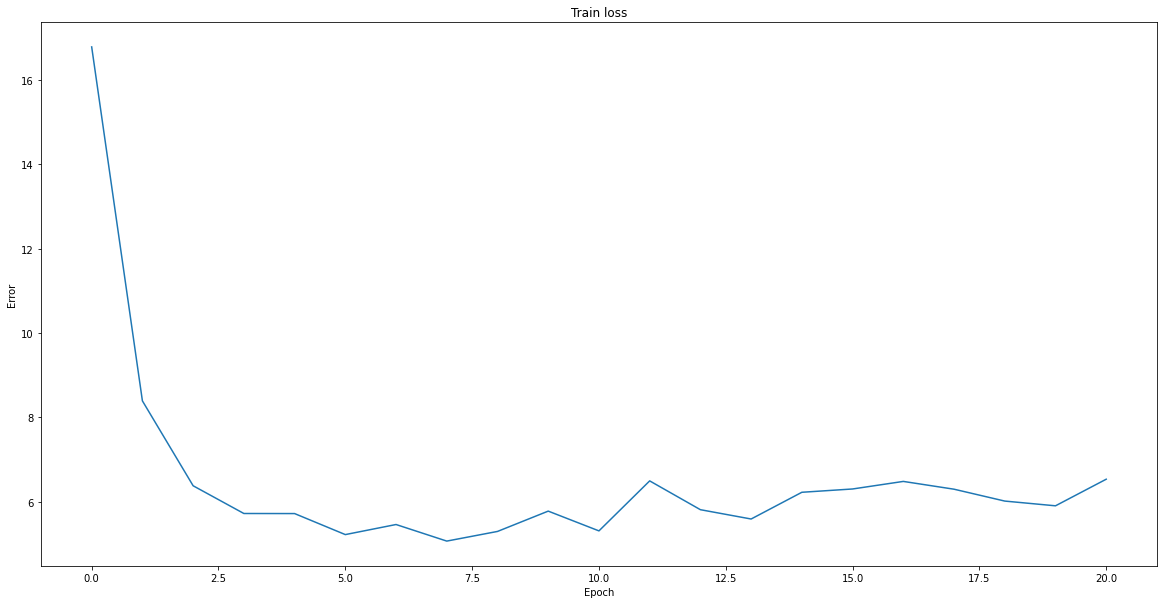

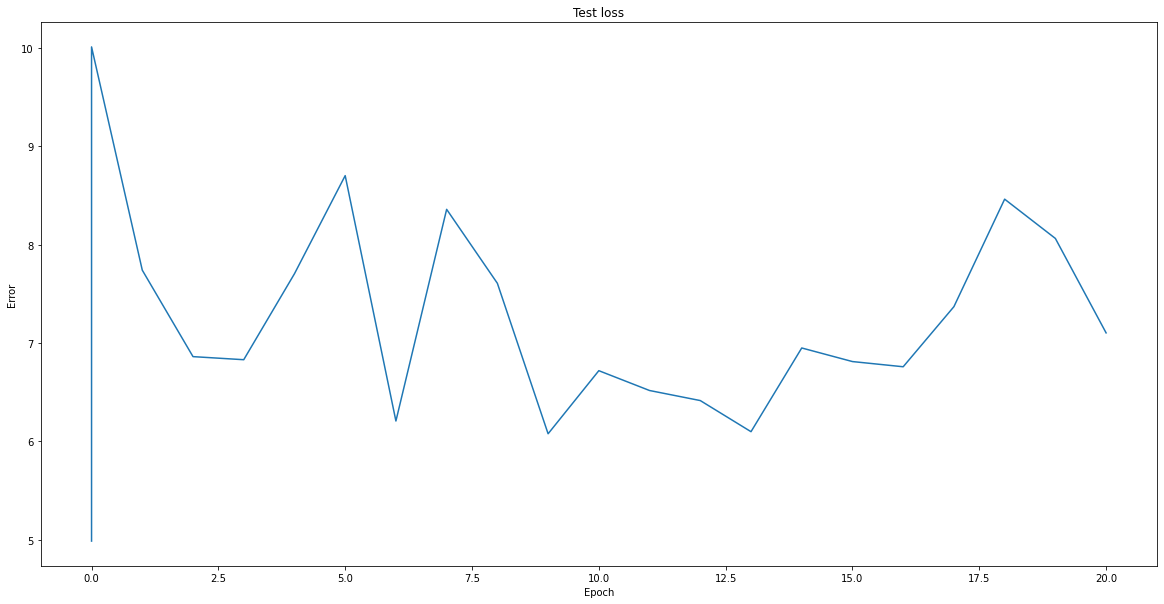

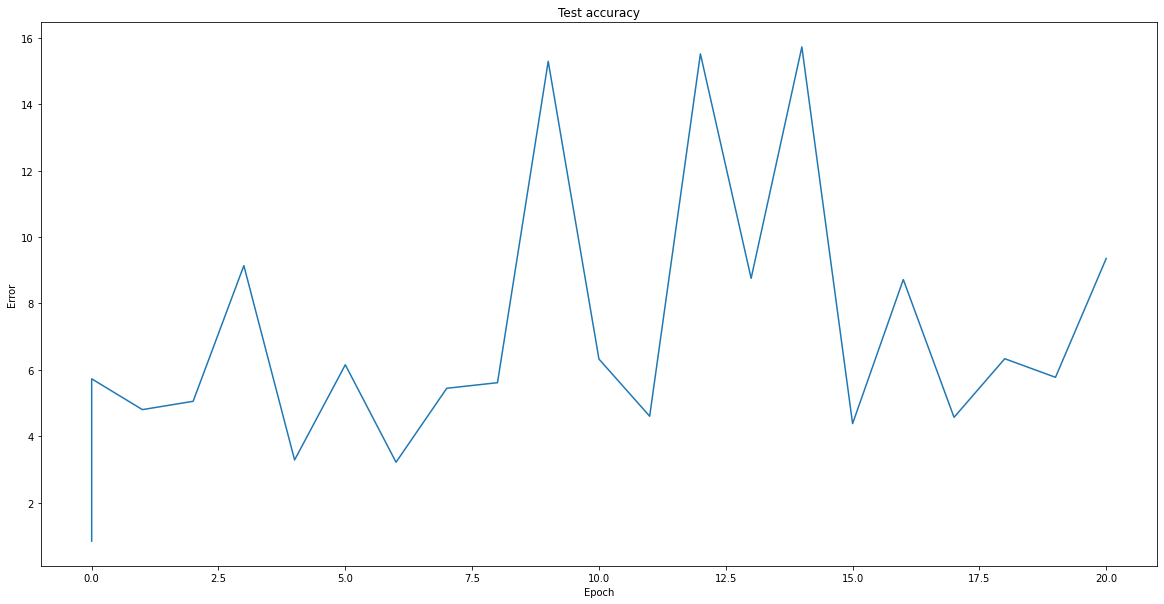

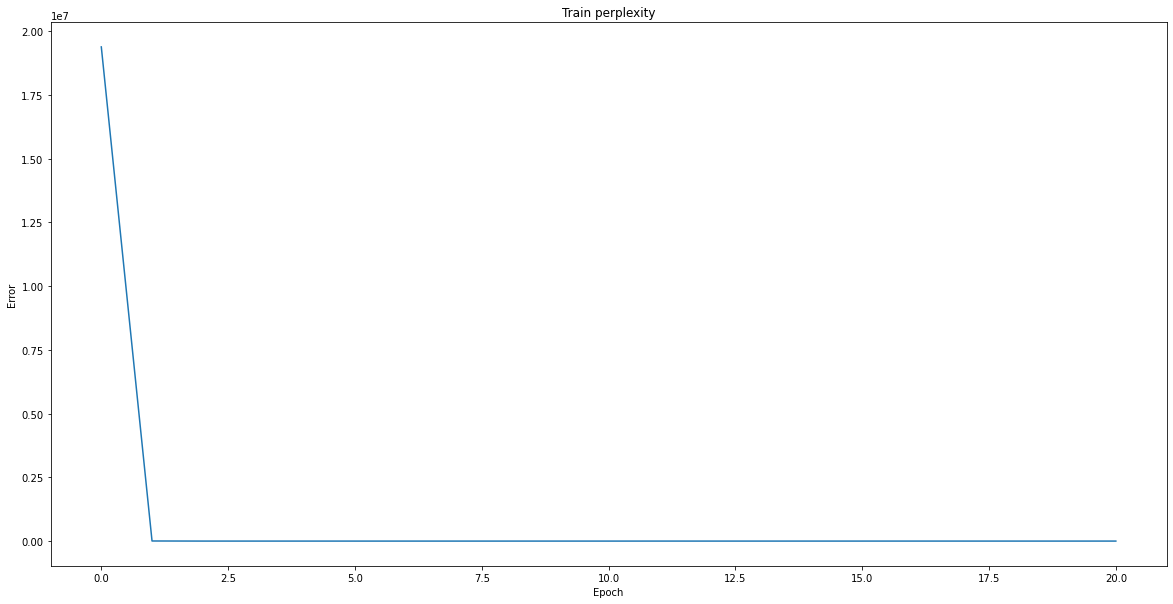

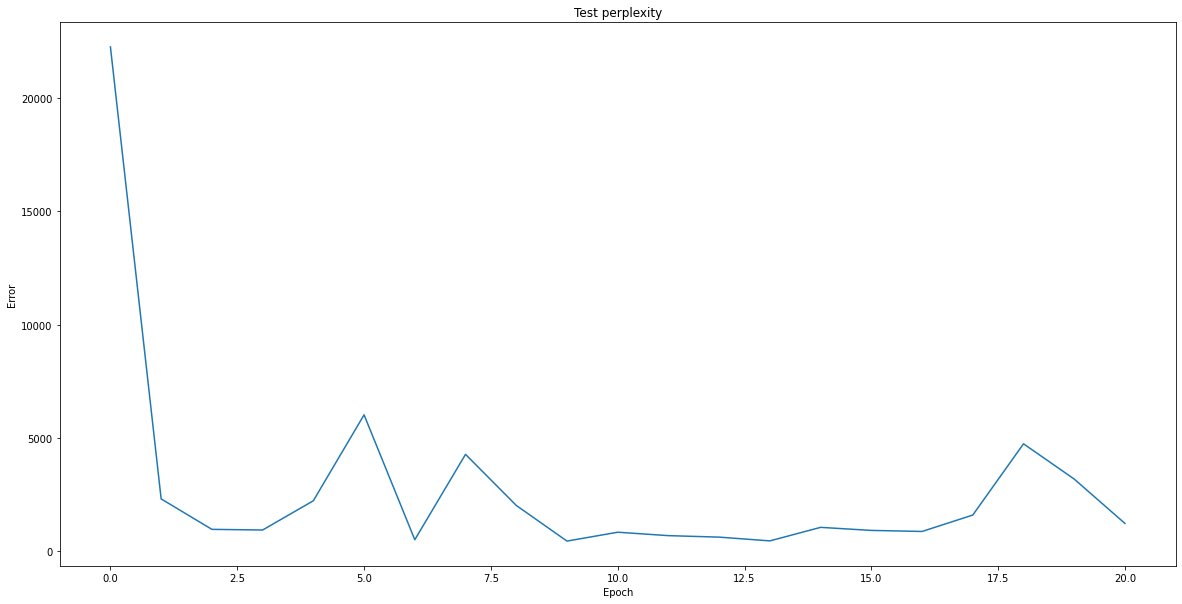

In [11]:
def main():
    SEQUENCE_LENGTH = 100
    BATCH_SIZE = 256
    FEATURE_SIZE = 512*2
    TEST_BATCH_SIZE = 256
    EPOCHS = 20
    LEARNING_RATE = 0.01
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pk02'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints001222')

    train_losses, test_losses, test_accuracies, train_perplexities ,test_perplexities =\
    pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)
    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            # calculate perplexities
            train_perplexity = np.exp(train_loss)
            test_perplexity = np.exp(test_loss)

            train_perplexities.append((epoch,train_perplexity))
            test_perplexities.append((epoch,test_perplexity))
            # 

            pt_util.write_log(LOG_PATH, (train_losses, test_losses, 
                                         test_accuracies,train_perplexities,test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            print('generated max\t\t', generated_sentence)
            for ii in range(10):
                generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
                print('generated sample\t', generated_sentence)
            generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            print('generated beam\t\t', generated_sentence)
            print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')

        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Error')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Error')
        return model, vocab, device

final_model, vocab, device = main()

2.New Architecture
1.  I try to increase the feature size to 1024 and GRU stack layers to 7. The temperature is 0.5. It's performance drops dramatically , the last accuracy is about 7% and it is underfitting and unstable. 
2. As we can see the perplexity in the plot, the lowest perplexity is very large.
3.
**max**: Harry Potter, Voldemort, and Dumbledore walk into a bar.                              nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn

  
  **sample**: Harry Potter, Voldemort, and Dumbledore walk into a bar. anonn n nmnonun rn -K nn es n g hnnntnnnh nn eng nn nne hnn nnnnkrhe n nnnnnnne nhnrnon  ann o nhnn  n on  nnnnhneeen nhnn he n n nnhnn nhen nenhen e eenh aehhn  nnennennnnnh nn n n ne  hnhhahhn nnhnh


  **beam**:Harry Potter, Voldemort, and Dumbledore walk into a bar. nnuenngen s  n  Ken hg n  n  ndnn n  nnnnnih nye n nn  nnn n n ne nnnnek on n  nne nnnh nnnenn  nnn nhe   h nnnnehnnne enoog en n enhn en  ennhnnhe en  nh h  nnn hn  n  hnnnn henne  nnen    n nn eh nh






#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    

# Answer Part 9
1.
  1.All the plot has been plotted above
  2. final test accuracy is 58% and test perplexity is about 4.
  3.**Max**: 
    Harry Potter and the started of the stairs of the stairs of the stairs and stared at her and stared at her and stared at her and stared at her and stared at her and stared at her and stared at her and stared at her and s

   **sample**:
   Harry Potter and the lefting his want doorway, which it keeps burly robes at the sack't the compart. Harry muttered out of her left funch black to teach shame with whirl in her ending fit window, the next raigh and he ha

   **beam**:
    Harry Potter and the began tearing to her clue eg. There was white membered hprity from his wand, for a neared front and smashing starding at Durious MEEM2R TEESTONE IA Hasper is anyone else. Bilload Clught besy decinged

   **prompt:**
    Harry Potter and the
  4. I think the Max produce the most repetitious and accurate spelling words. Sample and beam seams to generate ramdom meaningless words. But beam is more accurate than sample. It conbines the traits between max and sample. Because the temperature is 0.5, the diversity is large while meaningful sentences are less likely.
  5.0.5 is my best result.
when temperature = 0 , the probability of the highest expected value will be reward and it's value would be 1, it's function like max sampling method. when temperature = 0-1, the temperature control the randomness and keep more diversity. When temperature=1, it has not effect in the softmax. When temperature above 1, the probability distribution tend to be flat and their values are close. 
If the temperature is negative, it has reverse effect compare to the postive temperature. It tend to reward less probability values.





# 1. New Corpus
1. Chose the Shakespeare's play, it has 4583798 characters
2. The new corpus more likely generate small sentence with quote, and the sentence is very simple so the words are easier to predict.
3. The temperature is 0.5, the outputs are shown above
**max:**	 So shaken as we are all the death." "Where is the death of men that he were a sun and son" "That that the deed of his constance, and the reason" "That the deed of his constant and that the death" "And that the deed of h


  **sample**	 So shaken as we are son." "Loor, on heavens sin." "Here Pontune, fortural the master adsiac?" "Sives aponta, at thought, knive, that one gots welk" us," "Seceing cryinnut ma knee. S'peace, make deead," "Within thou are 


   **beam:**	 So shaken as we are youth." "Shough id they thank you mee?" "That office, do now, nother was," "The better have letter verought:" "K5sice should I crubt him with toy." Behen setch libstorum." "Exeunt "See-sure, that's a




   
# 2.New Architecture 

1.  I try to increase the feature size to 1024 and GRU stack layers to 7. The temperature is 0.5. It's performance drops dramatically , the last accuracy is about 7% and it is underfitting and unstable. 
2. As we can see the perplexity in the plot, the lowest perplexity is very large.
3.**max**: Harry Potter, Voldemort, and Dumbledore walk into a bar.                              nnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn

  
  **sample**: Harry Potter, Voldemort, and Dumbledore walk into a bar. anonn n nmnonun rn -K nn es n g hnnntnnnh nn eng nn nne hnn nnnnkrhe n nnnnnnne nhnrnon  ann o nhnn  n on  nnnnhneeen nhnn he n n nnhnn nhen nenhen e eenh aehhn  nnennennnnnh nn n n ne  hnhhahhn nnhnh


  **beam**:Harry Potter, Voldemort, and Dumbledore walk into a bar. nnuenngen s  n  Ken hg n  n  ndnn n  nnnnnih nye n nn  nnn n n ne nnnnek on n  nne nnnh nnnenn  nnn nhe   h nnnnehnnne enoog en n enhn en  ennhnnhe en  nh h  nnn hn  n  hnnnn henne  nnen    n nn eh nh




# 3. LSTM

 1.training is going on without difficulties

 2.The results are close to each other.

 3.the outputs for each sampling method is above, temperature=0.5

**max**:	 Harry Potter and the trunk of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the castle of the cast

  **sample**:	 Harry Potter and there was going to tell them potisheve up and sNape. Hard again, and the end of the visid were chung for the flames, home ever cleened down in a darker last betche fell now dainting as someone each his c

  **beam:**	 Harry Potter and they had ensured awover glat decons with the edge of Harry right was shabbly tobacked Hermione intrunce sode of the cobridges up in the cloakhed. "On here, Ginny, said " Good, Parkins desked at it. The c

